##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 迁移学习和微调

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/keras/transfer_learning"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

## 设置

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 简介

**迁移学习**包括获取从一个问题中学习到的特征，然后将这些特征用于新的类似问题。例如，来自已学会识别浣熊的模型的特征可能对建立旨在识别狸猫的模型十分有用。

对于数据集中的数据太少而无法从头开始训练完整模型的任务，通常会执行迁移学习。

在深度学习情境中，迁移学习最常见的形式是以下工作流：

1. 从之前训练的模型中获取层。
2. 冻结这些层，以避免在后续训练轮次中破坏它们包含的任何信息。
3. 在已冻结层的顶部添加一些新的可训练层。这些层会学习将旧特征转换为对新数据集的预测。
4. 在您的数据集上训练新层。

最后一个可选步骤是**微调**，包括解冻上面获得的整个模型（或模型的一部分），然后在新数据上以极低的学习率对该模型进行重新训练。以增量方式使预训练特征适应新数据，有可能实现有意义的改进。

首先，我们将详细介绍 Keras `trainable` API，它是大多数迁移学习和微调工作流的基础。

随后，我们将演示一个典型工作流：先获得一个在 ImageNet 数据集上预训练的模型，然后在 Kaggle Dogs vs. Cats 分类数据集上对该模型进行重新训练。

此工作流改编自[《Python 深度学习》](https://www.manning.com/books/deep-learning-with-python)和 2016 年的博文[“使用极少的数据构建强大的图像分类模型”](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)。

## 冻结层：了解 `trainable` 特性

层和模型具有三个权重特性：

- `weights` 是层的所有权重变量的列表。
- `trainable_weights` 是需要进行更新（通过梯度下降）以尽可能减少训练过程中损失的权重列表。
- `non_trainable_weights` 是不适合训练的权重列表。它们通常在正向传递过程中由模型更新。

**示例：`Dense` 层具有 2 个可训练权重（内核与偏差）**

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


一般而言，所有权重都是可训练权重。唯一具有不可训练权重的内置层是 `BatchNormalization` 层。在训练期间，它使用不可训练权重跟踪其输入的平均值和方差。要了解如何在您自己的自定义层中使用不可训练权重，请参阅[从头开始编写新层的指南](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)。

**示例：`BatchNormalization` 层具有 2 个可训练权重和 2 个不可训练权重**

In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


层和模型还具有布尔特性 `trainable`。此特性的值可以更改。将 `layer.trainable` 设置为 `False` 会将层的所有权重从可训练移至不可训练。这一过程称为“冻结”层：已冻结层的状态在训练期间不会更新（无论是使用 `fit()` 进行训练，还是使用依赖于 `trainable_weights` 来应用梯度更新的任何自定义循环进行训练时）。

**示例：将 `trainable` 设置为 `False`**

In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


当可训练权重变为不可训练时，它的值在训练期间不再更新。

In [6]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - ETA: 0s - loss: 0.0895

1/1 [==============================] - 1s 615ms/step - loss: 0.0895


请勿将 `layer.trainable` 特性与 `layer.__call__()` 中的 `training` 参数（此参数控制层是在推断模式还是训练模式下运行其前向传递）混淆。有关更多信息，请参阅 [Keras 常见问题解答](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)。

## `trainable` 特性的递归设置

如果在模型或具有子层的任何层上设置 `trainable = False`，则所有子层也将变为不可训练。

**示例**

In [7]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## 典型的迁移学习工作流

下面将介绍如何在 Keras 中实现典型的迁移学习工作流：

1. 实例化一个基础模型并加载预训练权重。
2. 通过设置 `trainable = False` 冻结基础模型中的所有层。
3. 根据基础模型中一个（或多个）层的输出创建一个新模型。
4. 在您的新数据集上训练新模型。

请注意，另一种更轻量的工作流如下：

1. 实例化一个基础模型并加载预训练权重。
2. 通过该模型运行新的数据集，并记录基础模型中一个（或多个）层的输出。这一过程称为**特征提取**。
3. 使用该输出作为新的较小模型的输入数据。

第二种工作流有一个关键优势，即您只需在自己的数据上运行一次基础模型，而不是每个训练周期都运行一次。因此，它的速度更快，开销也更低。

但是，第二种工作流存在一个问题，即它不允许您在训练期间动态修改新模型的输入数据，在进行数据扩充时，这种修改必不可少。当新数据集的数据太少而无法从头开始训练完整模型时，任务通常会使用迁移学习，在这种情况下，数据扩充非常重要。因此，在接下来的篇幅中，我们将专注于第一种工作流。

下面是 Keras 中第一种工作流的样子：

首先，实例化一个具有预训练权重的基础模型。

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

随后，冻结该基础模型。

```python
base_model.trainable = False
```

根据基础模型创建一个新模型。

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

在新数据上训练该模型。

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## 微调

一旦模型在新数据上收敛，您就可以尝试解冻全部或部分基础模型，并以极低的学习率端到端地重新训练整个模型。

这是可选的最后一个步骤，可能给您带来增量式改进。不过，它也可能导致快速过拟合，请牢记这一点。

重要的是，只有在将具有冻结层的模型训练至收敛*后*，才能执行此步骤。如果将随机初始化的可训练层与包含预训练特征的可训练层混合使用，则随机初始化的层将在训练过程中引起非常大的梯度更新，而这将破坏您的预训练特征。

在此阶段使用极低的学习率也很重要，因为与第一轮训练相比，您正在一个通常非常小的数据集上训练一个大得多的模型。因此，如果您应用较大的权重更新，则存在很快过拟合的风险。在这里，您只需要以增量方式重新调整预训练权重。

下面是实现整个基础模型微调的方法：

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**关于 `compile()` 和 `trainable` 的重要说明**

在模型上调用 `compile()` 是为了“冻结”该模型的行为。这意味着在编译模型时，应当在该模型的整个生命周期中保留 `trainable` 特性值，直到再次调用 `compile` 为止。因此，如果您更改了任何 `trainable` 值，请确保在模型上再次调用 `compile()`，将这些变更考虑在内。

**关于 `BatchNormalization` 层的重要说明**

许多图像模型都包含 `BatchNormalization` 层。在各种能想到的数量上，该层都是一个特例。需要牢记以下几点。

- `BatchNormalization` 包含 2 个会在训练过程中更新的不可训练权重。它们是跟踪输入的平均值和方差的变量。
- 设置 `bn_layer.trainable = False` 时，`BatchNormalization` 层将以推断模式运行，并且不会更新其均值和方差统计信息。其他层一般不是这种情况，因为[权重可训练性和推断/训练模式是两个正交的概念](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)。但是对于 `BatchNormalization` 层，两者是绑定的。
- 解冻包含 `BatchNormalization` 层的模型以进行微调时，应在调用基础模型时通过传递 `training=False` 来使 `BatchNormalization` 层保持在推断模式下。否则，应用于不可训练权重的更新将突然破坏模型学习到的内容。

您将在本指南结尾处的端到端示例中看到这种模式的实际运行。


## 使用自定义训练循环进行迁移学习和微调

如果您使用的是自己的低级训练循环，而不是 `fit()`，则工作流基本保持不变。在应用梯度更新时，您应当注意仅考虑列表 `model.trainable_weights`：

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

对于微调同样如此。

## 端到端示例：基于 Dogs vs. Cats 数据集微调图像分类模型

为了巩固这些概念，我们先介绍一个具体的端到端迁移学习和微调示例。我们将加载在 ImageNet 上预训练的 Xception 模型，并将其用于 Kaggle Dogs vs. Cats 分类数据集。

### 获取数据

首先，我们使用 TFDS 来获取 Dogs vs. Cats 数据集。如果您拥有自己的数据集，则可能需要使用效用函数 `tf.keras.preprocessing.image_dataset_from_directory` 从磁盘上存档到类特定的文件夹中的一组图像来生成相似的有标签数据集对象。

使用非常小的数据集时，迁移学习最实用。为了使数据集保持较小状态，我们将原始训练数据（25,000 个图像）的 40% 用于训练，10% 用于验证，10% 用于测试。

In [8]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


下面是训练数据集中的前 9 个图像。如您所见，它们具有不同的大小。

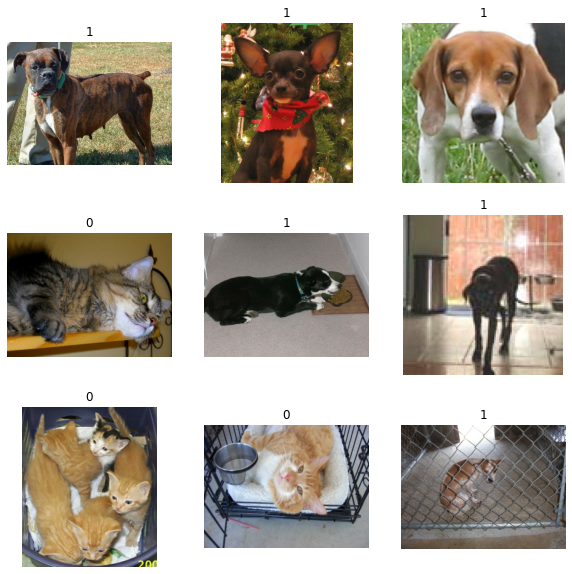

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

我们还可以看到标签 1 是“狗”，标签 0 是“猫”。

### 标准化数据

我们的原始图像有各种大小。另外，每个像素由 0 到 255 之间的 3 个整数值（RGB 色阶值）组成。这不太适合馈送神经网络。我们需要做下面两件事：

- 标准化为固定图像大小。我们选择 150x150。
- 在 -1 至 1 之间归一化像素值。我们将使用 `Normalization` 层作为模型本身的一部分来进行此操作。

一般而言，与采用已预处理数据的模型相反，开发以原始数据作为输入的模型是一种良好的做法。原因在于，如果模型需要预处理的数据，则每次导出模型以在其他地方（在网络浏览器、移动应用中）使用时，都需要重新实现完全相同的预处理流水线。这很快就会变得非常棘手。因此，在命中模型之前，我们应当尽可能少地进行预处理。

在这里，我们将在数据流水线中进行图像大小调整（因为深度神经网络只能处理连续的数据批次），并在创建模型时将其作为模型的一部分进行输入值缩放。

我们将图像的大小调整为 150x150：

In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

此外，我们对数据进行批处理并使用缓存和预提取来优化加载速度。

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### 使用随机数据扩充

当您没有较大的图像数据集时，通过将随机但现实的转换（例如随机水平翻转或小幅随机旋转）应用于训练图像来人为引入样本多样性是一种良好的做法。这有助于使模型暴露于训练数据的不同方面，同时减慢过拟合的速度。

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

我们看一下经过各种随机转换后第一个批次的第一个图像是什么样：

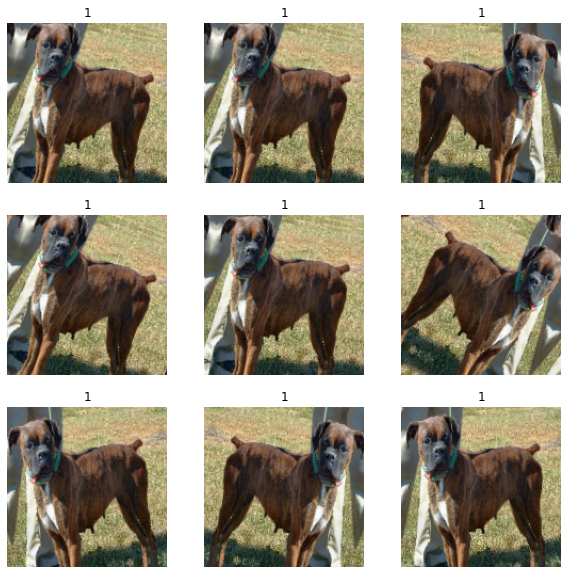

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## 构建模型

现在，我们来构建一个遵循我们先前解释的蓝图的模型。

注意：

- 我们添加 `Normalization` 层以将输入值（最初在 `[0, 255]` 范围内）缩放到 `[-1, 1]` 范围。
- 我们在分类层之前添加一个 `Dropout` 层，以进行正则化。
- 我们确保在调用基础模型时传递 `training=False`，使其在推断模式下运行，这样，即使在我们解冻基础模型以进行微调后，batchnorm 统计信息也不会更新。

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

    8192/83683744 [..............................] - ETA: 1s

 4202496/83683744 [>.............................] - ETA: 8s

16498688/83683744 [====>.........................] - ETA: 1s

32522240/83683744 [==========>...................] - ETA: 0s

33562624/83683744 [===========>..................] - ETA: 1s

41951232/83683744 [==============>...............] - ETA: 0s

51560448/83683744 [=================>............] - ETA: 0s

64503808/83683744 [======================>.......] - ETA: 0s

67117056/83683744 [=======================>......] - ETA: 0s

78176256/83683744 [===========================>..] - ETA: 0s

83689472/83683744 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

## 训练顶层

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


  1/291 [..............................] - ETA: 32:51 - loss: 0.8896 - binary_accuracy: 0.3750

  3/291 [..............................] - ETA: 7s - loss: 0.8994 - binary_accuracy: 0.4132   

  5/291 [..............................] - ETA: 7s - loss: 0.9017 - binary_accuracy: 0.4332

  7/291 [..............................] - ETA: 7s - loss: 0.8805 - binary_accuracy: 0.4637

  9/291 [..............................] - ETA: 7s - loss: 0.8609 - binary_accuracy: 0.4845

 11/291 [>.............................] - ETA: 7s - loss: 0.8435 - binary_accuracy: 0.4984

 13/291 [>.............................] - ETA: 7s - loss: 0.8231 - binary_accuracy: 0.5145

 15/291 [>.............................] - ETA: 7s - loss: 0.8007 - binary_accuracy: 0.5319

 18/291 [>.............................] - ETA: 7s - loss: 0.7689 - binary_accuracy: 0.5558

 20/291 [=>............................] - ETA: 7s - loss: 0.7494 - binary_accuracy: 0.5700

 22/291 [=>............................] - ETA: 7s - loss: 0.7312 - binary_accuracy: 0.5833

 24/291 [=>............................] - ETA: 7s - loss: 0.7138 - binary_accuracy: 0.5958

 26/291 [=>............................] - ETA: 7s - loss: 0.6972 - binary_accuracy: 0.6077

 28/291 [=>............................] - ETA: 7s - loss: 0.6821 - binary_accuracy: 0.6183

 30/291 [==>...........................] - ETA: 6s - loss: 0.6679 - binary_accuracy: 0.6279

 32/291 [==>...........................] - ETA: 6s - loss: 0.6548 - binary_accuracy: 0.6366

 34/291 [==>...........................] - ETA: 6s - loss: 0.6424 - binary_accuracy: 0.6447

 36/291 [==>...........................] - ETA: 6s - loss: 0.6308 - binary_accuracy: 0.6521

 38/291 [==>...........................] - ETA: 6s - loss: 0.6197 - binary_accuracy: 0.6592

 40/291 [===>..........................] - ETA: 6s - loss: 0.6093 - binary_accuracy: 0.6659

 42/291 [===>..........................] - ETA: 6s - loss: 0.5993 - binary_accuracy: 0.6722

 44/291 [===>..........................] - ETA: 6s - loss: 0.5899 - binary_accuracy: 0.6781

 46/291 [===>..........................] - ETA: 6s - loss: 0.5811 - binary_accuracy: 0.6837

 48/291 [===>..........................] - ETA: 6s - loss: 0.5726 - binary_accuracy: 0.6891

 50/291 [====>.........................] - ETA: 6s - loss: 0.5644 - binary_accuracy: 0.6942

 52/291 [====>.........................] - ETA: 6s - loss: 0.5566 - binary_accuracy: 0.6990

 54/291 [====>.........................] - ETA: 6s - loss: 0.5491 - binary_accuracy: 0.7037

 56/291 [====>.........................] - ETA: 6s - loss: 0.5418 - binary_accuracy: 0.7083

 58/291 [====>.........................] - ETA: 6s - loss: 0.5348 - binary_accuracy: 0.7126

 60/291 [=====>........................] - ETA: 6s - loss: 0.5280 - binary_accuracy: 0.7168

 62/291 [=====>........................] - ETA: 6s - loss: 0.5214 - binary_accuracy: 0.7208

 64/291 [=====>........................] - ETA: 5s - loss: 0.5152 - binary_accuracy: 0.7247

 66/291 [=====>........................] - ETA: 5s - loss: 0.5091 - binary_accuracy: 0.7284

 68/291 [======>.......................] - ETA: 5s - loss: 0.5034 - binary_accuracy: 0.7319

 70/291 [======>.......................] - ETA: 5s - loss: 0.4978 - binary_accuracy: 0.7353

 72/291 [======>.......................] - ETA: 5s - loss: 0.4924 - binary_accuracy: 0.7386

 74/291 [======>.......................] - ETA: 5s - loss: 0.4872 - binary_accuracy: 0.7418

 77/291 [======>.......................] - ETA: 5s - loss: 0.4797 - binary_accuracy: 0.7464

 79/291 [=======>......................] - ETA: 5s - loss: 0.4748 - binary_accuracy: 0.7493

 82/291 [=======>......................] - ETA: 5s - loss: 0.4679 - binary_accuracy: 0.7534

 84/291 [=======>......................] - ETA: 5s - loss: 0.4634 - binary_accuracy: 0.7561

 86/291 [=======>......................] - ETA: 5s - loss: 0.4591 - binary_accuracy: 0.7587

 88/291 [========>.....................] - ETA: 5s - loss: 0.4550 - binary_accuracy: 0.7612

 90/291 [========>.....................] - ETA: 5s - loss: 0.4509 - binary_accuracy: 0.7636

 92/291 [========>.....................] - ETA: 5s - loss: 0.4469 - binary_accuracy: 0.7660

 94/291 [========>.....................] - ETA: 5s - loss: 0.4431 - binary_accuracy: 0.7682

 96/291 [========>.....................] - ETA: 5s - loss: 0.4393 - binary_accuracy: 0.7705

 98/291 [=========>....................] - ETA: 5s - loss: 0.4357 - binary_accuracy: 0.7726

100/291 [=========>....................] - ETA: 5s - loss: 0.4322 - binary_accuracy: 0.7747

102/291 [=========>....................] - ETA: 4s - loss: 0.4288 - binary_accuracy: 0.7767

105/291 [=========>....................] - ETA: 4s - loss: 0.4239 - binary_accuracy: 0.7796

107/291 [==========>...................] - ETA: 4s - loss: 0.4207 - binary_accuracy: 0.7814

109/291 [==========>...................] - ETA: 4s - loss: 0.4176 - binary_accuracy: 0.7832

111/291 [==========>...................] - ETA: 4s - loss: 0.4146 - binary_accuracy: 0.7850

113/291 [==========>...................] - ETA: 4s - loss: 0.4117 - binary_accuracy: 0.7867

115/291 [==========>...................] - ETA: 4s - loss: 0.4089 - binary_accuracy: 0.7884

117/291 [===========>..................] - ETA: 4s - loss: 0.4061 - binary_accuracy: 0.7901

120/291 [===========>..................] - ETA: 4s - loss: 0.4021 - binary_accuracy: 0.7925

122/291 [===========>..................] - ETA: 4s - loss: 0.3994 - binary_accuracy: 0.7940

124/291 [===========>..................] - ETA: 4s - loss: 0.3969 - binary_accuracy: 0.7955

126/291 [===========>..................] - ETA: 4s - loss: 0.3944 - binary_accuracy: 0.7969

128/291 [============>.................] - ETA: 4s - loss: 0.3920 - binary_accuracy: 0.7983

130/291 [============>.................] - ETA: 4s - loss: 0.3897 - binary_accuracy: 0.7997

132/291 [============>.................] - ETA: 4s - loss: 0.3874 - binary_accuracy: 0.8011

134/291 [============>.................] - ETA: 4s - loss: 0.3851 - binary_accuracy: 0.8024

136/291 [=============>................] - ETA: 4s - loss: 0.3829 - binary_accuracy: 0.8037

138/291 [=============>................] - ETA: 4s - loss: 0.3808 - binary_accuracy: 0.8050

140/291 [=============>................] - ETA: 3s - loss: 0.3787 - binary_accuracy: 0.8062

142/291 [=============>................] - ETA: 3s - loss: 0.3766 - binary_accuracy: 0.8074

144/291 [=============>................] - ETA: 3s - loss: 0.3746 - binary_accuracy: 0.8086

146/291 [==============>...............] - ETA: 3s - loss: 0.3726 - binary_accuracy: 0.8098

148/291 [==============>...............] - ETA: 3s - loss: 0.3706 - binary_accuracy: 0.8110

150/291 [==============>...............] - ETA: 3s - loss: 0.3687 - binary_accuracy: 0.8121

152/291 [==============>...............] - ETA: 3s - loss: 0.3668 - binary_accuracy: 0.8133

154/291 [==============>...............] - ETA: 3s - loss: 0.3649 - binary_accuracy: 0.8144

156/291 [===============>..............] - ETA: 3s - loss: 0.3631 - binary_accuracy: 0.8154

159/291 [===============>..............] - ETA: 3s - loss: 0.3604 - binary_accuracy: 0.8170

161/291 [===============>..............] - ETA: 3s - loss: 0.3586 - binary_accuracy: 0.8180

163/291 [===============>..............] - ETA: 3s - loss: 0.3569 - binary_accuracy: 0.8191

165/291 [================>.............] - ETA: 3s - loss: 0.3552 - binary_accuracy: 0.8200

167/291 [================>.............] - ETA: 3s - loss: 0.3536 - binary_accuracy: 0.8210

170/291 [================>.............] - ETA: 3s - loss: 0.3511 - binary_accuracy: 0.8225

172/291 [================>.............] - ETA: 3s - loss: 0.3496 - binary_accuracy: 0.8234

174/291 [================>.............] - ETA: 3s - loss: 0.3480 - binary_accuracy: 0.8243

176/291 [=================>............] - ETA: 3s - loss: 0.3464 - binary_accuracy: 0.8252

178/291 [=================>............] - ETA: 2s - loss: 0.3449 - binary_accuracy: 0.8261

180/291 [=================>............] - ETA: 2s - loss: 0.3434 - binary_accuracy: 0.8270

182/291 [=================>............] - ETA: 2s - loss: 0.3420 - binary_accuracy: 0.8278

184/291 [=================>............] - ETA: 2s - loss: 0.3405 - binary_accuracy: 0.8287

186/291 [==================>...........] - ETA: 2s - loss: 0.3391 - binary_accuracy: 0.8295

188/291 [==================>...........] - ETA: 2s - loss: 0.3377 - binary_accuracy: 0.8303

190/291 [==================>...........] - ETA: 2s - loss: 0.3363 - binary_accuracy: 0.8311

193/291 [==================>...........] - ETA: 2s - loss: 0.3343 - binary_accuracy: 0.8323

195/291 [===================>..........] - ETA: 2s - loss: 0.3330 - binary_accuracy: 0.8331

197/291 [===================>..........] - ETA: 2s - loss: 0.3317 - binary_accuracy: 0.8338

199/291 [===================>..........] - ETA: 2s - loss: 0.3305 - binary_accuracy: 0.8346

201/291 [===================>..........] - ETA: 2s - loss: 0.3292 - binary_accuracy: 0.8353

203/291 [===================>..........] - ETA: 2s - loss: 0.3280 - binary_accuracy: 0.8360

205/291 [====================>.........] - ETA: 2s - loss: 0.3268 - binary_accuracy: 0.8367

207/291 [====================>.........] - ETA: 2s - loss: 0.3256 - binary_accuracy: 0.8374

210/291 [====================>.........] - ETA: 2s - loss: 0.3239 - binary_accuracy: 0.8384

213/291 [====================>.........] - ETA: 2s - loss: 0.3222 - binary_accuracy: 0.8393

216/291 [=====================>........] - ETA: 1s - loss: 0.3205 - binary_accuracy: 0.8403

219/291 [=====================>........] - ETA: 1s - loss: 0.3189 - binary_accuracy: 0.8412

221/291 [=====================>........] - ETA: 2s - loss: 0.3178 - binary_accuracy: 0.8419

223/291 [=====================>........] - ETA: 2s - loss: 0.3168 - binary_accuracy: 0.8425

225/291 [======================>.......] - ETA: 2s - loss: 0.3157 - binary_accuracy: 0.8431

227/291 [======================>.......] - ETA: 2s - loss: 0.3147 - binary_accuracy: 0.8437

229/291 [======================>.......] - ETA: 2s - loss: 0.3137 - binary_accuracy: 0.8442

231/291 [======================>.......] - ETA: 2s - loss: 0.3127 - binary_accuracy: 0.8448

233/291 [=======================>......] - ETA: 1s - loss: 0.3117 - binary_accuracy: 0.8454

235/291 [=======================>......] - ETA: 1s - loss: 0.3107 - binary_accuracy: 0.8460

237/291 [=======================>......] - ETA: 1s - loss: 0.3097 - binary_accuracy: 0.8465

239/291 [=======================>......] - ETA: 1s - loss: 0.3087 - binary_accuracy: 0.8471

241/291 [=======================>......] - ETA: 1s - loss: 0.3078 - binary_accuracy: 0.8476

243/291 [========================>.....] - ETA: 1s - loss: 0.3068 - binary_accuracy: 0.8482

245/291 [========================>.....] - ETA: 1s - loss: 0.3059 - binary_accuracy: 0.8487

247/291 [========================>.....] - ETA: 1s - loss: 0.3049 - binary_accuracy: 0.8493

249/291 [========================>.....] - ETA: 1s - loss: 0.3040 - binary_accuracy: 0.8498

251/291 [========================>.....] - ETA: 1s - loss: 0.3031 - binary_accuracy: 0.8503

253/291 [=========================>....] - ETA: 1s - loss: 0.3022 - binary_accuracy: 0.8508

255/291 [=========================>....] - ETA: 1s - loss: 0.3014 - binary_accuracy: 0.8513

257/291 [=========================>....] - ETA: 1s - loss: 0.3005 - binary_accuracy: 0.8518

259/291 [=========================>....] - ETA: 1s - loss: 0.2996 - binary_accuracy: 0.8523

261/291 [=========================>....] - ETA: 1s - loss: 0.2988 - binary_accuracy: 0.8528

264/291 [==========================>...] - ETA: 0s - loss: 0.2975 - binary_accuracy: 0.8535

266/291 [==========================>...] - ETA: 0s - loss: 0.2967 - binary_accuracy: 0.8540

268/291 [==========================>...] - ETA: 0s - loss: 0.2959 - binary_accuracy: 0.8545

270/291 [==========================>...] - ETA: 0s - loss: 0.2951 - binary_accuracy: 0.8549

272/291 [===========================>..] - ETA: 0s - loss: 0.2943 - binary_accuracy: 0.8554

274/291 [===========================>..] - ETA: 0s - loss: 0.2935 - binary_accuracy: 0.8558

276/291 [===========================>..] - ETA: 0s - loss: 0.2927 - binary_accuracy: 0.8563

278/291 [===========================>..] - ETA: 0s - loss: 0.2919 - binary_accuracy: 0.8567

281/291 [===========================>..] - ETA: 0s - loss: 0.2907 - binary_accuracy: 0.8574

284/291 [============================>.] - ETA: 0s - loss: 0.2896 - binary_accuracy: 0.8580

287/291 [============================>.] - ETA: 0s - loss: 0.2884 - binary_accuracy: 0.8587

290/291 [============================>.] - ETA: 0s - loss: 0.2873 - binary_accuracy: 0.8593

291/291 [==============================] - ETA: 0s - loss: 0.2870 - binary_accuracy: 0.8595

291/291 [==============================] - 20s 46ms/step - loss: 0.2866 - binary_accuracy: 0.8597 - val_loss: 0.0833 - val_binary_accuracy: 0.9690


Epoch 2/20
  1/291 [..............................] - ETA: 6s - loss: 0.1500 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1598 - binary_accuracy: 0.9316

  7/291 [..............................] - ETA: 6s - loss: 0.1670 - binary_accuracy: 0.9332

 10/291 [>.............................] - ETA: 6s - loss: 0.1704 - binary_accuracy: 0.9315

 13/291 [>.............................] - ETA: 6s - loss: 0.1735 - binary_accuracy: 0.9281

 16/291 [>.............................] - ETA: 6s - loss: 0.1738 - binary_accuracy: 0.9273

 19/291 [>.............................] - ETA: 5s - loss: 0.1715 - binary_accuracy: 0.9282

 22/291 [=>............................] - ETA: 5s - loss: 0.1689 - binary_accuracy: 0.9294

 25/291 [=>............................] - ETA: 5s - loss: 0.1663 - binary_accuracy: 0.9305

 28/291 [=>............................] - ETA: 5s - loss: 0.1637 - binary_accuracy: 0.9316

 31/291 [==>...........................] - ETA: 5s - loss: 0.1616 - binary_accuracy: 0.9325

 34/291 [==>...........................] - ETA: 5s - loss: 0.1598 - binary_accuracy: 0.9333

 37/291 [==>...........................] - ETA: 5s - loss: 0.1581 - binary_accuracy: 0.9339

 40/291 [===>..........................] - ETA: 5s - loss: 0.1565 - binary_accuracy: 0.9345

 43/291 [===>..........................] - ETA: 5s - loss: 0.1551 - binary_accuracy: 0.9350

 46/291 [===>..........................] - ETA: 5s - loss: 0.1537 - binary_accuracy: 0.9355

 49/291 [====>.........................] - ETA: 5s - loss: 0.1527 - binary_accuracy: 0.9359

 52/291 [====>.........................] - ETA: 5s - loss: 0.1516 - binary_accuracy: 0.9363

 55/291 [====>.........................] - ETA: 5s - loss: 0.1506 - binary_accuracy: 0.9368

 58/291 [====>.........................] - ETA: 5s - loss: 0.1496 - binary_accuracy: 0.9371

 61/291 [=====>........................] - ETA: 4s - loss: 0.1485 - binary_accuracy: 0.9376

 64/291 [=====>........................] - ETA: 4s - loss: 0.1474 - binary_accuracy: 0.9380

 67/291 [=====>........................] - ETA: 4s - loss: 0.1464 - binary_accuracy: 0.9385

 70/291 [======>.......................] - ETA: 4s - loss: 0.1453 - binary_accuracy: 0.9389

 73/291 [======>.......................] - ETA: 4s - loss: 0.1444 - binary_accuracy: 0.9392

 76/291 [======>.......................] - ETA: 4s - loss: 0.1437 - binary_accuracy: 0.9395

 79/291 [=======>......................] - ETA: 4s - loss: 0.1429 - binary_accuracy: 0.9397

 82/291 [=======>......................] - ETA: 4s - loss: 0.1422 - binary_accuracy: 0.9400

 85/291 [=======>......................] - ETA: 4s - loss: 0.1416 - binary_accuracy: 0.9402

 88/291 [========>.....................] - ETA: 4s - loss: 0.1411 - binary_accuracy: 0.9405

 91/291 [========>.....................] - ETA: 4s - loss: 0.1405 - binary_accuracy: 0.9407

 94/291 [========>.....................] - ETA: 4s - loss: 0.1400 - binary_accuracy: 0.9409

 97/291 [=========>....................] - ETA: 4s - loss: 0.1395 - binary_accuracy: 0.9411

100/291 [=========>....................] - ETA: 4s - loss: 0.1390 - binary_accuracy: 0.9413

103/291 [=========>....................] - ETA: 4s - loss: 0.1386 - binary_accuracy: 0.9414

106/291 [=========>....................] - ETA: 4s - loss: 0.1382 - binary_accuracy: 0.9416

109/291 [==========>...................] - ETA: 3s - loss: 0.1379 - binary_accuracy: 0.9418

112/291 [==========>...................] - ETA: 3s - loss: 0.1375 - binary_accuracy: 0.9419

115/291 [==========>...................] - ETA: 3s - loss: 0.1371 - binary_accuracy: 0.9421

118/291 [===========>..................] - ETA: 3s - loss: 0.1368 - binary_accuracy: 0.9423

121/291 [===========>..................] - ETA: 3s - loss: 0.1365 - binary_accuracy: 0.9424

124/291 [===========>..................] - ETA: 3s - loss: 0.1362 - binary_accuracy: 0.9426

127/291 [============>.................] - ETA: 3s - loss: 0.1359 - binary_accuracy: 0.9427

130/291 [============>.................] - ETA: 3s - loss: 0.1357 - binary_accuracy: 0.9428

133/291 [============>.................] - ETA: 3s - loss: 0.1354 - binary_accuracy: 0.9429

136/291 [=============>................] - ETA: 3s - loss: 0.1352 - binary_accuracy: 0.9430

139/291 [=============>................] - ETA: 3s - loss: 0.1350 - binary_accuracy: 0.9432

142/291 [=============>................] - ETA: 3s - loss: 0.1347 - binary_accuracy: 0.9433

145/291 [=============>................] - ETA: 3s - loss: 0.1345 - binary_accuracy: 0.9434

148/291 [==============>...............] - ETA: 3s - loss: 0.1343 - binary_accuracy: 0.9435

151/291 [==============>...............] - ETA: 3s - loss: 0.1340 - binary_accuracy: 0.9436

154/291 [==============>...............] - ETA: 2s - loss: 0.1338 - binary_accuracy: 0.9438

157/291 [===============>..............] - ETA: 2s - loss: 0.1336 - binary_accuracy: 0.9439

160/291 [===============>..............] - ETA: 2s - loss: 0.1333 - binary_accuracy: 0.9440

163/291 [===============>..............] - ETA: 2s - loss: 0.1331 - binary_accuracy: 0.9441

166/291 [================>.............] - ETA: 2s - loss: 0.1329 - binary_accuracy: 0.9442

169/291 [================>.............] - ETA: 2s - loss: 0.1326 - binary_accuracy: 0.9443

172/291 [================>.............] - ETA: 2s - loss: 0.1324 - binary_accuracy: 0.9444

175/291 [=================>............] - ETA: 2s - loss: 0.1322 - binary_accuracy: 0.9446

178/291 [=================>............] - ETA: 2s - loss: 0.1320 - binary_accuracy: 0.9447

181/291 [=================>............] - ETA: 2s - loss: 0.1318 - binary_accuracy: 0.9448

184/291 [=================>............] - ETA: 2s - loss: 0.1316 - binary_accuracy: 0.9449

187/291 [==================>...........] - ETA: 2s - loss: 0.1315 - binary_accuracy: 0.9450

190/291 [==================>...........] - ETA: 2s - loss: 0.1313 - binary_accuracy: 0.9450

193/291 [==================>...........] - ETA: 2s - loss: 0.1312 - binary_accuracy: 0.9451

196/291 [===================>..........] - ETA: 2s - loss: 0.1311 - binary_accuracy: 0.9452

199/291 [===================>..........] - ETA: 1s - loss: 0.1309 - binary_accuracy: 0.9452

202/291 [===================>..........] - ETA: 1s - loss: 0.1308 - binary_accuracy: 0.9453

205/291 [====================>.........] - ETA: 1s - loss: 0.1307 - binary_accuracy: 0.9454

208/291 [====================>.........] - ETA: 1s - loss: 0.1306 - binary_accuracy: 0.9454

211/291 [====================>.........] - ETA: 1s - loss: 0.1305 - binary_accuracy: 0.9455

214/291 [=====================>........] - ETA: 1s - loss: 0.1305 - binary_accuracy: 0.9455

217/291 [=====================>........] - ETA: 1s - loss: 0.1304 - binary_accuracy: 0.9455

220/291 [=====================>........] - ETA: 1s - loss: 0.1303 - binary_accuracy: 0.9456

223/291 [=====================>........] - ETA: 1s - loss: 0.1302 - binary_accuracy: 0.9456

226/291 [======================>.......] - ETA: 1s - loss: 0.1301 - binary_accuracy: 0.9457

229/291 [======================>.......] - ETA: 1s - loss: 0.1300 - binary_accuracy: 0.9458

232/291 [======================>.......] - ETA: 1s - loss: 0.1299 - binary_accuracy: 0.9458

235/291 [=======================>......] - ETA: 1s - loss: 0.1298 - binary_accuracy: 0.9459

238/291 [=======================>......] - ETA: 1s - loss: 0.1297 - binary_accuracy: 0.9459

241/291 [=======================>......] - ETA: 1s - loss: 0.1296 - binary_accuracy: 0.9460

244/291 [========================>.....] - ETA: 1s - loss: 0.1295 - binary_accuracy: 0.9460

247/291 [========================>.....] - ETA: 0s - loss: 0.1294 - binary_accuracy: 0.9460

250/291 [========================>.....] - ETA: 0s - loss: 0.1293 - binary_accuracy: 0.9461

253/291 [=========================>....] - ETA: 0s - loss: 0.1292 - binary_accuracy: 0.9461

256/291 [=========================>....] - ETA: 0s - loss: 0.1292 - binary_accuracy: 0.9462

259/291 [=========================>....] - ETA: 0s - loss: 0.1291 - binary_accuracy: 0.9462

262/291 [==========================>...] - ETA: 0s - loss: 0.1290 - binary_accuracy: 0.9463

265/291 [==========================>...] - ETA: 0s - loss: 0.1289 - binary_accuracy: 0.9463

268/291 [==========================>...] - ETA: 0s - loss: 0.1288 - binary_accuracy: 0.9463

271/291 [==========================>...] - ETA: 0s - loss: 0.1287 - binary_accuracy: 0.9464

274/291 [===========================>..] - ETA: 0s - loss: 0.1286 - binary_accuracy: 0.9464

277/291 [===========================>..] - ETA: 0s - loss: 0.1285 - binary_accuracy: 0.9464

280/291 [===========================>..] - ETA: 0s - loss: 0.1284 - binary_accuracy: 0.9465

283/291 [============================>.] - ETA: 0s - loss: 0.1283 - binary_accuracy: 0.9465

286/291 [============================>.] - ETA: 0s - loss: 0.1282 - binary_accuracy: 0.9466

289/291 [============================>.] - ETA: 0s - loss: 0.1281 - binary_accuracy: 0.9466

291/291 [==============================] - 8s 27ms/step - loss: 0.1280 - binary_accuracy: 0.9466 - val_loss: 0.0774 - val_binary_accuracy: 0.9712


Epoch 3/20
  1/291 [..............................] - ETA: 7s - loss: 0.2041 - binary_accuracy: 0.8750

  4/291 [..............................] - ETA: 6s - loss: 0.1824 - binary_accuracy: 0.8991

  7/291 [..............................] - ETA: 6s - loss: 0.1722 - binary_accuracy: 0.9139

 10/291 [>.............................] - ETA: 6s - loss: 0.1675 - binary_accuracy: 0.9186

 13/291 [>.............................] - ETA: 5s - loss: 0.1640 - binary_accuracy: 0.9215

 16/291 [>.............................] - ETA: 5s - loss: 0.1604 - binary_accuracy: 0.9242

 19/291 [>.............................] - ETA: 5s - loss: 0.1556 - binary_accuracy: 0.9271

 22/291 [=>............................] - ETA: 5s - loss: 0.1514 - binary_accuracy: 0.9296

 25/291 [=>............................] - ETA: 5s - loss: 0.1483 - binary_accuracy: 0.9314

 28/291 [=>............................] - ETA: 5s - loss: 0.1461 - binary_accuracy: 0.9326

 31/291 [==>...........................] - ETA: 5s - loss: 0.1448 - binary_accuracy: 0.9334

 34/291 [==>...........................] - ETA: 5s - loss: 0.1438 - binary_accuracy: 0.9340

 37/291 [==>...........................] - ETA: 5s - loss: 0.1429 - binary_accuracy: 0.9346

 40/291 [===>..........................] - ETA: 5s - loss: 0.1419 - binary_accuracy: 0.9352

 43/291 [===>..........................] - ETA: 5s - loss: 0.1408 - binary_accuracy: 0.9360

 46/291 [===>..........................] - ETA: 5s - loss: 0.1398 - binary_accuracy: 0.9367

 49/291 [====>.........................] - ETA: 5s - loss: 0.1389 - binary_accuracy: 0.9373

 52/291 [====>.........................] - ETA: 5s - loss: 0.1380 - binary_accuracy: 0.9379

 55/291 [====>.........................] - ETA: 5s - loss: 0.1371 - binary_accuracy: 0.9386

 58/291 [====>.........................] - ETA: 5s - loss: 0.1361 - binary_accuracy: 0.9392

 61/291 [=====>........................] - ETA: 4s - loss: 0.1351 - binary_accuracy: 0.9398

 64/291 [=====>........................] - ETA: 4s - loss: 0.1341 - binary_accuracy: 0.9405

 67/291 [=====>........................] - ETA: 4s - loss: 0.1331 - binary_accuracy: 0.9411

 70/291 [======>.......................] - ETA: 4s - loss: 0.1321 - binary_accuracy: 0.9418

 73/291 [======>.......................] - ETA: 4s - loss: 0.1312 - binary_accuracy: 0.9423

 76/291 [======>.......................] - ETA: 4s - loss: 0.1304 - binary_accuracy: 0.9428

 79/291 [=======>......................] - ETA: 4s - loss: 0.1296 - binary_accuracy: 0.9432

 82/291 [=======>......................] - ETA: 4s - loss: 0.1290 - binary_accuracy: 0.9437

 85/291 [=======>......................] - ETA: 4s - loss: 0.1284 - binary_accuracy: 0.9441

 88/291 [========>.....................] - ETA: 4s - loss: 0.1278 - binary_accuracy: 0.9444

 91/291 [========>.....................] - ETA: 4s - loss: 0.1273 - binary_accuracy: 0.9448

 94/291 [========>.....................] - ETA: 4s - loss: 0.1267 - binary_accuracy: 0.9451

 97/291 [=========>....................] - ETA: 4s - loss: 0.1262 - binary_accuracy: 0.9455

100/291 [=========>....................] - ETA: 4s - loss: 0.1257 - binary_accuracy: 0.9457

103/291 [=========>....................] - ETA: 4s - loss: 0.1253 - binary_accuracy: 0.9460

106/291 [=========>....................] - ETA: 3s - loss: 0.1249 - binary_accuracy: 0.9463

109/291 [==========>...................] - ETA: 3s - loss: 0.1245 - binary_accuracy: 0.9465

112/291 [==========>...................] - ETA: 3s - loss: 0.1242 - binary_accuracy: 0.9468

115/291 [==========>...................] - ETA: 3s - loss: 0.1239 - binary_accuracy: 0.9470

118/291 [===========>..................] - ETA: 3s - loss: 0.1237 - binary_accuracy: 0.9472

121/291 [===========>..................] - ETA: 3s - loss: 0.1234 - binary_accuracy: 0.9473

124/291 [===========>..................] - ETA: 3s - loss: 0.1233 - binary_accuracy: 0.9475

127/291 [============>.................] - ETA: 3s - loss: 0.1232 - binary_accuracy: 0.9476

130/291 [============>.................] - ETA: 3s - loss: 0.1231 - binary_accuracy: 0.9477

133/291 [============>.................] - ETA: 3s - loss: 0.1229 - binary_accuracy: 0.9478

136/291 [=============>................] - ETA: 3s - loss: 0.1228 - binary_accuracy: 0.9479

139/291 [=============>................] - ETA: 3s - loss: 0.1227 - binary_accuracy: 0.9479

142/291 [=============>................] - ETA: 3s - loss: 0.1226 - binary_accuracy: 0.9480

145/291 [=============>................] - ETA: 3s - loss: 0.1226 - binary_accuracy: 0.9481

148/291 [==============>...............] - ETA: 3s - loss: 0.1225 - binary_accuracy: 0.9481

151/291 [==============>...............] - ETA: 3s - loss: 0.1224 - binary_accuracy: 0.9482

154/291 [==============>...............] - ETA: 2s - loss: 0.1222 - binary_accuracy: 0.9483

157/291 [===============>..............] - ETA: 2s - loss: 0.1221 - binary_accuracy: 0.9484

160/291 [===============>..............] - ETA: 2s - loss: 0.1220 - binary_accuracy: 0.9484

163/291 [===============>..............] - ETA: 2s - loss: 0.1219 - binary_accuracy: 0.9485

166/291 [================>.............] - ETA: 2s - loss: 0.1217 - binary_accuracy: 0.9486

169/291 [================>.............] - ETA: 2s - loss: 0.1216 - binary_accuracy: 0.9487

172/291 [================>.............] - ETA: 2s - loss: 0.1215 - binary_accuracy: 0.9487

175/291 [=================>............] - ETA: 2s - loss: 0.1214 - binary_accuracy: 0.9488

178/291 [=================>............] - ETA: 2s - loss: 0.1213 - binary_accuracy: 0.9488

181/291 [=================>............] - ETA: 2s - loss: 0.1212 - binary_accuracy: 0.9489

184/291 [=================>............] - ETA: 2s - loss: 0.1211 - binary_accuracy: 0.9489

187/291 [==================>...........] - ETA: 2s - loss: 0.1210 - binary_accuracy: 0.9490

190/291 [==================>...........] - ETA: 2s - loss: 0.1209 - binary_accuracy: 0.9490

193/291 [==================>...........] - ETA: 2s - loss: 0.1208 - binary_accuracy: 0.9490

196/291 [===================>..........] - ETA: 2s - loss: 0.1207 - binary_accuracy: 0.9491

199/291 [===================>..........] - ETA: 1s - loss: 0.1206 - binary_accuracy: 0.9491

202/291 [===================>..........] - ETA: 1s - loss: 0.1205 - binary_accuracy: 0.9491

205/291 [====================>.........] - ETA: 1s - loss: 0.1205 - binary_accuracy: 0.9492

208/291 [====================>.........] - ETA: 1s - loss: 0.1204 - binary_accuracy: 0.9492

211/291 [====================>.........] - ETA: 1s - loss: 0.1204 - binary_accuracy: 0.9492

214/291 [=====================>........] - ETA: 1s - loss: 0.1203 - binary_accuracy: 0.9492

217/291 [=====================>........] - ETA: 1s - loss: 0.1202 - binary_accuracy: 0.9493

220/291 [=====================>........] - ETA: 1s - loss: 0.1202 - binary_accuracy: 0.9493

223/291 [=====================>........] - ETA: 1s - loss: 0.1201 - binary_accuracy: 0.9493

226/291 [======================>.......] - ETA: 1s - loss: 0.1200 - binary_accuracy: 0.9494

229/291 [======================>.......] - ETA: 1s - loss: 0.1200 - binary_accuracy: 0.9494

232/291 [======================>.......] - ETA: 1s - loss: 0.1199 - binary_accuracy: 0.9494

235/291 [=======================>......] - ETA: 1s - loss: 0.1198 - binary_accuracy: 0.9495

238/291 [=======================>......] - ETA: 1s - loss: 0.1198 - binary_accuracy: 0.9495

241/291 [=======================>......] - ETA: 1s - loss: 0.1197 - binary_accuracy: 0.9495

244/291 [========================>.....] - ETA: 1s - loss: 0.1196 - binary_accuracy: 0.9496

247/291 [========================>.....] - ETA: 0s - loss: 0.1195 - binary_accuracy: 0.9496

250/291 [========================>.....] - ETA: 0s - loss: 0.1195 - binary_accuracy: 0.9496

253/291 [=========================>....] - ETA: 0s - loss: 0.1194 - binary_accuracy: 0.9496

256/291 [=========================>....] - ETA: 0s - loss: 0.1193 - binary_accuracy: 0.9497

259/291 [=========================>....] - ETA: 0s - loss: 0.1193 - binary_accuracy: 0.9497

262/291 [==========================>...] - ETA: 0s - loss: 0.1192 - binary_accuracy: 0.9497

265/291 [==========================>...] - ETA: 0s - loss: 0.1192 - binary_accuracy: 0.9498

268/291 [==========================>...] - ETA: 0s - loss: 0.1191 - binary_accuracy: 0.9498

271/291 [==========================>...] - ETA: 0s - loss: 0.1190 - binary_accuracy: 0.9498

274/291 [===========================>..] - ETA: 0s - loss: 0.1190 - binary_accuracy: 0.9499

277/291 [===========================>..] - ETA: 0s - loss: 0.1189 - binary_accuracy: 0.9499

280/291 [===========================>..] - ETA: 0s - loss: 0.1188 - binary_accuracy: 0.9499

283/291 [============================>.] - ETA: 0s - loss: 0.1187 - binary_accuracy: 0.9500

286/291 [============================>.] - ETA: 0s - loss: 0.1186 - binary_accuracy: 0.9500

289/291 [============================>.] - ETA: 0s - loss: 0.1186 - binary_accuracy: 0.9501

291/291 [==============================] - 8s 27ms/step - loss: 0.1185 - binary_accuracy: 0.9501 - val_loss: 0.0749 - val_binary_accuracy: 0.9703


Epoch 4/20
  1/291 [..............................] - ETA: 6s - loss: 0.1523 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1212 - binary_accuracy: 0.9427

  7/291 [..............................] - ETA: 6s - loss: 0.1079 - binary_accuracy: 0.9516

 10/291 [>.............................] - ETA: 6s - loss: 0.1092 - binary_accuracy: 0.9523

 13/291 [>.............................] - ETA: 6s - loss: 0.1133 - binary_accuracy: 0.9519

 16/291 [>.............................] - ETA: 5s - loss: 0.1146 - binary_accuracy: 0.9516

 19/291 [>.............................] - ETA: 5s - loss: 0.1143 - binary_accuracy: 0.9519

 22/291 [=>............................] - ETA: 5s - loss: 0.1133 - binary_accuracy: 0.9522

 25/291 [=>............................] - ETA: 5s - loss: 0.1121 - binary_accuracy: 0.9525

 28/291 [=>............................] - ETA: 5s - loss: 0.1112 - binary_accuracy: 0.9529

 31/291 [==>...........................] - ETA: 5s - loss: 0.1111 - binary_accuracy: 0.9531

 34/291 [==>...........................] - ETA: 5s - loss: 0.1111 - binary_accuracy: 0.9533

 37/291 [==>...........................] - ETA: 5s - loss: 0.1113 - binary_accuracy: 0.9535

 40/291 [===>..........................] - ETA: 5s - loss: 0.1115 - binary_accuracy: 0.9536

 43/291 [===>..........................] - ETA: 5s - loss: 0.1116 - binary_accuracy: 0.9536

 46/291 [===>..........................] - ETA: 5s - loss: 0.1117 - binary_accuracy: 0.9537

 49/291 [====>.........................] - ETA: 5s - loss: 0.1121 - binary_accuracy: 0.9537

 52/291 [====>.........................] - ETA: 5s - loss: 0.1123 - binary_accuracy: 0.9537

 55/291 [====>.........................] - ETA: 5s - loss: 0.1124 - binary_accuracy: 0.9538

 58/291 [====>.........................] - ETA: 5s - loss: 0.1124 - binary_accuracy: 0.9538

 61/291 [=====>........................] - ETA: 4s - loss: 0.1124 - binary_accuracy: 0.9539

 64/291 [=====>........................] - ETA: 4s - loss: 0.1123 - binary_accuracy: 0.9539

 67/291 [=====>........................] - ETA: 4s - loss: 0.1122 - binary_accuracy: 0.9540

 70/291 [======>.......................] - ETA: 4s - loss: 0.1120 - binary_accuracy: 0.9541

 73/291 [======>.......................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9542

 76/291 [======>.......................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9542

 79/291 [=======>......................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9542

 82/291 [=======>......................] - ETA: 4s - loss: 0.1118 - binary_accuracy: 0.9542

 85/291 [=======>......................] - ETA: 4s - loss: 0.1117 - binary_accuracy: 0.9542

 88/291 [========>.....................] - ETA: 4s - loss: 0.1117 - binary_accuracy: 0.9542

 91/291 [========>.....................] - ETA: 4s - loss: 0.1116 - binary_accuracy: 0.9542

 94/291 [========>.....................] - ETA: 4s - loss: 0.1116 - binary_accuracy: 0.9542

 97/291 [=========>....................] - ETA: 4s - loss: 0.1115 - binary_accuracy: 0.9542

100/291 [=========>....................] - ETA: 4s - loss: 0.1114 - binary_accuracy: 0.9542

103/291 [=========>....................] - ETA: 4s - loss: 0.1114 - binary_accuracy: 0.9541

106/291 [=========>....................] - ETA: 4s - loss: 0.1114 - binary_accuracy: 0.9540

109/291 [==========>...................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9539

112/291 [==========>...................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9538

115/291 [==========>...................] - ETA: 3s - loss: 0.1115 - binary_accuracy: 0.9538

118/291 [===========>..................] - ETA: 3s - loss: 0.1115 - binary_accuracy: 0.9537

121/291 [===========>..................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9536

124/291 [===========>..................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9536

127/291 [============>.................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9535

130/291 [============>.................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9535

133/291 [============>.................] - ETA: 3s - loss: 0.1113 - binary_accuracy: 0.9535

136/291 [=============>................] - ETA: 3s - loss: 0.1113 - binary_accuracy: 0.9535

139/291 [=============>................] - ETA: 3s - loss: 0.1113 - binary_accuracy: 0.9534

142/291 [=============>................] - ETA: 3s - loss: 0.1112 - binary_accuracy: 0.9534

145/291 [=============>................] - ETA: 3s - loss: 0.1112 - binary_accuracy: 0.9534

148/291 [==============>...............] - ETA: 3s - loss: 0.1112 - binary_accuracy: 0.9534

151/291 [==============>...............] - ETA: 3s - loss: 0.1112 - binary_accuracy: 0.9534

154/291 [==============>...............] - ETA: 2s - loss: 0.1111 - binary_accuracy: 0.9534

157/291 [===============>..............] - ETA: 2s - loss: 0.1111 - binary_accuracy: 0.9534

160/291 [===============>..............] - ETA: 2s - loss: 0.1111 - binary_accuracy: 0.9534

163/291 [===============>..............] - ETA: 2s - loss: 0.1110 - binary_accuracy: 0.9534

166/291 [================>.............] - ETA: 2s - loss: 0.1110 - binary_accuracy: 0.9534

169/291 [================>.............] - ETA: 2s - loss: 0.1110 - binary_accuracy: 0.9534

172/291 [================>.............] - ETA: 2s - loss: 0.1109 - binary_accuracy: 0.9534

175/291 [=================>............] - ETA: 2s - loss: 0.1108 - binary_accuracy: 0.9534

178/291 [=================>............] - ETA: 2s - loss: 0.1108 - binary_accuracy: 0.9535

181/291 [=================>............] - ETA: 2s - loss: 0.1107 - binary_accuracy: 0.9535

184/291 [=================>............] - ETA: 2s - loss: 0.1106 - binary_accuracy: 0.9535

187/291 [==================>...........] - ETA: 2s - loss: 0.1106 - binary_accuracy: 0.9536

190/291 [==================>...........] - ETA: 2s - loss: 0.1105 - binary_accuracy: 0.9536

193/291 [==================>...........] - ETA: 2s - loss: 0.1105 - binary_accuracy: 0.9536

196/291 [===================>..........] - ETA: 2s - loss: 0.1105 - binary_accuracy: 0.9537

199/291 [===================>..........] - ETA: 1s - loss: 0.1104 - binary_accuracy: 0.9537

202/291 [===================>..........] - ETA: 1s - loss: 0.1104 - binary_accuracy: 0.9537

205/291 [====================>.........] - ETA: 1s - loss: 0.1104 - binary_accuracy: 0.9537

208/291 [====================>.........] - ETA: 1s - loss: 0.1103 - binary_accuracy: 0.9537

211/291 [====================>.........] - ETA: 1s - loss: 0.1103 - binary_accuracy: 0.9538

214/291 [=====================>........] - ETA: 1s - loss: 0.1103 - binary_accuracy: 0.9538

217/291 [=====================>........] - ETA: 1s - loss: 0.1102 - binary_accuracy: 0.9538

220/291 [=====================>........] - ETA: 1s - loss: 0.1102 - binary_accuracy: 0.9538

223/291 [=====================>........] - ETA: 1s - loss: 0.1101 - binary_accuracy: 0.9539

226/291 [======================>.......] - ETA: 1s - loss: 0.1101 - binary_accuracy: 0.9539

229/291 [======================>.......] - ETA: 1s - loss: 0.1100 - binary_accuracy: 0.9539

232/291 [======================>.......] - ETA: 1s - loss: 0.1100 - binary_accuracy: 0.9540

235/291 [=======================>......] - ETA: 1s - loss: 0.1099 - binary_accuracy: 0.9540

238/291 [=======================>......] - ETA: 1s - loss: 0.1098 - binary_accuracy: 0.9540

241/291 [=======================>......] - ETA: 1s - loss: 0.1097 - binary_accuracy: 0.9541

244/291 [========================>.....] - ETA: 1s - loss: 0.1097 - binary_accuracy: 0.9541

247/291 [========================>.....] - ETA: 0s - loss: 0.1096 - binary_accuracy: 0.9542

250/291 [========================>.....] - ETA: 0s - loss: 0.1095 - binary_accuracy: 0.9542

253/291 [=========================>....] - ETA: 0s - loss: 0.1094 - binary_accuracy: 0.9543

256/291 [=========================>....] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.9543

259/291 [=========================>....] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.9543

262/291 [==========================>...] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9544

265/291 [==========================>...] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9544

268/291 [==========================>...] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.9544

271/291 [==========================>...] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.9545

274/291 [===========================>..] - ETA: 0s - loss: 0.1089 - binary_accuracy: 0.9545

277/291 [===========================>..] - ETA: 0s - loss: 0.1088 - binary_accuracy: 0.9545

280/291 [===========================>..] - ETA: 0s - loss: 0.1087 - binary_accuracy: 0.9546

283/291 [============================>.] - ETA: 0s - loss: 0.1087 - binary_accuracy: 0.9546

286/291 [============================>.] - ETA: 0s - loss: 0.1086 - binary_accuracy: 0.9546

289/291 [============================>.] - ETA: 0s - loss: 0.1085 - binary_accuracy: 0.9546

291/291 [==============================] - 8s 27ms/step - loss: 0.1085 - binary_accuracy: 0.9547 - val_loss: 0.0737 - val_binary_accuracy: 0.9725


Epoch 5/20
  1/291 [..............................] - ETA: 9s - loss: 0.1439 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1050 - binary_accuracy: 0.9525

  7/291 [..............................] - ETA: 6s - loss: 0.1044 - binary_accuracy: 0.9564

 10/291 [>.............................] - ETA: 6s - loss: 0.1079 - binary_accuracy: 0.9557

 13/291 [>.............................] - ETA: 6s - loss: 0.1101 - binary_accuracy: 0.9547

 16/291 [>.............................] - ETA: 6s - loss: 0.1104 - binary_accuracy: 0.9544

 19/291 [>.............................] - ETA: 6s - loss: 0.1093 - binary_accuracy: 0.9544

 22/291 [=>............................] - ETA: 5s - loss: 0.1083 - binary_accuracy: 0.9546

 25/291 [=>............................] - ETA: 5s - loss: 0.1076 - binary_accuracy: 0.9548

 28/291 [=>............................] - ETA: 5s - loss: 0.1072 - binary_accuracy: 0.9547

 31/291 [==>...........................] - ETA: 5s - loss: 0.1075 - binary_accuracy: 0.9544

 34/291 [==>...........................] - ETA: 5s - loss: 0.1081 - binary_accuracy: 0.9541

 37/291 [==>...........................] - ETA: 5s - loss: 0.1083 - binary_accuracy: 0.9540

 40/291 [===>..........................] - ETA: 5s - loss: 0.1086 - binary_accuracy: 0.9539

 43/291 [===>..........................] - ETA: 5s - loss: 0.1088 - binary_accuracy: 0.9537

 46/291 [===>..........................] - ETA: 5s - loss: 0.1090 - binary_accuracy: 0.9535

 49/291 [====>.........................] - ETA: 5s - loss: 0.1094 - binary_accuracy: 0.9533

 52/291 [====>.........................] - ETA: 5s - loss: 0.1095 - binary_accuracy: 0.9532

 55/291 [====>.........................] - ETA: 5s - loss: 0.1094 - binary_accuracy: 0.9533

 58/291 [====>.........................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9535

 61/291 [=====>........................] - ETA: 5s - loss: 0.1089 - binary_accuracy: 0.9536

 64/291 [=====>........................] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9538

 67/291 [=====>........................] - ETA: 4s - loss: 0.1085 - binary_accuracy: 0.9540

 70/291 [======>.......................] - ETA: 4s - loss: 0.1083 - binary_accuracy: 0.9542

 73/291 [======>.......................] - ETA: 4s - loss: 0.1081 - binary_accuracy: 0.9543

 76/291 [======>.......................] - ETA: 4s - loss: 0.1080 - binary_accuracy: 0.9543

 79/291 [=======>......................] - ETA: 4s - loss: 0.1079 - binary_accuracy: 0.9544

 82/291 [=======>......................] - ETA: 4s - loss: 0.1078 - binary_accuracy: 0.9545

 85/291 [=======>......................] - ETA: 4s - loss: 0.1076 - binary_accuracy: 0.9546

 88/291 [========>.....................] - ETA: 4s - loss: 0.1074 - binary_accuracy: 0.9547

 91/291 [========>.....................] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9548

 94/291 [========>.....................] - ETA: 4s - loss: 0.1071 - binary_accuracy: 0.9548

 97/291 [=========>....................] - ETA: 4s - loss: 0.1070 - binary_accuracy: 0.9549

100/291 [=========>....................] - ETA: 4s - loss: 0.1069 - binary_accuracy: 0.9549

103/291 [=========>....................] - ETA: 4s - loss: 0.1068 - binary_accuracy: 0.9549

106/291 [=========>....................] - ETA: 4s - loss: 0.1068 - binary_accuracy: 0.9549

109/291 [==========>...................] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9549

112/291 [==========>...................] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9550

115/291 [==========>...................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9550

118/291 [===========>..................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9551

121/291 [===========>..................] - ETA: 3s - loss: 0.1066 - binary_accuracy: 0.9551

124/291 [===========>..................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9551

127/291 [============>.................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9551

130/291 [============>.................] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9551

133/291 [============>.................] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9551

136/291 [=============>................] - ETA: 3s - loss: 0.1069 - binary_accuracy: 0.9550

139/291 [=============>................] - ETA: 3s - loss: 0.1069 - binary_accuracy: 0.9550

142/291 [=============>................] - ETA: 3s - loss: 0.1070 - binary_accuracy: 0.9550

145/291 [=============>................] - ETA: 3s - loss: 0.1071 - binary_accuracy: 0.9549

148/291 [==============>...............] - ETA: 3s - loss: 0.1072 - binary_accuracy: 0.9549

151/291 [==============>...............] - ETA: 3s - loss: 0.1073 - binary_accuracy: 0.9548

154/291 [==============>...............] - ETA: 2s - loss: 0.1073 - binary_accuracy: 0.9548

157/291 [===============>..............] - ETA: 2s - loss: 0.1074 - binary_accuracy: 0.9548

160/291 [===============>..............] - ETA: 2s - loss: 0.1074 - binary_accuracy: 0.9548

163/291 [===============>..............] - ETA: 2s - loss: 0.1075 - binary_accuracy: 0.9548

166/291 [================>.............] - ETA: 2s - loss: 0.1076 - binary_accuracy: 0.9547

169/291 [================>.............] - ETA: 2s - loss: 0.1076 - binary_accuracy: 0.9547

172/291 [================>.............] - ETA: 2s - loss: 0.1077 - binary_accuracy: 0.9547

175/291 [=================>............] - ETA: 2s - loss: 0.1077 - binary_accuracy: 0.9547

178/291 [=================>............] - ETA: 2s - loss: 0.1078 - binary_accuracy: 0.9547

181/291 [=================>............] - ETA: 2s - loss: 0.1078 - binary_accuracy: 0.9546

184/291 [=================>............] - ETA: 2s - loss: 0.1079 - binary_accuracy: 0.9546

187/291 [==================>...........] - ETA: 2s - loss: 0.1080 - binary_accuracy: 0.9546

190/291 [==================>...........] - ETA: 2s - loss: 0.1080 - binary_accuracy: 0.9546

193/291 [==================>...........] - ETA: 2s - loss: 0.1081 - binary_accuracy: 0.9545

196/291 [===================>..........] - ETA: 2s - loss: 0.1082 - binary_accuracy: 0.9545

199/291 [===================>..........] - ETA: 2s - loss: 0.1083 - binary_accuracy: 0.9545

202/291 [===================>..........] - ETA: 1s - loss: 0.1083 - binary_accuracy: 0.9545

205/291 [====================>.........] - ETA: 1s - loss: 0.1084 - binary_accuracy: 0.9545

208/291 [====================>.........] - ETA: 1s - loss: 0.1085 - binary_accuracy: 0.9545

211/291 [====================>.........] - ETA: 1s - loss: 0.1086 - binary_accuracy: 0.9544

214/291 [=====================>........] - ETA: 1s - loss: 0.1087 - binary_accuracy: 0.9544

217/291 [=====================>........] - ETA: 1s - loss: 0.1087 - binary_accuracy: 0.9544

220/291 [=====================>........] - ETA: 1s - loss: 0.1088 - binary_accuracy: 0.9544

223/291 [=====================>........] - ETA: 1s - loss: 0.1088 - binary_accuracy: 0.9543

226/291 [======================>.......] - ETA: 1s - loss: 0.1089 - binary_accuracy: 0.9543

229/291 [======================>.......] - ETA: 1s - loss: 0.1090 - binary_accuracy: 0.9543

232/291 [======================>.......] - ETA: 1s - loss: 0.1090 - binary_accuracy: 0.9543

235/291 [=======================>......] - ETA: 1s - loss: 0.1090 - binary_accuracy: 0.9543

238/291 [=======================>......] - ETA: 1s - loss: 0.1091 - binary_accuracy: 0.9543

241/291 [=======================>......] - ETA: 1s - loss: 0.1091 - binary_accuracy: 0.9543

244/291 [========================>.....] - ETA: 1s - loss: 0.1091 - binary_accuracy: 0.9543

247/291 [========================>.....] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9543

250/291 [========================>.....] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9543

253/291 [=========================>....] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

256/291 [=========================>....] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

259/291 [=========================>....] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

262/291 [==========================>...] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

265/291 [==========================>...] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

268/291 [==========================>...] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

271/291 [==========================>...] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9543

274/291 [===========================>..] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9544

277/291 [===========================>..] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9544

280/291 [===========================>..] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9544

283/291 [============================>.] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9544

286/291 [============================>.] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9544

289/291 [============================>.] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.9545

291/291 [==============================] - 8s 27ms/step - loss: 0.1090 - binary_accuracy: 0.9545 - val_loss: 0.0732 - val_binary_accuracy: 0.9721


Epoch 6/20
  1/291 [..............................] - ETA: 6s - loss: 0.1115 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.0724 - binary_accuracy: 0.9655

  7/291 [..............................] - ETA: 6s - loss: 0.0820 - binary_accuracy: 0.9655

 10/291 [>.............................] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9621

 13/291 [>.............................] - ETA: 5s - loss: 0.1020 - binary_accuracy: 0.9588

 16/291 [>.............................] - ETA: 5s - loss: 0.1059 - binary_accuracy: 0.9575

 19/291 [>.............................] - ETA: 5s - loss: 0.1067 - binary_accuracy: 0.9575

 22/291 [=>............................] - ETA: 5s - loss: 0.1069 - binary_accuracy: 0.9580

 25/291 [=>............................] - ETA: 5s - loss: 0.1069 - binary_accuracy: 0.9584

 28/291 [=>............................] - ETA: 5s - loss: 0.1069 - binary_accuracy: 0.9588

 31/291 [==>...........................] - ETA: 5s - loss: 0.1071 - binary_accuracy: 0.9588

 34/291 [==>...........................] - ETA: 5s - loss: 0.1071 - binary_accuracy: 0.9587

 37/291 [==>...........................] - ETA: 5s - loss: 0.1069 - binary_accuracy: 0.9587

 40/291 [===>..........................] - ETA: 5s - loss: 0.1065 - binary_accuracy: 0.9588

 43/291 [===>..........................] - ETA: 5s - loss: 0.1061 - binary_accuracy: 0.9589

 46/291 [===>..........................] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9590

 49/291 [====>.........................] - ETA: 5s - loss: 0.1055 - binary_accuracy: 0.9590

 52/291 [====>.........................] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9591

 55/291 [====>.........................] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9592

 58/291 [====>.........................] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9593

 61/291 [=====>........................] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9595

 64/291 [=====>........................] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9596

 67/291 [=====>........................] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9597

 70/291 [======>.......................] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9598

 73/291 [======>.......................] - ETA: 4s - loss: 0.1031 - binary_accuracy: 0.9598

 76/291 [======>.......................] - ETA: 4s - loss: 0.1028 - binary_accuracy: 0.9599

 79/291 [=======>......................] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9600

 82/291 [=======>......................] - ETA: 4s - loss: 0.1024 - binary_accuracy: 0.9601

 85/291 [=======>......................] - ETA: 4s - loss: 0.1021 - binary_accuracy: 0.9601

 88/291 [========>.....................] - ETA: 4s - loss: 0.1019 - binary_accuracy: 0.9602

 91/291 [========>.....................] - ETA: 4s - loss: 0.1017 - binary_accuracy: 0.9602

 94/291 [========>.....................] - ETA: 4s - loss: 0.1015 - binary_accuracy: 0.9602

 97/291 [=========>....................] - ETA: 4s - loss: 0.1013 - binary_accuracy: 0.9602

100/291 [=========>....................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9601

103/291 [=========>....................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9601

106/291 [=========>....................] - ETA: 3s - loss: 0.1010 - binary_accuracy: 0.9600

109/291 [==========>...................] - ETA: 3s - loss: 0.1010 - binary_accuracy: 0.9599

112/291 [==========>...................] - ETA: 3s - loss: 0.1009 - binary_accuracy: 0.9599

115/291 [==========>...................] - ETA: 3s - loss: 0.1009 - binary_accuracy: 0.9599

118/291 [===========>..................] - ETA: 3s - loss: 0.1008 - binary_accuracy: 0.9599

121/291 [===========>..................] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9599

124/291 [===========>..................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9599

127/291 [============>.................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9599

130/291 [============>.................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9598

133/291 [============>.................] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9598

136/291 [=============>................] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9598

139/291 [=============>................] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9597

142/291 [=============>................] - ETA: 3s - loss: 0.1004 - binary_accuracy: 0.9597

145/291 [=============>................] - ETA: 3s - loss: 0.1004 - binary_accuracy: 0.9597

148/291 [==============>...............] - ETA: 3s - loss: 0.1003 - binary_accuracy: 0.9596

151/291 [==============>...............] - ETA: 3s - loss: 0.1003 - binary_accuracy: 0.9596

154/291 [==============>...............] - ETA: 2s - loss: 0.1002 - binary_accuracy: 0.9596

157/291 [===============>..............] - ETA: 2s - loss: 0.1002 - binary_accuracy: 0.9596

160/291 [===============>..............] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9595

163/291 [===============>..............] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9595

166/291 [================>.............] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9594

169/291 [================>.............] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9594

172/291 [================>.............] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9594

175/291 [=================>............] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9594

178/291 [=================>............] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9593

181/291 [=================>............] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9593

184/291 [=================>............] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9593

187/291 [==================>...........] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9593

190/291 [==================>...........] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9592

193/291 [==================>...........] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9592

196/291 [===================>..........] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9592

199/291 [===================>..........] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9592

202/291 [===================>..........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9591

205/291 [====================>.........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9591

208/291 [====================>.........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9591

211/291 [====================>.........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9591

214/291 [=====================>........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9591

217/291 [=====================>........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

220/291 [=====================>........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

223/291 [=====================>........] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

226/291 [======================>.......] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

229/291 [======================>.......] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

232/291 [======================>.......] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

235/291 [=======================>......] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9590

238/291 [=======================>......] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9590

241/291 [=======================>......] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9589

244/291 [========================>.....] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9589

247/291 [========================>.....] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9589

250/291 [========================>.....] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

253/291 [=========================>....] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

256/291 [=========================>....] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

259/291 [=========================>....] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

262/291 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

265/291 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

268/291 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

271/291 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9589

274/291 [===========================>..] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9589

277/291 [===========================>..] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9589

280/291 [===========================>..] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9589

283/291 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9589

286/291 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9589

289/291 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9589

291/291 [==============================] - 8s 27ms/step - loss: 0.0997 - binary_accuracy: 0.9589 - val_loss: 0.0722 - val_binary_accuracy: 0.9725


Epoch 7/20
  1/291 [..............................] - ETA: 6s - loss: 0.0645 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0640 - binary_accuracy: 0.9772

  7/291 [..............................] - ETA: 6s - loss: 0.0736 - binary_accuracy: 0.9736

 10/291 [>.............................] - ETA: 6s - loss: 0.0851 - binary_accuracy: 0.9707

 13/291 [>.............................] - ETA: 6s - loss: 0.0904 - binary_accuracy: 0.9693

 16/291 [>.............................] - ETA: 6s - loss: 0.0927 - binary_accuracy: 0.9681

 19/291 [>.............................] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9678

 22/291 [=>............................] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9672

 25/291 [=>............................] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9666

 28/291 [=>............................] - ETA: 5s - loss: 0.0946 - binary_accuracy: 0.9660

 31/291 [==>...........................] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9653

 34/291 [==>...........................] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9648

 37/291 [==>...........................] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9643

 40/291 [===>..........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9639

 43/291 [===>..........................] - ETA: 5s - loss: 0.0982 - binary_accuracy: 0.9635

 46/291 [===>..........................] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9633

 49/291 [====>.........................] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9632

 52/291 [====>.........................] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9630

 55/291 [====>.........................] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9629

 58/291 [====>.........................] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9629

 61/291 [=====>........................] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9628

 64/291 [=====>........................] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9628

 67/291 [=====>........................] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9628

 70/291 [======>.......................] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9628

 73/291 [======>.......................] - ETA: 4s - loss: 0.0995 - binary_accuracy: 0.9628

 76/291 [======>.......................] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9628

 79/291 [=======>......................] - ETA: 4s - loss: 0.0997 - binary_accuracy: 0.9627

 82/291 [=======>......................] - ETA: 4s - loss: 0.0998 - binary_accuracy: 0.9627

 85/291 [=======>......................] - ETA: 4s - loss: 0.0998 - binary_accuracy: 0.9627

 88/291 [========>.....................] - ETA: 4s - loss: 0.0999 - binary_accuracy: 0.9627

 91/291 [========>.....................] - ETA: 4s - loss: 0.1000 - binary_accuracy: 0.9626

 94/291 [========>.....................] - ETA: 4s - loss: 0.1000 - binary_accuracy: 0.9626

 97/291 [=========>....................] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9625

100/291 [=========>....................] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9624

103/291 [=========>....................] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9623

106/291 [=========>....................] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9623

109/291 [==========>...................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9622

112/291 [==========>...................] - ETA: 3s - loss: 0.1008 - binary_accuracy: 0.9621

115/291 [==========>...................] - ETA: 3s - loss: 0.1010 - binary_accuracy: 0.9621

118/291 [===========>..................] - ETA: 3s - loss: 0.1011 - binary_accuracy: 0.9620

121/291 [===========>..................] - ETA: 3s - loss: 0.1012 - binary_accuracy: 0.9619

124/291 [===========>..................] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9619

127/291 [============>.................] - ETA: 3s - loss: 0.1014 - binary_accuracy: 0.9618

130/291 [============>.................] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9618

133/291 [============>.................] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9618

136/291 [=============>................] - ETA: 3s - loss: 0.1016 - binary_accuracy: 0.9617

139/291 [=============>................] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9617

142/291 [=============>................] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9617

145/291 [=============>................] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9616

148/291 [==============>...............] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9616

151/291 [==============>...............] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9616

154/291 [==============>...............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9616

157/291 [===============>..............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

160/291 [===============>..............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

163/291 [===============>..............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

166/291 [================>.............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

169/291 [================>.............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

172/291 [================>.............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

175/291 [=================>............] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9615

178/291 [=================>............] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9615

181/291 [=================>............] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9615

184/291 [=================>............] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

187/291 [==================>...........] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9615

190/291 [==================>...........] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9614

193/291 [==================>...........] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9614

196/291 [===================>..........] - ETA: 2s - loss: 0.1019 - binary_accuracy: 0.9614

199/291 [===================>..........] - ETA: 2s - loss: 0.1019 - binary_accuracy: 0.9613

202/291 [===================>..........] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9613

205/291 [====================>.........] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9613

208/291 [====================>.........] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9613

211/291 [====================>.........] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9612

214/291 [=====================>........] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9612

217/291 [=====================>........] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9612

220/291 [=====================>........] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9611

223/291 [=====================>........] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9611

226/291 [======================>.......] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9611

229/291 [======================>.......] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9610

232/291 [======================>.......] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9610

235/291 [=======================>......] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9610

238/291 [=======================>......] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9610

241/291 [=======================>......] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9609

244/291 [========================>.....] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9609

247/291 [========================>.....] - ETA: 0s - loss: 0.1021 - binary_accuracy: 0.9609

250/291 [========================>.....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9609

253/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9609

256/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9608

259/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9608

262/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9608

265/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9608

267/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9608

270/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9607

272/291 [===========================>..] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9607

274/291 [===========================>..] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9607

277/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9607

280/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9607

283/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9607

286/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9607

289/291 [============================>.] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9606

291/291 [==============================] - 8s 27ms/step - loss: 0.1018 - binary_accuracy: 0.9606 - val_loss: 0.0832 - val_binary_accuracy: 0.9703


Epoch 8/20
  1/291 [..............................] - ETA: 6s - loss: 0.1467 - binary_accuracy: 0.8750

  4/291 [..............................] - ETA: 6s - loss: 0.1274 - binary_accuracy: 0.9115

  7/291 [..............................] - ETA: 6s - loss: 0.1232 - binary_accuracy: 0.9262

 10/291 [>.............................] - ETA: 6s - loss: 0.1221 - binary_accuracy: 0.9334

 13/291 [>.............................] - ETA: 5s - loss: 0.1212 - binary_accuracy: 0.9373

 16/291 [>.............................] - ETA: 5s - loss: 0.1192 - binary_accuracy: 0.9396

 19/291 [>.............................] - ETA: 5s - loss: 0.1169 - binary_accuracy: 0.9416

 22/291 [=>............................] - ETA: 5s - loss: 0.1148 - binary_accuracy: 0.9435

 25/291 [=>............................] - ETA: 5s - loss: 0.1128 - binary_accuracy: 0.9451

 28/291 [=>............................] - ETA: 5s - loss: 0.1110 - binary_accuracy: 0.9465

 31/291 [==>...........................] - ETA: 5s - loss: 0.1104 - binary_accuracy: 0.9472

 34/291 [==>...........................] - ETA: 5s - loss: 0.1098 - binary_accuracy: 0.9479

 37/291 [==>...........................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9486

 40/291 [===>..........................] - ETA: 5s - loss: 0.1083 - binary_accuracy: 0.9494

 43/291 [===>..........................] - ETA: 5s - loss: 0.1075 - binary_accuracy: 0.9500

 46/291 [===>..........................] - ETA: 5s - loss: 0.1067 - binary_accuracy: 0.9506

 49/291 [====>.........................] - ETA: 5s - loss: 0.1060 - binary_accuracy: 0.9512

 52/291 [====>.........................] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9517

 55/291 [====>.........................] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9523

 58/291 [====>.........................] - ETA: 5s - loss: 0.1039 - binary_accuracy: 0.9528

 61/291 [=====>........................] - ETA: 4s - loss: 0.1032 - binary_accuracy: 0.9532

 64/291 [=====>........................] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9536

 67/291 [=====>........................] - ETA: 4s - loss: 0.1020 - binary_accuracy: 0.9539

 70/291 [======>.......................] - ETA: 4s - loss: 0.1015 - binary_accuracy: 0.9541

 73/291 [======>.......................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9543

 76/291 [======>.......................] - ETA: 4s - loss: 0.1010 - binary_accuracy: 0.9545

 79/291 [=======>......................] - ETA: 4s - loss: 0.1009 - binary_accuracy: 0.9546

 82/291 [=======>......................] - ETA: 4s - loss: 0.1009 - binary_accuracy: 0.9546

 85/291 [=======>......................] - ETA: 4s - loss: 0.1009 - binary_accuracy: 0.9547

 88/291 [========>.....................] - ETA: 4s - loss: 0.1009 - binary_accuracy: 0.9547

 91/291 [========>.....................] - ETA: 4s - loss: 0.1010 - binary_accuracy: 0.9548

 94/291 [========>.....................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9548

 97/291 [=========>....................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9548

100/291 [=========>....................] - ETA: 4s - loss: 0.1012 - binary_accuracy: 0.9547

103/291 [=========>....................] - ETA: 4s - loss: 0.1013 - binary_accuracy: 0.9547

106/291 [=========>....................] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9547

109/291 [==========>...................] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9547

112/291 [==========>...................] - ETA: 3s - loss: 0.1014 - binary_accuracy: 0.9546

115/291 [==========>...................] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9546

118/291 [===========>..................] - ETA: 3s - loss: 0.1016 - binary_accuracy: 0.9546

121/291 [===========>..................] - ETA: 3s - loss: 0.1016 - binary_accuracy: 0.9546

124/291 [===========>..................] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9545

127/291 [============>.................] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9544

130/291 [============>.................] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9544

133/291 [============>.................] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9543

136/291 [=============>................] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9542

139/291 [=============>................] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9542

142/291 [=============>................] - ETA: 3s - loss: 0.1025 - binary_accuracy: 0.9541

145/291 [=============>................] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9541

148/291 [==============>...............] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9540

151/291 [==============>...............] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9540

154/291 [==============>...............] - ETA: 2s - loss: 0.1028 - binary_accuracy: 0.9539

157/291 [===============>..............] - ETA: 2s - loss: 0.1028 - binary_accuracy: 0.9539

160/291 [===============>..............] - ETA: 2s - loss: 0.1029 - binary_accuracy: 0.9539

163/291 [===============>..............] - ETA: 2s - loss: 0.1030 - binary_accuracy: 0.9539

166/291 [================>.............] - ETA: 2s - loss: 0.1030 - binary_accuracy: 0.9538

169/291 [================>.............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9538

172/291 [================>.............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9538

175/291 [=================>............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9538

178/291 [=================>............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9538

181/291 [=================>............] - ETA: 2s - loss: 0.1032 - binary_accuracy: 0.9538

184/291 [=================>............] - ETA: 2s - loss: 0.1032 - binary_accuracy: 0.9538

187/291 [==================>...........] - ETA: 2s - loss: 0.1032 - binary_accuracy: 0.9538

190/291 [==================>...........] - ETA: 2s - loss: 0.1032 - binary_accuracy: 0.9538

193/291 [==================>...........] - ETA: 2s - loss: 0.1033 - binary_accuracy: 0.9538

196/291 [===================>..........] - ETA: 2s - loss: 0.1033 - binary_accuracy: 0.9538

199/291 [===================>..........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

202/291 [===================>..........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

205/291 [====================>.........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

208/291 [====================>.........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

211/291 [====================>.........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

214/291 [=====================>........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

217/291 [=====================>........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

220/291 [=====================>........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9538

223/291 [=====================>........] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9538

226/291 [======================>.......] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9538

229/291 [======================>.......] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9539

232/291 [======================>.......] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9539

235/291 [=======================>......] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9539

238/291 [=======================>......] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9539

241/291 [=======================>......] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9540

244/291 [========================>.....] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9540

247/291 [========================>.....] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.9540

250/291 [========================>.....] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.9540

253/291 [=========================>....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9541

256/291 [=========================>....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9541

259/291 [=========================>....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9541

262/291 [==========================>...] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9541

265/291 [==========================>...] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9541

268/291 [==========================>...] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9542

271/291 [==========================>...] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9542

274/291 [===========================>..] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9542

277/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9543

280/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9543

283/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9543

286/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9543

289/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9544

291/291 [==============================] - 8s 27ms/step - loss: 0.1023 - binary_accuracy: 0.9544 - val_loss: 0.0722 - val_binary_accuracy: 0.9721


Epoch 9/20
  1/291 [..............................] - ETA: 8s - loss: 0.0703 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.0716 - binary_accuracy: 0.9421

  7/291 [..............................] - ETA: 6s - loss: 0.0697 - binary_accuracy: 0.9512

 10/291 [>.............................] - ETA: 6s - loss: 0.0741 - binary_accuracy: 0.9541

 13/291 [>.............................] - ETA: 6s - loss: 0.0801 - binary_accuracy: 0.9539

 16/291 [>.............................] - ETA: 6s - loss: 0.0833 - binary_accuracy: 0.9546

 19/291 [>.............................] - ETA: 5s - loss: 0.0845 - binary_accuracy: 0.9556

 22/291 [=>............................] - ETA: 5s - loss: 0.0857 - binary_accuracy: 0.9565

 25/291 [=>............................] - ETA: 5s - loss: 0.0865 - binary_accuracy: 0.9572

 28/291 [=>............................] - ETA: 5s - loss: 0.0869 - binary_accuracy: 0.9578

 31/291 [==>...........................] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9581

 34/291 [==>...........................] - ETA: 5s - loss: 0.0881 - binary_accuracy: 0.9584

 37/291 [==>...........................] - ETA: 5s - loss: 0.0885 - binary_accuracy: 0.9587

 40/291 [===>..........................] - ETA: 5s - loss: 0.0891 - binary_accuracy: 0.9588

 43/291 [===>..........................] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9587

 46/291 [===>..........................] - ETA: 5s - loss: 0.0903 - binary_accuracy: 0.9587

 49/291 [====>.........................] - ETA: 5s - loss: 0.0912 - binary_accuracy: 0.9585

 52/291 [====>.........................] - ETA: 5s - loss: 0.0919 - binary_accuracy: 0.9585

 55/291 [====>.........................] - ETA: 5s - loss: 0.0925 - binary_accuracy: 0.9586

 58/291 [====>.........................] - ETA: 5s - loss: 0.0928 - binary_accuracy: 0.9587

 61/291 [=====>........................] - ETA: 5s - loss: 0.0931 - binary_accuracy: 0.9588

 64/291 [=====>........................] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9590

 67/291 [=====>........................] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9591

 70/291 [======>.......................] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9592

 73/291 [======>.......................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9592

 76/291 [======>.......................] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9593

 79/291 [=======>......................] - ETA: 4s - loss: 0.0943 - binary_accuracy: 0.9593

 82/291 [=======>......................] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9594

 85/291 [=======>......................] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9594

 88/291 [========>.....................] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9595

 91/291 [========>.....................] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9595

 94/291 [========>.....................] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9595

 97/291 [=========>....................] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9595

100/291 [=========>....................] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9595

103/291 [=========>....................] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9595

106/291 [=========>....................] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9595

109/291 [==========>...................] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9594

112/291 [==========>...................] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9594

115/291 [==========>...................] - ETA: 3s - loss: 0.0954 - binary_accuracy: 0.9594

118/291 [===========>..................] - ETA: 3s - loss: 0.0955 - binary_accuracy: 0.9593

121/291 [===========>..................] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9593

124/291 [===========>..................] - ETA: 3s - loss: 0.0958 - binary_accuracy: 0.9593

127/291 [============>.................] - ETA: 3s - loss: 0.0959 - binary_accuracy: 0.9592

130/291 [============>.................] - ETA: 3s - loss: 0.0961 - binary_accuracy: 0.9592

133/291 [============>.................] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9591

136/291 [=============>................] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9591

139/291 [=============>................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9590

142/291 [=============>................] - ETA: 3s - loss: 0.0966 - binary_accuracy: 0.9590

145/291 [=============>................] - ETA: 3s - loss: 0.0967 - binary_accuracy: 0.9589

148/291 [==============>...............] - ETA: 3s - loss: 0.0968 - binary_accuracy: 0.9589

151/291 [==============>...............] - ETA: 3s - loss: 0.0969 - binary_accuracy: 0.9588

154/291 [==============>...............] - ETA: 2s - loss: 0.0969 - binary_accuracy: 0.9588

157/291 [===============>..............] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9588

160/291 [===============>..............] - ETA: 2s - loss: 0.0971 - binary_accuracy: 0.9587

163/291 [===============>..............] - ETA: 2s - loss: 0.0971 - binary_accuracy: 0.9587

166/291 [================>.............] - ETA: 2s - loss: 0.0972 - binary_accuracy: 0.9587

169/291 [================>.............] - ETA: 2s - loss: 0.0972 - binary_accuracy: 0.9587

172/291 [================>.............] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9586

175/291 [=================>............] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9586

178/291 [=================>............] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9586

181/291 [=================>............] - ETA: 2s - loss: 0.0974 - binary_accuracy: 0.9586

184/291 [=================>............] - ETA: 2s - loss: 0.0974 - binary_accuracy: 0.9586

187/291 [==================>...........] - ETA: 2s - loss: 0.0975 - binary_accuracy: 0.9586

190/291 [==================>...........] - ETA: 2s - loss: 0.0975 - binary_accuracy: 0.9585

193/291 [==================>...........] - ETA: 2s - loss: 0.0975 - binary_accuracy: 0.9585

196/291 [===================>..........] - ETA: 2s - loss: 0.0976 - binary_accuracy: 0.9585

199/291 [===================>..........] - ETA: 1s - loss: 0.0976 - binary_accuracy: 0.9585

202/291 [===================>..........] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9585

205/291 [====================>.........] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9585

208/291 [====================>.........] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9585

211/291 [====================>.........] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9584

214/291 [=====================>........] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9584

217/291 [=====================>........] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9584

219/291 [=====================>........] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9584

222/291 [=====================>........] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9584

225/291 [======================>.......] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9584

228/291 [======================>.......] - ETA: 1s - loss: 0.0981 - binary_accuracy: 0.9583

231/291 [======================>.......] - ETA: 1s - loss: 0.0981 - binary_accuracy: 0.9583

234/291 [=======================>......] - ETA: 1s - loss: 0.0981 - binary_accuracy: 0.9583

237/291 [=======================>......] - ETA: 1s - loss: 0.0982 - binary_accuracy: 0.9583

240/291 [=======================>......] - ETA: 1s - loss: 0.0982 - binary_accuracy: 0.9583

243/291 [========================>.....] - ETA: 1s - loss: 0.0982 - binary_accuracy: 0.9583

246/291 [========================>.....] - ETA: 0s - loss: 0.0982 - binary_accuracy: 0.9583

249/291 [========================>.....] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.9583

252/291 [========================>.....] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.9583

255/291 [=========================>....] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.9583

258/291 [=========================>....] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9583

261/291 [=========================>....] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9583

264/291 [==========================>...] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9583

267/291 [==========================>...] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9583

270/291 [==========================>...] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9583

273/291 [===========================>..] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9583

276/291 [===========================>..] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9583

279/291 [===========================>..] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9583

282/291 [============================>.] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9583

285/291 [============================>.] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9583

288/291 [============================>.] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.9583

291/291 [==============================] - ETA: 0s - loss: 0.0986 - binary_accuracy: 0.9583

291/291 [==============================] - 8s 27ms/step - loss: 0.0986 - binary_accuracy: 0.9583 - val_loss: 0.0723 - val_binary_accuracy: 0.9721


Epoch 10/20
  1/291 [..............................] - ETA: 12s - loss: 0.1567 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 11s - loss: 0.1226 - binary_accuracy: 0.9601

  5/291 [..............................] - ETA: 11s - loss: 0.1113 - binary_accuracy: 0.9607

  7/291 [..............................] - ETA: 11s - loss: 0.1042 - binary_accuracy: 0.9637

  9/291 [..............................] - ETA: 11s - loss: 0.1007 - binary_accuracy: 0.9645

 11/291 [>.............................] - ETA: 10s - loss: 0.1007 - binary_accuracy: 0.9636

 13/291 [>.............................] - ETA: 10s - loss: 0.1021 - binary_accuracy: 0.9623

 16/291 [>.............................] - ETA: 9s - loss: 0.1032 - binary_accuracy: 0.9608 

 19/291 [>.............................] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9599

 22/291 [=>............................] - ETA: 8s - loss: 0.1035 - binary_accuracy: 0.9593

 25/291 [=>............................] - ETA: 8s - loss: 0.1035 - binary_accuracy: 0.9589

 28/291 [=>............................] - ETA: 7s - loss: 0.1035 - binary_accuracy: 0.9586

 31/291 [==>...........................] - ETA: 7s - loss: 0.1034 - binary_accuracy: 0.9583

 34/291 [==>...........................] - ETA: 7s - loss: 0.1034 - binary_accuracy: 0.9580

 37/291 [==>...........................] - ETA: 6s - loss: 0.1033 - binary_accuracy: 0.9579

 40/291 [===>..........................] - ETA: 6s - loss: 0.1031 - binary_accuracy: 0.9578

 43/291 [===>..........................] - ETA: 6s - loss: 0.1030 - binary_accuracy: 0.9577

 46/291 [===>..........................] - ETA: 6s - loss: 0.1028 - binary_accuracy: 0.9577

 49/291 [====>.........................] - ETA: 6s - loss: 0.1027 - binary_accuracy: 0.9578

 52/291 [====>.........................] - ETA: 6s - loss: 0.1023 - binary_accuracy: 0.9580

 54/291 [====>.........................] - ETA: 6s - loss: 0.1020 - binary_accuracy: 0.9582

 57/291 [====>.........................] - ETA: 6s - loss: 0.1015 - binary_accuracy: 0.9585

 60/291 [=====>........................] - ETA: 5s - loss: 0.1010 - binary_accuracy: 0.9587

 63/291 [=====>........................] - ETA: 5s - loss: 0.1005 - binary_accuracy: 0.9589

 66/291 [=====>........................] - ETA: 5s - loss: 0.1001 - binary_accuracy: 0.9591

 69/291 [======>.......................] - ETA: 5s - loss: 0.0997 - binary_accuracy: 0.9593

 72/291 [======>.......................] - ETA: 5s - loss: 0.0993 - binary_accuracy: 0.9594

 74/291 [======>.......................] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9595

 77/291 [======>.......................] - ETA: 5s - loss: 0.0990 - binary_accuracy: 0.9596

 80/291 [=======>......................] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9597

 83/291 [=======>......................] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9598

 86/291 [=======>......................] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9599

 89/291 [========>.....................] - ETA: 5s - loss: 0.0981 - binary_accuracy: 0.9599

 92/291 [========>.....................] - ETA: 4s - loss: 0.0979 - binary_accuracy: 0.9600

 95/291 [========>.....................] - ETA: 4s - loss: 0.0977 - binary_accuracy: 0.9601

 98/291 [=========>....................] - ETA: 4s - loss: 0.0975 - binary_accuracy: 0.9602

101/291 [=========>....................] - ETA: 4s - loss: 0.0973 - binary_accuracy: 0.9602

103/291 [=========>....................] - ETA: 4s - loss: 0.0972 - binary_accuracy: 0.9603

105/291 [=========>....................] - ETA: 4s - loss: 0.0971 - binary_accuracy: 0.9603

108/291 [==========>...................] - ETA: 4s - loss: 0.0969 - binary_accuracy: 0.9603

111/291 [==========>...................] - ETA: 4s - loss: 0.0968 - binary_accuracy: 0.9604

114/291 [==========>...................] - ETA: 4s - loss: 0.0967 - binary_accuracy: 0.9604

117/291 [===========>..................] - ETA: 4s - loss: 0.0967 - binary_accuracy: 0.9604

120/291 [===========>..................] - ETA: 4s - loss: 0.0966 - binary_accuracy: 0.9604

122/291 [===========>..................] - ETA: 4s - loss: 0.0966 - binary_accuracy: 0.9604

125/291 [===========>..................] - ETA: 4s - loss: 0.0965 - binary_accuracy: 0.9604

127/291 [============>.................] - ETA: 4s - loss: 0.0965 - binary_accuracy: 0.9604

129/291 [============>.................] - ETA: 4s - loss: 0.0965 - binary_accuracy: 0.9604

131/291 [============>.................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9604

134/291 [============>.................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9604

137/291 [=============>................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9604

140/291 [=============>................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9604

143/291 [=============>................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9603

146/291 [==============>...............] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9603

149/291 [==============>...............] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9603

152/291 [==============>...............] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9603

155/291 [==============>...............] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9603

158/291 [===============>..............] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9603

160/291 [===============>..............] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9603

163/291 [===============>..............] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9603

165/291 [================>.............] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9603

167/291 [================>.............] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9602

170/291 [================>.............] - ETA: 2s - loss: 0.0963 - binary_accuracy: 0.9603

173/291 [================>.............] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

175/291 [=================>............] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

178/291 [=================>............] - ETA: 2s - loss: 0.0961 - binary_accuracy: 0.9603

180/291 [=================>............] - ETA: 2s - loss: 0.0961 - binary_accuracy: 0.9603

182/291 [=================>............] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

185/291 [==================>...........] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

188/291 [==================>...........] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

191/291 [==================>...........] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

194/291 [===================>..........] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

197/291 [===================>..........] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

199/291 [===================>..........] - ETA: 2s - loss: 0.0962 - binary_accuracy: 0.9603

201/291 [===================>..........] - ETA: 2s - loss: 0.0963 - binary_accuracy: 0.9603

203/291 [===================>..........] - ETA: 2s - loss: 0.0963 - binary_accuracy: 0.9603

206/291 [====================>.........] - ETA: 2s - loss: 0.0963 - binary_accuracy: 0.9603

209/291 [====================>.........] - ETA: 1s - loss: 0.0963 - binary_accuracy: 0.9603

212/291 [====================>.........] - ETA: 1s - loss: 0.0963 - binary_accuracy: 0.9603

214/291 [=====================>........] - ETA: 1s - loss: 0.0963 - binary_accuracy: 0.9603

217/291 [=====================>........] - ETA: 1s - loss: 0.0963 - binary_accuracy: 0.9603

220/291 [=====================>........] - ETA: 1s - loss: 0.0963 - binary_accuracy: 0.9604

223/291 [=====================>........] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9604

226/291 [======================>.......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9604

229/291 [======================>.......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9604

232/291 [======================>.......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9604

235/291 [=======================>......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9604

238/291 [=======================>......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9604

240/291 [=======================>......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9605

243/291 [========================>.....] - ETA: 1s - loss: 0.0961 - binary_accuracy: 0.9605

246/291 [========================>.....] - ETA: 1s - loss: 0.0961 - binary_accuracy: 0.9605

249/291 [========================>.....] - ETA: 1s - loss: 0.0961 - binary_accuracy: 0.9605

252/291 [========================>.....] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.9605

255/291 [=========================>....] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9605

258/291 [=========================>....] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9605

261/291 [=========================>....] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

264/291 [==========================>...] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

267/291 [==========================>...] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

270/291 [==========================>...] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

273/291 [===========================>..] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

276/291 [===========================>..] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

279/291 [===========================>..] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

282/291 [============================>.] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

285/291 [============================>.] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

288/291 [============================>.] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9606

291/291 [==============================] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9606

291/291 [==============================] - 9s 29ms/step - loss: 0.0959 - binary_accuracy: 0.9606 - val_loss: 0.0746 - val_binary_accuracy: 0.9716


Epoch 11/20
  1/291 [..............................] - ETA: 6s - loss: 0.1566 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1096 - binary_accuracy: 0.9388

  7/291 [..............................] - ETA: 6s - loss: 0.1121 - binary_accuracy: 0.9455

 10/291 [>.............................] - ETA: 6s - loss: 0.1163 - binary_accuracy: 0.9463

 13/291 [>.............................] - ETA: 6s - loss: 0.1195 - binary_accuracy: 0.9460

 16/291 [>.............................] - ETA: 6s - loss: 0.1192 - binary_accuracy: 0.9474

 19/291 [>.............................] - ETA: 5s - loss: 0.1179 - binary_accuracy: 0.9488

 22/291 [=>............................] - ETA: 5s - loss: 0.1167 - binary_accuracy: 0.9499

 25/291 [=>............................] - ETA: 5s - loss: 0.1151 - binary_accuracy: 0.9511

 28/291 [=>............................] - ETA: 5s - loss: 0.1135 - binary_accuracy: 0.9520

 31/291 [==>...........................] - ETA: 5s - loss: 0.1123 - binary_accuracy: 0.9527

 34/291 [==>...........................] - ETA: 5s - loss: 0.1117 - binary_accuracy: 0.9532

 37/291 [==>...........................] - ETA: 5s - loss: 0.1113 - binary_accuracy: 0.9535

 40/291 [===>..........................] - ETA: 5s - loss: 0.1109 - binary_accuracy: 0.9539

 43/291 [===>..........................] - ETA: 5s - loss: 0.1106 - binary_accuracy: 0.9542

 46/291 [===>..........................] - ETA: 5s - loss: 0.1102 - binary_accuracy: 0.9545

 48/291 [===>..........................] - ETA: 5s - loss: 0.1101 - binary_accuracy: 0.9547

 51/291 [====>.........................] - ETA: 5s - loss: 0.1097 - binary_accuracy: 0.9550

 54/291 [====>.........................] - ETA: 5s - loss: 0.1092 - binary_accuracy: 0.9553

 57/291 [====>.........................] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9555

 60/291 [=====>........................] - ETA: 5s - loss: 0.1082 - binary_accuracy: 0.9557

 63/291 [=====>........................] - ETA: 5s - loss: 0.1077 - binary_accuracy: 0.9559

 66/291 [=====>........................] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9561

 69/291 [======>.......................] - ETA: 4s - loss: 0.1068 - binary_accuracy: 0.9563

 72/291 [======>.......................] - ETA: 4s - loss: 0.1062 - binary_accuracy: 0.9566

 75/291 [======>.......................] - ETA: 4s - loss: 0.1058 - binary_accuracy: 0.9568

 78/291 [=======>......................] - ETA: 4s - loss: 0.1055 - binary_accuracy: 0.9570

 81/291 [=======>......................] - ETA: 4s - loss: 0.1051 - binary_accuracy: 0.9572

 84/291 [=======>......................] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9574

 87/291 [=======>......................] - ETA: 4s - loss: 0.1044 - binary_accuracy: 0.9575

 90/291 [========>.....................] - ETA: 4s - loss: 0.1041 - binary_accuracy: 0.9577

 93/291 [========>.....................] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9578

 96/291 [========>.....................] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9579

 99/291 [=========>....................] - ETA: 4s - loss: 0.1032 - binary_accuracy: 0.9581

102/291 [=========>....................] - ETA: 4s - loss: 0.1030 - binary_accuracy: 0.9582

105/291 [=========>....................] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9583

108/291 [==========>...................] - ETA: 4s - loss: 0.1028 - binary_accuracy: 0.9584

111/291 [==========>...................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9585

114/291 [==========>...................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9586

117/291 [===========>..................] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9587

120/291 [===========>..................] - ETA: 3s - loss: 0.1025 - binary_accuracy: 0.9588

123/291 [===========>..................] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9589

126/291 [===========>..................] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9589

129/291 [============>.................] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9590

132/291 [============>.................] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9591

135/291 [============>.................] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9591

138/291 [=============>................] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9592

141/291 [=============>................] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9592

144/291 [=============>................] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9593

147/291 [==============>...............] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9593

150/291 [==============>...............] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9594

153/291 [==============>...............] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9594

156/291 [===============>..............] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9595

159/291 [===============>..............] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9595

162/291 [===============>..............] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9596

165/291 [================>.............] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9596

168/291 [================>.............] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9597

171/291 [================>.............] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9597

174/291 [================>.............] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9597

177/291 [=================>............] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9598

180/291 [=================>............] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9598

183/291 [=================>............] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9598

186/291 [==================>...........] - ETA: 2s - loss: 0.1016 - binary_accuracy: 0.9598

189/291 [==================>...........] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9598

192/291 [==================>...........] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9598

195/291 [===================>..........] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9598

198/291 [===================>..........] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9598

201/291 [===================>..........] - ETA: 2s - loss: 0.1018 - binary_accuracy: 0.9598

204/291 [====================>.........] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9599

207/291 [====================>.........] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9599

210/291 [====================>.........] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9599

213/291 [====================>.........] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9599

215/291 [=====================>........] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9599

218/291 [=====================>........] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9599

221/291 [=====================>........] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9599

224/291 [======================>.......] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9599

227/291 [======================>.......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9599

230/291 [======================>.......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9599

233/291 [=======================>......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9599

236/291 [=======================>......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9599

239/291 [=======================>......] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9599

242/291 [=======================>......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9599

245/291 [========================>.....] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9599

248/291 [========================>.....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9599

251/291 [========================>.....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9599

254/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9599

257/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9599

260/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9599

263/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9599

266/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9600

269/291 [==========================>...] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9600

272/291 [===========================>..] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9600

275/291 [===========================>..] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9600

278/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9600

281/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9600

284/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9600

287/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9600

290/291 [============================>.] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9600

291/291 [==============================] - 8s 28ms/step - loss: 0.1018 - binary_accuracy: 0.9600 - val_loss: 0.0777 - val_binary_accuracy: 0.9712


Epoch 12/20
  1/291 [..............................] - ETA: 6s - loss: 0.0609 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0794 - binary_accuracy: 0.9564

  7/291 [..............................] - ETA: 6s - loss: 0.0880 - binary_accuracy: 0.9571

 10/291 [>.............................] - ETA: 6s - loss: 0.0947 - binary_accuracy: 0.9558

 13/291 [>.............................] - ETA: 6s - loss: 0.0981 - binary_accuracy: 0.9555

 16/291 [>.............................] - ETA: 6s - loss: 0.1002 - binary_accuracy: 0.9559

 19/291 [>.............................] - ETA: 6s - loss: 0.1008 - binary_accuracy: 0.9562

 22/291 [=>............................] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9566

 25/291 [=>............................] - ETA: 6s - loss: 0.1020 - binary_accuracy: 0.9566

 28/291 [=>............................] - ETA: 6s - loss: 0.1025 - binary_accuracy: 0.9569

 31/291 [==>...........................] - ETA: 5s - loss: 0.1032 - binary_accuracy: 0.9570

 34/291 [==>...........................] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9571

 37/291 [==>...........................] - ETA: 5s - loss: 0.1036 - binary_accuracy: 0.9572

 40/291 [===>..........................] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9573

 43/291 [===>..........................] - ETA: 5s - loss: 0.1042 - binary_accuracy: 0.9573

 46/291 [===>..........................] - ETA: 5s - loss: 0.1042 - binary_accuracy: 0.9572

 49/291 [====>.........................] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9572

 52/291 [====>.........................] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9572

 55/291 [====>.........................] - ETA: 5s - loss: 0.1043 - binary_accuracy: 0.9573

 58/291 [====>.........................] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9574

 61/291 [=====>........................] - ETA: 5s - loss: 0.1037 - binary_accuracy: 0.9576

 64/291 [=====>........................] - ETA: 5s - loss: 0.1033 - binary_accuracy: 0.9577

 67/291 [=====>........................] - ETA: 5s - loss: 0.1030 - binary_accuracy: 0.9579

 70/291 [======>.......................] - ETA: 5s - loss: 0.1026 - binary_accuracy: 0.9580

 73/291 [======>.......................] - ETA: 4s - loss: 0.1022 - binary_accuracy: 0.9582

 76/291 [======>.......................] - ETA: 4s - loss: 0.1020 - binary_accuracy: 0.9584

 79/291 [=======>......................] - ETA: 4s - loss: 0.1017 - binary_accuracy: 0.9585

 82/291 [=======>......................] - ETA: 4s - loss: 0.1014 - binary_accuracy: 0.9587

 85/291 [=======>......................] - ETA: 4s - loss: 0.1012 - binary_accuracy: 0.9588

 88/291 [========>.....................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9589

 91/291 [========>.....................] - ETA: 4s - loss: 0.1010 - binary_accuracy: 0.9589

 94/291 [========>.....................] - ETA: 4s - loss: 0.1008 - binary_accuracy: 0.9590

 97/291 [=========>....................] - ETA: 4s - loss: 0.1007 - binary_accuracy: 0.9591

100/291 [=========>....................] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9591

103/291 [=========>....................] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9592

106/291 [=========>....................] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9592

109/291 [==========>...................] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9592

112/291 [==========>...................] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9593

115/291 [==========>...................] - ETA: 4s - loss: 0.1002 - binary_accuracy: 0.9593

118/291 [===========>..................] - ETA: 3s - loss: 0.1002 - binary_accuracy: 0.9593

121/291 [===========>..................] - ETA: 3s - loss: 0.1002 - binary_accuracy: 0.9594

124/291 [===========>..................] - ETA: 3s - loss: 0.1002 - binary_accuracy: 0.9594

127/291 [============>.................] - ETA: 3s - loss: 0.1003 - binary_accuracy: 0.9594

130/291 [============>.................] - ETA: 3s - loss: 0.1004 - binary_accuracy: 0.9593

133/291 [============>.................] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9593

136/291 [=============>................] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9593

139/291 [=============>................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9593

142/291 [=============>................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9593

145/291 [=============>................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9593

148/291 [==============>...............] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9592

151/291 [==============>...............] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9592

154/291 [==============>...............] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9592

157/291 [===============>..............] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9592

160/291 [===============>..............] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9593

163/291 [===============>..............] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9593

166/291 [================>.............] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9593

169/291 [================>.............] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9593

172/291 [================>.............] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9594

175/291 [=================>............] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9594

178/291 [=================>............] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9594

181/291 [=================>............] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9595

184/291 [=================>............] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9595

187/291 [==================>...........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9595

190/291 [==================>...........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9596

193/291 [==================>...........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9596

196/291 [===================>..........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9596

199/291 [===================>..........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9596

202/291 [===================>..........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9596

205/291 [====================>.........] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9596

208/291 [====================>.........] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9597

211/291 [====================>.........] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9597

214/291 [=====================>........] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9597

217/291 [=====================>........] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9597

220/291 [=====================>........] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9597

223/291 [=====================>........] - ETA: 1s - loss: 0.1005 - binary_accuracy: 0.9598

226/291 [======================>.......] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9598

229/291 [======================>.......] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9598

232/291 [======================>.......] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9598

235/291 [=======================>......] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9599

238/291 [=======================>......] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9599

241/291 [=======================>......] - ETA: 1s - loss: 0.1002 - binary_accuracy: 0.9599

244/291 [========================>.....] - ETA: 1s - loss: 0.1002 - binary_accuracy: 0.9599

247/291 [========================>.....] - ETA: 1s - loss: 0.1001 - binary_accuracy: 0.9600

250/291 [========================>.....] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9600

253/291 [=========================>....] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9600

256/291 [=========================>....] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9600

259/291 [=========================>....] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9601

262/291 [==========================>...] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9601

265/291 [==========================>...] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.9601

268/291 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9601

271/291 [==========================>...] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9602

274/291 [===========================>..] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9602

277/291 [===========================>..] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.9602

280/291 [===========================>..] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9602

283/291 [============================>.] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9603

286/291 [============================>.] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9603

289/291 [============================>.] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9603

291/291 [==============================] - 8s 28ms/step - loss: 0.0993 - binary_accuracy: 0.9603 - val_loss: 0.0710 - val_binary_accuracy: 0.9725


Epoch 13/20
  1/291 [..............................] - ETA: 6s - loss: 0.1585 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1681 - binary_accuracy: 0.9297

  7/291 [..............................] - ETA: 6s - loss: 0.1548 - binary_accuracy: 0.9366

 10/291 [>.............................] - ETA: 6s - loss: 0.1510 - binary_accuracy: 0.9380

 13/291 [>.............................] - ETA: 6s - loss: 0.1467 - binary_accuracy: 0.9390

 16/291 [>.............................] - ETA: 6s - loss: 0.1426 - binary_accuracy: 0.9403

 19/291 [>.............................] - ETA: 6s - loss: 0.1390 - binary_accuracy: 0.9417

 22/291 [=>............................] - ETA: 6s - loss: 0.1359 - binary_accuracy: 0.9430

 25/291 [=>............................] - ETA: 5s - loss: 0.1335 - binary_accuracy: 0.9441

 28/291 [=>............................] - ETA: 5s - loss: 0.1307 - binary_accuracy: 0.9453

 31/291 [==>...........................] - ETA: 5s - loss: 0.1285 - binary_accuracy: 0.9463

 34/291 [==>...........................] - ETA: 5s - loss: 0.1269 - binary_accuracy: 0.9472

 37/291 [==>...........................] - ETA: 5s - loss: 0.1255 - binary_accuracy: 0.9479

 40/291 [===>..........................] - ETA: 5s - loss: 0.1243 - binary_accuracy: 0.9484

 43/291 [===>..........................] - ETA: 5s - loss: 0.1233 - binary_accuracy: 0.9489

 46/291 [===>..........................] - ETA: 5s - loss: 0.1224 - binary_accuracy: 0.9494

 49/291 [====>.........................] - ETA: 5s - loss: 0.1216 - binary_accuracy: 0.9498

 52/291 [====>.........................] - ETA: 5s - loss: 0.1207 - binary_accuracy: 0.9502

 55/291 [====>.........................] - ETA: 5s - loss: 0.1197 - binary_accuracy: 0.9507

 58/291 [====>.........................] - ETA: 5s - loss: 0.1187 - binary_accuracy: 0.9512

 61/291 [=====>........................] - ETA: 5s - loss: 0.1177 - binary_accuracy: 0.9516

 64/291 [=====>........................] - ETA: 5s - loss: 0.1168 - binary_accuracy: 0.9520

 67/291 [=====>........................] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9524

 70/291 [======>.......................] - ETA: 4s - loss: 0.1151 - binary_accuracy: 0.9528

 73/291 [======>.......................] - ETA: 4s - loss: 0.1143 - binary_accuracy: 0.9531

 76/291 [======>.......................] - ETA: 4s - loss: 0.1137 - binary_accuracy: 0.9533

 79/291 [=======>......................] - ETA: 4s - loss: 0.1132 - binary_accuracy: 0.9536

 82/291 [=======>......................] - ETA: 4s - loss: 0.1127 - binary_accuracy: 0.9538

 85/291 [=======>......................] - ETA: 4s - loss: 0.1122 - binary_accuracy: 0.9540

 88/291 [========>.....................] - ETA: 4s - loss: 0.1117 - binary_accuracy: 0.9542

 91/291 [========>.....................] - ETA: 4s - loss: 0.1112 - binary_accuracy: 0.9543

 94/291 [========>.....................] - ETA: 4s - loss: 0.1107 - binary_accuracy: 0.9544

 97/291 [=========>....................] - ETA: 4s - loss: 0.1103 - binary_accuracy: 0.9546

100/291 [=========>....................] - ETA: 4s - loss: 0.1100 - binary_accuracy: 0.9546

103/291 [=========>....................] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9547

106/291 [=========>....................] - ETA: 4s - loss: 0.1093 - binary_accuracy: 0.9548

109/291 [==========>...................] - ETA: 4s - loss: 0.1090 - binary_accuracy: 0.9549

112/291 [==========>...................] - ETA: 3s - loss: 0.1087 - binary_accuracy: 0.9550

115/291 [==========>...................] - ETA: 3s - loss: 0.1084 - binary_accuracy: 0.9551

118/291 [===========>..................] - ETA: 3s - loss: 0.1082 - binary_accuracy: 0.9552

121/291 [===========>..................] - ETA: 3s - loss: 0.1079 - binary_accuracy: 0.9553

124/291 [===========>..................] - ETA: 3s - loss: 0.1077 - binary_accuracy: 0.9554

127/291 [============>.................] - ETA: 3s - loss: 0.1076 - binary_accuracy: 0.9554

130/291 [============>.................] - ETA: 3s - loss: 0.1074 - binary_accuracy: 0.9555

133/291 [============>.................] - ETA: 3s - loss: 0.1072 - binary_accuracy: 0.9556

136/291 [=============>................] - ETA: 3s - loss: 0.1070 - binary_accuracy: 0.9556

139/291 [=============>................] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9557

142/291 [=============>................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9557

145/291 [=============>................] - ETA: 3s - loss: 0.1065 - binary_accuracy: 0.9558

148/291 [==============>...............] - ETA: 3s - loss: 0.1064 - binary_accuracy: 0.9558

150/291 [==============>...............] - ETA: 3s - loss: 0.1063 - binary_accuracy: 0.9558

153/291 [==============>...............] - ETA: 3s - loss: 0.1061 - binary_accuracy: 0.9559

156/291 [===============>..............] - ETA: 3s - loss: 0.1060 - binary_accuracy: 0.9559

159/291 [===============>..............] - ETA: 2s - loss: 0.1058 - binary_accuracy: 0.9560

162/291 [===============>..............] - ETA: 2s - loss: 0.1057 - binary_accuracy: 0.9560

165/291 [================>.............] - ETA: 2s - loss: 0.1056 - binary_accuracy: 0.9561

168/291 [================>.............] - ETA: 2s - loss: 0.1055 - binary_accuracy: 0.9561

171/291 [================>.............] - ETA: 2s - loss: 0.1054 - binary_accuracy: 0.9562

174/291 [================>.............] - ETA: 2s - loss: 0.1052 - binary_accuracy: 0.9562

177/291 [=================>............] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9563

180/291 [=================>............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9563

183/291 [=================>............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9564

186/291 [==================>...........] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9564

189/291 [==================>...........] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9565

192/291 [==================>...........] - ETA: 2s - loss: 0.1048 - binary_accuracy: 0.9565

195/291 [===================>..........] - ETA: 2s - loss: 0.1048 - binary_accuracy: 0.9565

198/291 [===================>..........] - ETA: 2s - loss: 0.1048 - binary_accuracy: 0.9565

201/291 [===================>..........] - ETA: 2s - loss: 0.1047 - binary_accuracy: 0.9566

204/291 [====================>.........] - ETA: 1s - loss: 0.1047 - binary_accuracy: 0.9566

207/291 [====================>.........] - ETA: 1s - loss: 0.1046 - binary_accuracy: 0.9566

210/291 [====================>.........] - ETA: 1s - loss: 0.1046 - binary_accuracy: 0.9567

213/291 [====================>.........] - ETA: 1s - loss: 0.1045 - binary_accuracy: 0.9567

216/291 [=====================>........] - ETA: 1s - loss: 0.1045 - binary_accuracy: 0.9567

219/291 [=====================>........] - ETA: 1s - loss: 0.1045 - binary_accuracy: 0.9567

222/291 [=====================>........] - ETA: 1s - loss: 0.1044 - binary_accuracy: 0.9567

225/291 [======================>.......] - ETA: 1s - loss: 0.1044 - binary_accuracy: 0.9567

228/291 [======================>.......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9568

231/291 [======================>.......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9568

234/291 [=======================>......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9568

237/291 [=======================>......] - ETA: 1s - loss: 0.1042 - binary_accuracy: 0.9568

240/291 [=======================>......] - ETA: 1s - loss: 0.1042 - binary_accuracy: 0.9568

243/291 [========================>.....] - ETA: 1s - loss: 0.1041 - binary_accuracy: 0.9569

246/291 [========================>.....] - ETA: 1s - loss: 0.1040 - binary_accuracy: 0.9569

249/291 [========================>.....] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.9569

252/291 [========================>.....] - ETA: 0s - loss: 0.1039 - binary_accuracy: 0.9569

255/291 [=========================>....] - ETA: 0s - loss: 0.1039 - binary_accuracy: 0.9570

258/291 [=========================>....] - ETA: 0s - loss: 0.1038 - binary_accuracy: 0.9570

261/291 [=========================>....] - ETA: 0s - loss: 0.1038 - binary_accuracy: 0.9570

264/291 [==========================>...] - ETA: 0s - loss: 0.1037 - binary_accuracy: 0.9570

267/291 [==========================>...] - ETA: 0s - loss: 0.1037 - binary_accuracy: 0.9571

270/291 [==========================>...] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.9571

273/291 [===========================>..] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.9571

276/291 [===========================>..] - ETA: 0s - loss: 0.1035 - binary_accuracy: 0.9571

279/291 [===========================>..] - ETA: 0s - loss: 0.1035 - binary_accuracy: 0.9571

282/291 [============================>.] - ETA: 0s - loss: 0.1034 - binary_accuracy: 0.9572

285/291 [============================>.] - ETA: 0s - loss: 0.1034 - binary_accuracy: 0.9572

288/291 [============================>.] - ETA: 0s - loss: 0.1033 - binary_accuracy: 0.9572

291/291 [==============================] - ETA: 0s - loss: 0.1033 - binary_accuracy: 0.9572

291/291 [==============================] - 8s 28ms/step - loss: 0.1033 - binary_accuracy: 0.9572 - val_loss: 0.0731 - val_binary_accuracy: 0.9703


Epoch 14/20
  1/291 [..............................] - ETA: 6s - loss: 0.0789 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.0702 - binary_accuracy: 0.9466

  7/291 [..............................] - ETA: 6s - loss: 0.0722 - binary_accuracy: 0.9545

 10/291 [>.............................] - ETA: 6s - loss: 0.0790 - binary_accuracy: 0.9554

 13/291 [>.............................] - ETA: 6s - loss: 0.0836 - binary_accuracy: 0.9546

 16/291 [>.............................] - ETA: 6s - loss: 0.0863 - binary_accuracy: 0.9545

 19/291 [>.............................] - ETA: 6s - loss: 0.0873 - binary_accuracy: 0.9548

 22/291 [=>............................] - ETA: 6s - loss: 0.0887 - binary_accuracy: 0.9550

 25/291 [=>............................] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9554

 28/291 [=>............................] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9559

 31/291 [==>...........................] - ETA: 5s - loss: 0.0912 - binary_accuracy: 0.9561

 34/291 [==>...........................] - ETA: 5s - loss: 0.0922 - binary_accuracy: 0.9564

 37/291 [==>...........................] - ETA: 5s - loss: 0.0931 - binary_accuracy: 0.9566

 40/291 [===>..........................] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9570

 43/291 [===>..........................] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9574

 46/291 [===>..........................] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9577

 49/291 [====>.........................] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9581

 52/291 [====>.........................] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9585

 55/291 [====>.........................] - ETA: 5s - loss: 0.0934 - binary_accuracy: 0.9589

 58/291 [====>.........................] - ETA: 5s - loss: 0.0931 - binary_accuracy: 0.9592

 61/291 [=====>........................] - ETA: 5s - loss: 0.0929 - binary_accuracy: 0.9595

 64/291 [=====>........................] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9598

 67/291 [=====>........................] - ETA: 5s - loss: 0.0926 - binary_accuracy: 0.9600

 70/291 [======>.......................] - ETA: 4s - loss: 0.0925 - binary_accuracy: 0.9602

 73/291 [======>.......................] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9603

 76/291 [======>.......................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9605

 79/291 [=======>......................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9606

 82/291 [=======>......................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9606

 85/291 [=======>......................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

 88/291 [========>.....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

 91/291 [========>.....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

 94/291 [========>.....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

 97/291 [=========>....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

100/291 [=========>....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

103/291 [=========>....................] - ETA: 4s - loss: 0.0922 - binary_accuracy: 0.9607

106/291 [=========>....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9607

109/291 [==========>...................] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9607

112/291 [==========>...................] - ETA: 4s - loss: 0.0925 - binary_accuracy: 0.9607

115/291 [==========>...................] - ETA: 3s - loss: 0.0925 - binary_accuracy: 0.9607

118/291 [===========>..................] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9607

121/291 [===========>..................] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9607

123/291 [===========>..................] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9608

126/291 [===========>..................] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9608

129/291 [============>.................] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9608

132/291 [============>.................] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9608

135/291 [============>.................] - ETA: 3s - loss: 0.0929 - binary_accuracy: 0.9607

138/291 [=============>................] - ETA: 3s - loss: 0.0930 - binary_accuracy: 0.9607

141/291 [=============>................] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9607

144/291 [=============>................] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9607

147/291 [==============>...............] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9607

150/291 [==============>...............] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9607

153/291 [==============>...............] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9607

156/291 [===============>..............] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9607

159/291 [===============>..............] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9607

162/291 [===============>..............] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9607

165/291 [================>.............] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9607

168/291 [================>.............] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9607

171/291 [================>.............] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9607

174/291 [================>.............] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9606

177/291 [=================>............] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9606

180/291 [=================>............] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9606

183/291 [=================>............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9606

186/291 [==================>...........] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9606

189/291 [==================>...........] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9606

192/291 [==================>...........] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9606

195/291 [===================>..........] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9605

198/291 [===================>..........] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9605

201/291 [===================>..........] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9605

204/291 [====================>.........] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9605

207/291 [====================>.........] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9605

210/291 [====================>.........] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9604

213/291 [====================>.........] - ETA: 1s - loss: 0.0949 - binary_accuracy: 0.9604

216/291 [=====================>........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9604

219/291 [=====================>........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9604

222/291 [=====================>........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9604

225/291 [======================>.......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9604

228/291 [======================>.......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9604

231/291 [======================>.......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9604

234/291 [=======================>......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9604

237/291 [=======================>......] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9604

240/291 [=======================>......] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9604

243/291 [========================>.....] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9604

246/291 [========================>.....] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9604

249/291 [========================>.....] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

252/291 [========================>.....] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

255/291 [=========================>....] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

258/291 [=========================>....] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

261/291 [=========================>....] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

264/291 [==========================>...] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

267/291 [==========================>...] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

270/291 [==========================>...] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

273/291 [===========================>..] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9604

276/291 [===========================>..] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

279/291 [===========================>..] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

282/291 [============================>.] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

285/291 [============================>.] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

288/291 [============================>.] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

291/291 [==============================] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9604

291/291 [==============================] - 8s 28ms/step - loss: 0.0952 - binary_accuracy: 0.9604 - val_loss: 0.0787 - val_binary_accuracy: 0.9682


Epoch 15/20
  1/291 [..............................] - ETA: 9s - loss: 0.1757 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1361 - binary_accuracy: 0.9440

  7/291 [..............................] - ETA: 6s - loss: 0.1234 - binary_accuracy: 0.9487

 10/291 [>.............................] - ETA: 6s - loss: 0.1152 - binary_accuracy: 0.9510

 13/291 [>.............................] - ETA: 6s - loss: 0.1105 - binary_accuracy: 0.9527

 16/291 [>.............................] - ETA: 6s - loss: 0.1072 - binary_accuracy: 0.9542

 19/291 [>.............................] - ETA: 6s - loss: 0.1040 - binary_accuracy: 0.9561

 22/291 [=>............................] - ETA: 5s - loss: 0.1023 - binary_accuracy: 0.9574

 25/291 [=>............................] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9581

 28/291 [=>............................] - ETA: 5s - loss: 0.1009 - binary_accuracy: 0.9589

 31/291 [==>...........................] - ETA: 5s - loss: 0.1001 - binary_accuracy: 0.9596

 34/291 [==>...........................] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9600

 37/291 [==>...........................] - ETA: 5s - loss: 0.0990 - binary_accuracy: 0.9604

 40/291 [===>..........................] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9607

 43/291 [===>..........................] - ETA: 5s - loss: 0.0981 - binary_accuracy: 0.9609

 46/291 [===>..........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9611

 49/291 [====>.........................] - ETA: 5s - loss: 0.0974 - binary_accuracy: 0.9613

 52/291 [====>.........................] - ETA: 5s - loss: 0.0971 - binary_accuracy: 0.9614

 55/291 [====>.........................] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9616

 58/291 [====>.........................] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9618

 61/291 [=====>........................] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9620

 64/291 [=====>........................] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9622

 67/291 [=====>........................] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9624

 70/291 [======>.......................] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9626

 73/291 [======>.......................] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9627

 76/291 [======>.......................] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9628

 79/291 [=======>......................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9628

 82/291 [=======>......................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9629

 85/291 [=======>......................] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9629

 88/291 [========>.....................] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9628

 91/291 [========>.....................] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9628

 94/291 [========>.....................] - ETA: 4s - loss: 0.0936 - binary_accuracy: 0.9628

 97/291 [=========>....................] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9628

100/291 [=========>....................] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9628

103/291 [=========>....................] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9628

106/291 [=========>....................] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9627

109/291 [==========>...................] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9627

112/291 [==========>...................] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9626

115/291 [==========>...................] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9626

118/291 [===========>..................] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9626

121/291 [===========>..................] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9625

124/291 [===========>..................] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9625

127/291 [============>.................] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9624

130/291 [============>.................] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9624

133/291 [============>.................] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9623

136/291 [=============>................] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9622

139/291 [=============>................] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9622

142/291 [=============>................] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9621

145/291 [=============>................] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9620

148/291 [==============>...............] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9620

151/291 [==============>...............] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9619

154/291 [==============>...............] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9619

157/291 [===============>..............] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9618

160/291 [===============>..............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9618

163/291 [===============>..............] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9617

166/291 [================>.............] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9617

169/291 [================>.............] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9617

172/291 [================>.............] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9616

175/291 [=================>............] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9616

178/291 [=================>............] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9615

181/291 [=================>............] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9615

184/291 [=================>............] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9615



187/291 [==================>...........] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9614

190/291 [==================>...........] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9613

193/291 [==================>...........] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9613

196/291 [===================>..........] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9612

199/291 [===================>..........] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9612

202/291 [===================>..........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9611

205/291 [====================>.........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9611

208/291 [====================>.........] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9611

211/291 [====================>.........] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9610

214/291 [=====================>........] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9610

217/291 [=====================>........] - ETA: 1s - loss: 0.0953 - binary_accuracy: 0.9609

220/291 [=====================>........] - ETA: 1s - loss: 0.0953 - binary_accuracy: 0.9609

223/291 [=====================>........] - ETA: 1s - loss: 0.0954 - binary_accuracy: 0.9609

226/291 [======================>.......] - ETA: 1s - loss: 0.0954 - binary_accuracy: 0.9608

229/291 [======================>.......] - ETA: 1s - loss: 0.0955 - binary_accuracy: 0.9608

232/291 [======================>.......] - ETA: 1s - loss: 0.0955 - binary_accuracy: 0.9608

235/291 [=======================>......] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9607

238/291 [=======================>......] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9607

241/291 [=======================>......] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9607

244/291 [========================>.....] - ETA: 1s - loss: 0.0957 - binary_accuracy: 0.9607

247/291 [========================>.....] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.9607

250/291 [========================>.....] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.9606

253/291 [=========================>....] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.9606

256/291 [=========================>....] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9606

259/291 [=========================>....] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9606

262/291 [==========================>...] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9606

265/291 [==========================>...] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9606

268/291 [==========================>...] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9606

271/291 [==========================>...] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9605

274/291 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9605

277/291 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9605

280/291 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9605

283/291 [============================>.] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9605

286/291 [============================>.] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9605

289/291 [============================>.] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9605

291/291 [==============================] - 8s 28ms/step - loss: 0.0958 - binary_accuracy: 0.9605 - val_loss: 0.0731 - val_binary_accuracy: 0.9712


Epoch 16/20
  1/291 [..............................] - ETA: 7s - loss: 0.2083 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1277 - binary_accuracy: 0.9408

  7/291 [..............................] - ETA: 6s - loss: 0.1069 - binary_accuracy: 0.9535

 10/291 [>.............................] - ETA: 6s - loss: 0.1041 - binary_accuracy: 0.9568

 13/291 [>.............................] - ETA: 6s - loss: 0.1067 - binary_accuracy: 0.9568

 16/291 [>.............................] - ETA: 6s - loss: 0.1076 - binary_accuracy: 0.9573

 19/291 [>.............................] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9584

 22/291 [=>............................] - ETA: 6s - loss: 0.1051 - binary_accuracy: 0.9592

 25/291 [=>............................] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9593

 28/291 [=>............................] - ETA: 5s - loss: 0.1031 - binary_accuracy: 0.9595

 31/291 [==>...........................] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9597

 34/291 [==>...........................] - ETA: 5s - loss: 0.1014 - binary_accuracy: 0.9598

 37/291 [==>...........................] - ETA: 5s - loss: 0.1008 - binary_accuracy: 0.9599

 40/291 [===>..........................] - ETA: 5s - loss: 0.1002 - binary_accuracy: 0.9601

 43/291 [===>..........................] - ETA: 5s - loss: 0.0996 - binary_accuracy: 0.9603

 46/291 [===>..........................] - ETA: 5s - loss: 0.0990 - binary_accuracy: 0.9605

 49/291 [====>.........................] - ETA: 5s - loss: 0.0984 - binary_accuracy: 0.9607

 52/291 [====>.........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9609

 55/291 [====>.........................] - ETA: 5s - loss: 0.0974 - binary_accuracy: 0.9611

 58/291 [====>.........................] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9613

 61/291 [=====>........................] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9616

 64/291 [=====>........................] - ETA: 5s - loss: 0.0958 - binary_accuracy: 0.9617

 67/291 [=====>........................] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9619

 70/291 [======>.......................] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9621

 73/291 [======>.......................] - ETA: 4s - loss: 0.0943 - binary_accuracy: 0.9622

 76/291 [======>.......................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9623

 79/291 [=======>......................] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9625

 82/291 [=======>......................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9626

 85/291 [=======>......................] - ETA: 4s - loss: 0.0928 - binary_accuracy: 0.9627

 88/291 [========>.....................] - ETA: 4s - loss: 0.0925 - binary_accuracy: 0.9628

 91/291 [========>.....................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9629

 94/291 [========>.....................] - ETA: 4s - loss: 0.0921 - binary_accuracy: 0.9629

 97/291 [=========>....................] - ETA: 4s - loss: 0.0919 - binary_accuracy: 0.9629

100/291 [=========>....................] - ETA: 4s - loss: 0.0918 - binary_accuracy: 0.9629

103/291 [=========>....................] - ETA: 4s - loss: 0.0917 - binary_accuracy: 0.9629

106/291 [=========>....................] - ETA: 4s - loss: 0.0916 - binary_accuracy: 0.9629

109/291 [==========>...................] - ETA: 4s - loss: 0.0915 - binary_accuracy: 0.9629

112/291 [==========>...................] - ETA: 4s - loss: 0.0915 - binary_accuracy: 0.9629

115/291 [==========>...................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9629

118/291 [===========>..................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9628

121/291 [===========>..................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9628

124/291 [===========>..................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9628

127/291 [============>.................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9628

130/291 [============>.................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9628

133/291 [============>.................] - ETA: 3s - loss: 0.0915 - binary_accuracy: 0.9628

136/291 [=============>................] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9627

139/291 [=============>................] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9627

142/291 [=============>................] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9627

145/291 [=============>................] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9627

148/291 [==============>...............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9627

151/291 [==============>...............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9626

154/291 [==============>...............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9626

157/291 [===============>..............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9626

160/291 [===============>..............] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9626

163/291 [===============>..............] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9626

166/291 [================>.............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

169/291 [================>.............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

172/291 [================>.............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

175/291 [=================>............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

178/291 [=================>............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

181/291 [=================>............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

184/291 [=================>............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

187/291 [==================>...........] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

190/291 [==================>...........] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

193/291 [==================>...........] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

196/291 [===================>..........] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

199/291 [===================>..........] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

201/291 [===================>..........] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9626

204/291 [====================>.........] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9626

207/291 [====================>.........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

210/291 [====================>.........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

213/291 [====================>.........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

216/291 [=====================>........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

219/291 [=====================>........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

222/291 [=====================>........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

225/291 [======================>.......] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

228/291 [======================>.......] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9626

231/291 [======================>.......] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9626

234/291 [=======================>......] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

237/291 [=======================>......] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

240/291 [=======================>......] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

243/291 [========================>.....] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

246/291 [========================>.....] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9626

249/291 [========================>.....] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9626

252/291 [========================>.....] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

254/291 [=========================>....] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

257/291 [=========================>....] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

260/291 [=========================>....] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

263/291 [==========================>...] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

266/291 [==========================>...] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

269/291 [==========================>...] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9626

272/291 [===========================>..] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9627

275/291 [===========================>..] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9627

278/291 [===========================>..] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9627

281/291 [===========================>..] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9627

284/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9627

287/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9627

290/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9627

291/291 [==============================] - 8s 28ms/step - loss: 0.0917 - binary_accuracy: 0.9627 - val_loss: 0.0705 - val_binary_accuracy: 0.9733


Epoch 17/20
  1/291 [..............................] - ETA: 9s - loss: 0.0908 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0770 - binary_accuracy: 0.9661

  7/291 [..............................] - ETA: 6s - loss: 0.0736 - binary_accuracy: 0.9664

 10/291 [>.............................] - ETA: 6s - loss: 0.0725 - binary_accuracy: 0.9684

 13/291 [>.............................] - ETA: 6s - loss: 0.0744 - binary_accuracy: 0.9687

 16/291 [>.............................] - ETA: 6s - loss: 0.0757 - binary_accuracy: 0.9687

 19/291 [>.............................] - ETA: 6s - loss: 0.0757 - binary_accuracy: 0.9689

 22/291 [=>............................] - ETA: 6s - loss: 0.0762 - binary_accuracy: 0.9692

 25/291 [=>............................] - ETA: 6s - loss: 0.0771 - binary_accuracy: 0.9693

 28/291 [=>............................] - ETA: 5s - loss: 0.0780 - binary_accuracy: 0.9692

 31/291 [==>...........................] - ETA: 5s - loss: 0.0797 - binary_accuracy: 0.9687

 34/291 [==>...........................] - ETA: 5s - loss: 0.0812 - binary_accuracy: 0.9681

 37/291 [==>...........................] - ETA: 5s - loss: 0.0826 - binary_accuracy: 0.9675

 40/291 [===>..........................] - ETA: 5s - loss: 0.0838 - binary_accuracy: 0.9669

 43/291 [===>..........................] - ETA: 5s - loss: 0.0847 - binary_accuracy: 0.9665

 46/291 [===>..........................] - ETA: 5s - loss: 0.0854 - binary_accuracy: 0.9661

 49/291 [====>.........................] - ETA: 5s - loss: 0.0861 - binary_accuracy: 0.9657

 52/291 [====>.........................] - ETA: 5s - loss: 0.0870 - binary_accuracy: 0.9654

 55/291 [====>.........................] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9652

 58/291 [====>.........................] - ETA: 5s - loss: 0.0880 - binary_accuracy: 0.9649

 61/291 [=====>........................] - ETA: 5s - loss: 0.0884 - binary_accuracy: 0.9647

 64/291 [=====>........................] - ETA: 5s - loss: 0.0886 - binary_accuracy: 0.9645

 67/291 [=====>........................] - ETA: 5s - loss: 0.0888 - binary_accuracy: 0.9644

 70/291 [======>.......................] - ETA: 5s - loss: 0.0889 - binary_accuracy: 0.9643

 73/291 [======>.......................] - ETA: 4s - loss: 0.0890 - binary_accuracy: 0.9642

 76/291 [======>.......................] - ETA: 4s - loss: 0.0892 - binary_accuracy: 0.9642

 79/291 [=======>......................] - ETA: 4s - loss: 0.0894 - binary_accuracy: 0.9641

 82/291 [=======>......................] - ETA: 4s - loss: 0.0895 - binary_accuracy: 0.9641

 85/291 [=======>......................] - ETA: 4s - loss: 0.0896 - binary_accuracy: 0.9641

 88/291 [========>.....................] - ETA: 4s - loss: 0.0897 - binary_accuracy: 0.9640

 91/291 [========>.....................] - ETA: 4s - loss: 0.0898 - binary_accuracy: 0.9640

 94/291 [========>.....................] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9640

 97/291 [=========>....................] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9640

100/291 [=========>....................] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9640

103/291 [=========>....................] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9640

106/291 [=========>....................] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9640

109/291 [==========>...................] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9640

112/291 [==========>...................] - ETA: 4s - loss: 0.0901 - binary_accuracy: 0.9640

115/291 [==========>...................] - ETA: 3s - loss: 0.0901 - binary_accuracy: 0.9640

118/291 [===========>..................] - ETA: 3s - loss: 0.0902 - binary_accuracy: 0.9640

121/291 [===========>..................] - ETA: 3s - loss: 0.0902 - binary_accuracy: 0.9640

124/291 [===========>..................] - ETA: 3s - loss: 0.0902 - binary_accuracy: 0.9639

127/291 [============>.................] - ETA: 3s - loss: 0.0903 - binary_accuracy: 0.9639

130/291 [============>.................] - ETA: 3s - loss: 0.0904 - binary_accuracy: 0.9639

133/291 [============>.................] - ETA: 3s - loss: 0.0905 - binary_accuracy: 0.9639

136/291 [=============>................] - ETA: 3s - loss: 0.0905 - binary_accuracy: 0.9639

139/291 [=============>................] - ETA: 3s - loss: 0.0906 - binary_accuracy: 0.9639

142/291 [=============>................] - ETA: 3s - loss: 0.0906 - binary_accuracy: 0.9639

145/291 [=============>................] - ETA: 3s - loss: 0.0906 - binary_accuracy: 0.9639

148/291 [==============>...............] - ETA: 3s - loss: 0.0906 - binary_accuracy: 0.9639

151/291 [==============>...............] - ETA: 3s - loss: 0.0907 - binary_accuracy: 0.9639

154/291 [==============>...............] - ETA: 3s - loss: 0.0907 - binary_accuracy: 0.9639

157/291 [===============>..............] - ETA: 3s - loss: 0.0907 - binary_accuracy: 0.9639

160/291 [===============>..............] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9639

163/291 [===============>..............] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9639

166/291 [================>.............] - ETA: 2s - loss: 0.0908 - binary_accuracy: 0.9639

169/291 [================>.............] - ETA: 2s - loss: 0.0909 - binary_accuracy: 0.9639

172/291 [================>.............] - ETA: 2s - loss: 0.0909 - binary_accuracy: 0.9638

175/291 [=================>............] - ETA: 2s - loss: 0.0910 - binary_accuracy: 0.9638

178/291 [=================>............] - ETA: 2s - loss: 0.0911 - binary_accuracy: 0.9638

181/291 [=================>............] - ETA: 2s - loss: 0.0911 - binary_accuracy: 0.9638

184/291 [=================>............] - ETA: 2s - loss: 0.0912 - binary_accuracy: 0.9638

187/291 [==================>...........] - ETA: 2s - loss: 0.0913 - binary_accuracy: 0.9638

190/291 [==================>...........] - ETA: 2s - loss: 0.0913 - binary_accuracy: 0.9638

193/291 [==================>...........] - ETA: 2s - loss: 0.0914 - binary_accuracy: 0.9638

196/291 [===================>..........] - ETA: 2s - loss: 0.0914 - binary_accuracy: 0.9638

199/291 [===================>..........] - ETA: 2s - loss: 0.0915 - binary_accuracy: 0.9638

202/291 [===================>..........] - ETA: 2s - loss: 0.0916 - binary_accuracy: 0.9638

205/291 [====================>.........] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9638

208/291 [====================>.........] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9638

211/291 [====================>.........] - ETA: 1s - loss: 0.0917 - binary_accuracy: 0.9638

213/291 [====================>.........] - ETA: 1s - loss: 0.0917 - binary_accuracy: 0.9638

216/291 [=====================>........] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9638

219/291 [=====================>........] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9637

222/291 [=====================>........] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9637

225/291 [======================>.......] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9637

228/291 [======================>.......] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9637

231/291 [======================>.......] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9637

234/291 [=======================>......] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9637

237/291 [=======================>......] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9637

240/291 [=======================>......] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9637

243/291 [========================>.....] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9637

245/291 [========================>.....] - ETA: 1s - loss: 0.0922 - binary_accuracy: 0.9637

248/291 [========================>.....] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9637

251/291 [========================>.....] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9637

254/291 [=========================>....] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9637

257/291 [=========================>....] - ETA: 0s - loss: 0.0923 - binary_accuracy: 0.9637

260/291 [=========================>....] - ETA: 0s - loss: 0.0923 - binary_accuracy: 0.9637

263/291 [==========================>...] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9637

266/291 [==========================>...] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9637

269/291 [==========================>...] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9637

272/291 [===========================>..] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9637

275/291 [===========================>..] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9637

278/291 [===========================>..] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9637

281/291 [===========================>..] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9637

284/291 [============================>.] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9637

287/291 [============================>.] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9637

290/291 [============================>.] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9637

291/291 [==============================] - 8s 28ms/step - loss: 0.0926 - binary_accuracy: 0.9637 - val_loss: 0.0701 - val_binary_accuracy: 0.9725


Epoch 18/20
  1/291 [..............................] - ETA: 6s - loss: 0.1312 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1060 - binary_accuracy: 0.9362

  7/291 [..............................] - ETA: 6s - loss: 0.1031 - binary_accuracy: 0.9465

 10/291 [>.............................] - ETA: 6s - loss: 0.1124 - binary_accuracy: 0.9474

 13/291 [>.............................] - ETA: 6s - loss: 0.1191 - binary_accuracy: 0.9473

 16/291 [>.............................] - ETA: 6s - loss: 0.1221 - binary_accuracy: 0.9479

 19/291 [>.............................] - ETA: 6s - loss: 0.1215 - binary_accuracy: 0.9495

 22/291 [=>............................] - ETA: 5s - loss: 0.1203 - binary_accuracy: 0.9509

 25/291 [=>............................] - ETA: 5s - loss: 0.1190 - binary_accuracy: 0.9523

 28/291 [=>............................] - ETA: 5s - loss: 0.1175 - binary_accuracy: 0.9536

 31/291 [==>...........................] - ETA: 5s - loss: 0.1164 - binary_accuracy: 0.9545

 34/291 [==>...........................] - ETA: 5s - loss: 0.1155 - binary_accuracy: 0.9553

 37/291 [==>...........................] - ETA: 5s - loss: 0.1146 - binary_accuracy: 0.9558

 40/291 [===>..........................] - ETA: 5s - loss: 0.1135 - binary_accuracy: 0.9564

 43/291 [===>..........................] - ETA: 5s - loss: 0.1125 - binary_accuracy: 0.9569

 46/291 [===>..........................] - ETA: 5s - loss: 0.1115 - binary_accuracy: 0.9573

 49/291 [====>.........................] - ETA: 5s - loss: 0.1107 - binary_accuracy: 0.9577

 52/291 [====>.........................] - ETA: 5s - loss: 0.1099 - binary_accuracy: 0.9580

 55/291 [====>.........................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9583

 58/291 [====>.........................] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9585

 61/291 [=====>........................] - ETA: 5s - loss: 0.1077 - binary_accuracy: 0.9587

 64/291 [=====>........................] - ETA: 5s - loss: 0.1070 - binary_accuracy: 0.9589

 67/291 [=====>........................] - ETA: 4s - loss: 0.1065 - binary_accuracy: 0.9591

 70/291 [======>.......................] - ETA: 4s - loss: 0.1060 - binary_accuracy: 0.9593

 73/291 [======>.......................] - ETA: 4s - loss: 0.1056 - binary_accuracy: 0.9595

 76/291 [======>.......................] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9595

 79/291 [=======>......................] - ETA: 4s - loss: 0.1052 - binary_accuracy: 0.9595

 82/291 [=======>......................] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9596

 85/291 [=======>......................] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9596

 88/291 [========>.....................] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9596

 91/291 [========>.....................] - ETA: 4s - loss: 0.1046 - binary_accuracy: 0.9596

 94/291 [========>.....................] - ETA: 4s - loss: 0.1044 - binary_accuracy: 0.9597

 97/291 [=========>....................] - ETA: 4s - loss: 0.1043 - binary_accuracy: 0.9596

100/291 [=========>....................] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9596

103/291 [=========>....................] - ETA: 4s - loss: 0.1041 - binary_accuracy: 0.9596

106/291 [=========>....................] - ETA: 4s - loss: 0.1040 - binary_accuracy: 0.9596

109/291 [==========>...................] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9596

112/291 [==========>...................] - ETA: 3s - loss: 0.1038 - binary_accuracy: 0.9596

115/291 [==========>...................] - ETA: 3s - loss: 0.1038 - binary_accuracy: 0.9596

118/291 [===========>..................] - ETA: 3s - loss: 0.1037 - binary_accuracy: 0.9595

121/291 [===========>..................] - ETA: 3s - loss: 0.1037 - binary_accuracy: 0.9595

124/291 [===========>..................] - ETA: 3s - loss: 0.1037 - binary_accuracy: 0.9595

127/291 [============>.................] - ETA: 3s - loss: 0.1038 - binary_accuracy: 0.9595

130/291 [============>.................] - ETA: 3s - loss: 0.1038 - binary_accuracy: 0.9594

133/291 [============>.................] - ETA: 3s - loss: 0.1039 - binary_accuracy: 0.9594

136/291 [=============>................] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9594

139/291 [=============>................] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9593

142/291 [=============>................] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9593

145/291 [=============>................] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9593

148/291 [==============>...............] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9593

151/291 [==============>...............] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9592

154/291 [==============>...............] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9592

157/291 [===============>..............] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9592

160/291 [===============>..............] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9592

163/291 [===============>..............] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9592

166/291 [================>.............] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9592

169/291 [================>.............] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9592

172/291 [================>.............] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9592

175/291 [=================>............] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9592

178/291 [=================>............] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9593

181/291 [=================>............] - ETA: 2s - loss: 0.1038 - binary_accuracy: 0.9593

184/291 [=================>............] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9593

187/291 [==================>...........] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9593

190/291 [==================>...........] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9593

193/291 [==================>...........] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9593

196/291 [===================>..........] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9593

199/291 [===================>..........] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9593

202/291 [===================>..........] - ETA: 1s - loss: 0.1040 - binary_accuracy: 0.9593

205/291 [====================>.........] - ETA: 1s - loss: 0.1040 - binary_accuracy: 0.9593

208/291 [====================>.........] - ETA: 1s - loss: 0.1041 - binary_accuracy: 0.9593

211/291 [====================>.........] - ETA: 1s - loss: 0.1041 - binary_accuracy: 0.9593

214/291 [=====================>........] - ETA: 1s - loss: 0.1041 - binary_accuracy: 0.9593

217/291 [=====================>........] - ETA: 1s - loss: 0.1041 - binary_accuracy: 0.9593

220/291 [=====================>........] - ETA: 1s - loss: 0.1042 - binary_accuracy: 0.9593

223/291 [=====================>........] - ETA: 1s - loss: 0.1042 - binary_accuracy: 0.9593

226/291 [======================>.......] - ETA: 1s - loss: 0.1042 - binary_accuracy: 0.9593

229/291 [======================>.......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9593

232/291 [======================>.......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9594

235/291 [=======================>......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9594

238/291 [=======================>......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9594

241/291 [=======================>......] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9594

244/291 [========================>.....] - ETA: 1s - loss: 0.1043 - binary_accuracy: 0.9594

247/291 [========================>.....] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.9594

250/291 [========================>.....] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.9594

253/291 [=========================>....] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.9594

256/291 [=========================>....] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.9595

259/291 [=========================>....] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.9595

262/291 [==========================>...] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.9595

265/291 [==========================>...] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.9595

268/291 [==========================>...] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.9595

271/291 [==========================>...] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.9595

274/291 [===========================>..] - ETA: 0s - loss: 0.1041 - binary_accuracy: 0.9595

277/291 [===========================>..] - ETA: 0s - loss: 0.1041 - binary_accuracy: 0.9596

280/291 [===========================>..] - ETA: 0s - loss: 0.1041 - binary_accuracy: 0.9596

283/291 [============================>.] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.9596

286/291 [============================>.] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.9596

289/291 [============================>.] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.9596

291/291 [==============================] - 8s 28ms/step - loss: 0.1039 - binary_accuracy: 0.9597 - val_loss: 0.0681 - val_binary_accuracy: 0.9738


Epoch 19/20
  1/291 [..............................] - ETA: 9s - loss: 0.0647 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1137 - binary_accuracy: 0.9395

  7/291 [..............................] - ETA: 6s - loss: 0.1367 - binary_accuracy: 0.9415

 10/291 [>.............................] - ETA: 6s - loss: 0.1444 - binary_accuracy: 0.9428

 13/291 [>.............................] - ETA: 6s - loss: 0.1472 - binary_accuracy: 0.9434

 16/291 [>.............................] - ETA: 6s - loss: 0.1457 - binary_accuracy: 0.9451

 19/291 [>.............................] - ETA: 6s - loss: 0.1422 - binary_accuracy: 0.9469

 22/291 [=>............................] - ETA: 6s - loss: 0.1384 - binary_accuracy: 0.9486

 25/291 [=>............................] - ETA: 5s - loss: 0.1354 - binary_accuracy: 0.9500

 28/291 [=>............................] - ETA: 5s - loss: 0.1325 - binary_accuracy: 0.9511

 31/291 [==>...........................] - ETA: 5s - loss: 0.1299 - binary_accuracy: 0.9521

 34/291 [==>...........................] - ETA: 5s - loss: 0.1281 - binary_accuracy: 0.9526

 37/291 [==>...........................] - ETA: 5s - loss: 0.1267 - binary_accuracy: 0.9528

 40/291 [===>..........................] - ETA: 5s - loss: 0.1254 - binary_accuracy: 0.9530

 43/291 [===>..........................] - ETA: 5s - loss: 0.1241 - binary_accuracy: 0.9534

 46/291 [===>..........................] - ETA: 5s - loss: 0.1229 - binary_accuracy: 0.9538

 49/291 [====>.........................] - ETA: 5s - loss: 0.1216 - binary_accuracy: 0.9541

 52/291 [====>.........................] - ETA: 5s - loss: 0.1204 - binary_accuracy: 0.9544

 55/291 [====>.........................] - ETA: 5s - loss: 0.1192 - binary_accuracy: 0.9547

 58/291 [====>.........................] - ETA: 5s - loss: 0.1181 - binary_accuracy: 0.9551

 61/291 [=====>........................] - ETA: 5s - loss: 0.1170 - binary_accuracy: 0.9554

 64/291 [=====>........................] - ETA: 5s - loss: 0.1160 - binary_accuracy: 0.9557

 67/291 [=====>........................] - ETA: 5s - loss: 0.1153 - binary_accuracy: 0.9559

 70/291 [======>.......................] - ETA: 4s - loss: 0.1146 - binary_accuracy: 0.9560

 73/291 [======>.......................] - ETA: 4s - loss: 0.1139 - binary_accuracy: 0.9562

 76/291 [======>.......................] - ETA: 4s - loss: 0.1133 - binary_accuracy: 0.9564

 79/291 [=======>......................] - ETA: 4s - loss: 0.1128 - binary_accuracy: 0.9566

 82/291 [=======>......................] - ETA: 4s - loss: 0.1122 - binary_accuracy: 0.9567

 85/291 [=======>......................] - ETA: 4s - loss: 0.1117 - binary_accuracy: 0.9568

 88/291 [========>.....................] - ETA: 4s - loss: 0.1112 - binary_accuracy: 0.9570

 91/291 [========>.....................] - ETA: 4s - loss: 0.1108 - binary_accuracy: 0.9571

 94/291 [========>.....................] - ETA: 4s - loss: 0.1103 - binary_accuracy: 0.9572

 97/291 [=========>....................] - ETA: 4s - loss: 0.1099 - binary_accuracy: 0.9573

 99/291 [=========>....................] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9574

102/291 [=========>....................] - ETA: 4s - loss: 0.1092 - binary_accuracy: 0.9575

105/291 [=========>....................] - ETA: 4s - loss: 0.1088 - binary_accuracy: 0.9576

108/291 [==========>...................] - ETA: 4s - loss: 0.1085 - binary_accuracy: 0.9577

111/291 [==========>...................] - ETA: 4s - loss: 0.1082 - binary_accuracy: 0.9578

114/291 [==========>...................] - ETA: 3s - loss: 0.1079 - binary_accuracy: 0.9579

117/291 [===========>..................] - ETA: 3s - loss: 0.1076 - binary_accuracy: 0.9580

120/291 [===========>..................] - ETA: 3s - loss: 0.1073 - binary_accuracy: 0.9580

123/291 [===========>..................] - ETA: 3s - loss: 0.1070 - binary_accuracy: 0.9581

126/291 [===========>..................] - ETA: 3s - loss: 0.1068 - binary_accuracy: 0.9582

129/291 [============>.................] - ETA: 3s - loss: 0.1066 - binary_accuracy: 0.9583

132/291 [============>.................] - ETA: 3s - loss: 0.1065 - binary_accuracy: 0.9584

135/291 [============>.................] - ETA: 3s - loss: 0.1063 - binary_accuracy: 0.9584

138/291 [=============>................] - ETA: 3s - loss: 0.1062 - binary_accuracy: 0.9585

141/291 [=============>................] - ETA: 3s - loss: 0.1061 - binary_accuracy: 0.9586

144/291 [=============>................] - ETA: 3s - loss: 0.1059 - binary_accuracy: 0.9586

147/291 [==============>...............] - ETA: 3s - loss: 0.1058 - binary_accuracy: 0.9587

150/291 [==============>...............] - ETA: 3s - loss: 0.1057 - binary_accuracy: 0.9587

153/291 [==============>...............] - ETA: 3s - loss: 0.1055 - binary_accuracy: 0.9588

156/291 [===============>..............] - ETA: 3s - loss: 0.1054 - binary_accuracy: 0.9589

159/291 [===============>..............] - ETA: 2s - loss: 0.1052 - binary_accuracy: 0.9589

162/291 [===============>..............] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9590

165/291 [================>.............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9590

167/291 [================>.............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9590

170/291 [================>.............] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9591

173/291 [================>.............] - ETA: 2s - loss: 0.1048 - binary_accuracy: 0.9592

176/291 [=================>............] - ETA: 2s - loss: 0.1047 - binary_accuracy: 0.9592

179/291 [=================>............] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9593

182/291 [=================>............] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9593

185/291 [==================>...........] - ETA: 2s - loss: 0.1044 - binary_accuracy: 0.9594

188/291 [==================>...........] - ETA: 2s - loss: 0.1043 - binary_accuracy: 0.9594

191/291 [==================>...........] - ETA: 2s - loss: 0.1041 - binary_accuracy: 0.9595

194/291 [===================>..........] - ETA: 2s - loss: 0.1040 - binary_accuracy: 0.9595

197/291 [===================>..........] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9596

200/291 [===================>..........] - ETA: 2s - loss: 0.1038 - binary_accuracy: 0.9596

203/291 [===================>..........] - ETA: 1s - loss: 0.1037 - binary_accuracy: 0.9597

206/291 [====================>.........] - ETA: 1s - loss: 0.1035 - binary_accuracy: 0.9597

209/291 [====================>.........] - ETA: 1s - loss: 0.1034 - binary_accuracy: 0.9598

212/291 [====================>.........] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9598

215/291 [=====================>........] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9599

218/291 [=====================>........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9599

221/291 [=====================>........] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9600

224/291 [======================>.......] - ETA: 1s - loss: 0.1029 - binary_accuracy: 0.9600

227/291 [======================>.......] - ETA: 1s - loss: 0.1028 - binary_accuracy: 0.9600

230/291 [======================>.......] - ETA: 1s - loss: 0.1027 - binary_accuracy: 0.9601

233/291 [=======================>......] - ETA: 1s - loss: 0.1026 - binary_accuracy: 0.9601

236/291 [=======================>......] - ETA: 1s - loss: 0.1026 - binary_accuracy: 0.9601

239/291 [=======================>......] - ETA: 1s - loss: 0.1025 - binary_accuracy: 0.9602

242/291 [=======================>......] - ETA: 1s - loss: 0.1024 - binary_accuracy: 0.9602

245/291 [========================>.....] - ETA: 1s - loss: 0.1023 - binary_accuracy: 0.9602

248/291 [========================>.....] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.9603

251/291 [========================>.....] - ETA: 0s - loss: 0.1021 - binary_accuracy: 0.9603

254/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9603

257/291 [=========================>....] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.9603

260/291 [=========================>....] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9604

263/291 [==========================>...] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9604

266/291 [==========================>...] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9604

269/291 [==========================>...] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9604

272/291 [===========================>..] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9604

275/291 [===========================>..] - ETA: 0s - loss: 0.1016 - binary_accuracy: 0.9605

278/291 [===========================>..] - ETA: 0s - loss: 0.1015 - binary_accuracy: 0.9605

281/291 [===========================>..] - ETA: 0s - loss: 0.1015 - binary_accuracy: 0.9605

284/291 [============================>.] - ETA: 0s - loss: 0.1014 - binary_accuracy: 0.9605

287/291 [============================>.] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.9606

290/291 [============================>.] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.9606

291/291 [==============================] - 8s 28ms/step - loss: 0.1012 - binary_accuracy: 0.9606 - val_loss: 0.0752 - val_binary_accuracy: 0.9708


Epoch 20/20
  1/291 [..............................] - ETA: 6s - loss: 0.0427 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0631 - binary_accuracy: 0.9753

  7/291 [..............................] - ETA: 6s - loss: 0.0683 - binary_accuracy: 0.9756

 10/291 [>.............................] - ETA: 6s - loss: 0.0783 - binary_accuracy: 0.9729

 13/291 [>.............................] - ETA: 6s - loss: 0.0853 - binary_accuracy: 0.9712

 16/291 [>.............................] - ETA: 6s - loss: 0.0888 - binary_accuracy: 0.9699

 19/291 [>.............................] - ETA: 6s - loss: 0.0898 - binary_accuracy: 0.9694

 22/291 [=>............................] - ETA: 6s - loss: 0.0911 - binary_accuracy: 0.9690

 25/291 [=>............................] - ETA: 5s - loss: 0.0921 - binary_accuracy: 0.9685

 28/291 [=>............................] - ETA: 5s - loss: 0.0926 - binary_accuracy: 0.9682

 31/291 [==>...........................] - ETA: 5s - loss: 0.0929 - binary_accuracy: 0.9681

 34/291 [==>...........................] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9678

 37/291 [==>...........................] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9675

 40/291 [===>..........................] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9673

 43/291 [===>..........................] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9671

 46/291 [===>..........................] - ETA: 5s - loss: 0.0930 - binary_accuracy: 0.9670

 49/291 [====>.........................] - ETA: 5s - loss: 0.0931 - binary_accuracy: 0.9668

 52/291 [====>.........................] - ETA: 5s - loss: 0.0933 - binary_accuracy: 0.9667

 55/291 [====>.........................] - ETA: 5s - loss: 0.0934 - binary_accuracy: 0.9666

 58/291 [====>.........................] - ETA: 5s - loss: 0.0934 - binary_accuracy: 0.9665

 61/291 [=====>........................] - ETA: 5s - loss: 0.0933 - binary_accuracy: 0.9665

 64/291 [=====>........................] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9665

 67/291 [=====>........................] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9665

 70/291 [======>.......................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9665

 73/291 [======>.......................] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9665

 76/291 [======>.......................] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9665

 79/291 [=======>......................] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9664

 82/291 [=======>......................] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9664

 85/291 [=======>......................] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9663

 88/291 [========>.....................] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9662

 91/291 [========>.....................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9661

 94/291 [========>.....................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9660

 97/291 [=========>....................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9659

100/291 [=========>....................] - ETA: 4s - loss: 0.0932 - binary_accuracy: 0.9658

103/291 [=========>....................] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9656

106/291 [=========>....................] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9655

109/291 [==========>...................] - ETA: 4s - loss: 0.0936 - binary_accuracy: 0.9653

112/291 [==========>...................] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9652

115/291 [==========>...................] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9651

118/291 [===========>..................] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9650

121/291 [===========>..................] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9649

124/291 [===========>..................] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9648

127/291 [============>.................] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9647

130/291 [============>.................] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9646

133/291 [============>.................] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9645

136/291 [=============>................] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9644

139/291 [=============>................] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9644

142/291 [=============>................] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9643

145/291 [=============>................] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9642

148/291 [==============>...............] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9641

151/291 [==============>...............] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9641

154/291 [==============>...............] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9640

157/291 [===============>..............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9640

160/291 [===============>..............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9639

163/291 [===============>..............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9639

166/291 [================>.............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9639

169/291 [================>.............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9638

172/291 [================>.............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9638

175/291 [=================>............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9638

178/291 [=================>............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9637

181/291 [=================>............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9637

184/291 [=================>............] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9637

187/291 [==================>...........] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9636

190/291 [==================>...........] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9636

193/291 [==================>...........] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9636

196/291 [===================>..........] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9636

199/291 [===================>..........] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9635

202/291 [===================>..........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9635

205/291 [====================>.........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9635

208/291 [====================>.........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9634

211/291 [====================>.........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9634

214/291 [=====================>........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9634

217/291 [=====================>........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9634

220/291 [=====================>........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9633

223/291 [=====================>........] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9633

226/291 [======================>.......] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9633

229/291 [======================>.......] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9633

232/291 [======================>.......] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9633

235/291 [=======================>......] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9632

238/291 [=======================>......] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9632

241/291 [=======================>......] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9632

244/291 [========================>.....] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9632

247/291 [========================>.....] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9631

250/291 [========================>.....] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9631

253/291 [=========================>....] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9631

256/291 [=========================>....] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9631

259/291 [=========================>....] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9631

262/291 [==========================>...] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9630

265/291 [==========================>...] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9630

268/291 [==========================>...] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9630

271/291 [==========================>...] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9630

274/291 [===========================>..] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9630

277/291 [===========================>..] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9629

280/291 [===========================>..] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9629

283/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9629

286/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9629

289/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9629

291/291 [==============================] - 8s 28ms/step - loss: 0.0942 - binary_accuracy: 0.9629 - val_loss: 0.0693 - val_binary_accuracy: 0.9725


## 对整个模型进行一轮微调

最后，我们解冻基础模型，并以较低的学习率端到端地训练整个模型。

重要的是，尽管基础模型变得可训练，但在构建模型过程中，由于我们在调用该模型时传递了 `training=False`，因此它仍在推断模式下运行。这意味着内部的批次归一化层不会更新其批次统计信息。如果它们更新了这些统计信息，则会破坏该模型到目前为止所学习的表示。

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

  1/291 [..............................] - ETA: 20:41 - loss: 0.2678 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 36s - loss: 0.2218 - binary_accuracy: 0.9375  

  3/291 [..............................] - ETA: 35s - loss: 0.1897 - binary_accuracy: 0.9444

  4/291 [..............................] - ETA: 35s - loss: 0.1771 - binary_accuracy: 0.9466

  5/291 [..............................] - ETA: 35s - loss: 0.1692 - binary_accuracy: 0.9485

  6/291 [..............................] - ETA: 35s - loss: 0.1625 - binary_accuracy: 0.9502

  7/291 [..............................] - ETA: 35s - loss: 0.1566 - binary_accuracy: 0.9522

  8/291 [..............................] - ETA: 35s - loss: 0.1530 - binary_accuracy: 0.9533

  9/291 [..............................] - ETA: 35s - loss: 0.1516 - binary_accuracy: 0.9535

 10/291 [>.............................] - ETA: 34s - loss: 0.1508 - binary_accuracy: 0.9534

 11/291 [>.............................] - ETA: 34s - loss: 0.1496 - binary_accuracy: 0.9533

 12/291 [>.............................] - ETA: 34s - loss: 0.1480 - binary_accuracy: 0.9533

 13/291 [>.............................] - ETA: 34s - loss: 0.1464 - binary_accuracy: 0.9533

 14/291 [>.............................] - ETA: 34s - loss: 0.1447 - binary_accuracy: 0.9535

 15/291 [>.............................] - ETA: 34s - loss: 0.1433 - binary_accuracy: 0.9535

 16/291 [>.............................] - ETA: 34s - loss: 0.1417 - binary_accuracy: 0.9536

 17/291 [>.............................] - ETA: 34s - loss: 0.1399 - binary_accuracy: 0.9539

 18/291 [>.............................] - ETA: 34s - loss: 0.1381 - binary_accuracy: 0.9539

 19/291 [>.............................] - ETA: 34s - loss: 0.1365 - binary_accuracy: 0.9540

 20/291 [=>............................] - ETA: 34s - loss: 0.1349 - binary_accuracy: 0.9541

 21/291 [=>............................] - ETA: 33s - loss: 0.1337 - binary_accuracy: 0.9543

 22/291 [=>............................] - ETA: 33s - loss: 0.1325 - binary_accuracy: 0.9545

 23/291 [=>............................] - ETA: 33s - loss: 0.1314 - binary_accuracy: 0.9545

 24/291 [=>............................] - ETA: 33s - loss: 0.1303 - binary_accuracy: 0.9547

 25/291 [=>............................] - ETA: 33s - loss: 0.1292 - binary_accuracy: 0.9549

 26/291 [=>............................] - ETA: 33s - loss: 0.1282 - binary_accuracy: 0.9550

 27/291 [=>............................] - ETA: 33s - loss: 0.1273 - binary_accuracy: 0.9551

 28/291 [=>............................] - ETA: 32s - loss: 0.1264 - binary_accuracy: 0.9552

 29/291 [=>............................] - ETA: 32s - loss: 0.1256 - binary_accuracy: 0.9553

 30/291 [==>...........................] - ETA: 32s - loss: 0.1247 - binary_accuracy: 0.9555

 31/291 [==>...........................] - ETA: 32s - loss: 0.1239 - binary_accuracy: 0.9556

 32/291 [==>...........................] - ETA: 32s - loss: 0.1231 - binary_accuracy: 0.9558

 33/291 [==>...........................] - ETA: 32s - loss: 0.1225 - binary_accuracy: 0.9559

 34/291 [==>...........................] - ETA: 32s - loss: 0.1219 - binary_accuracy: 0.9561

 35/291 [==>...........................] - ETA: 32s - loss: 0.1213 - binary_accuracy: 0.9562

 36/291 [==>...........................] - ETA: 31s - loss: 0.1208 - binary_accuracy: 0.9563

 37/291 [==>...........................] - ETA: 31s - loss: 0.1202 - binary_accuracy: 0.9565

 38/291 [==>...........................] - ETA: 31s - loss: 0.1196 - binary_accuracy: 0.9567

 39/291 [===>..........................] - ETA: 31s - loss: 0.1190 - binary_accuracy: 0.9568

 40/291 [===>..........................] - ETA: 31s - loss: 0.1184 - binary_accuracy: 0.9570

 41/291 [===>..........................] - ETA: 31s - loss: 0.1179 - binary_accuracy: 0.9572

 42/291 [===>..........................] - ETA: 31s - loss: 0.1173 - binary_accuracy: 0.9573

 43/291 [===>..........................] - ETA: 31s - loss: 0.1168 - binary_accuracy: 0.9575

 44/291 [===>..........................] - ETA: 30s - loss: 0.1163 - binary_accuracy: 0.9577

 45/291 [===>..........................] - ETA: 30s - loss: 0.1159 - binary_accuracy: 0.9578

 46/291 [===>..........................] - ETA: 30s - loss: 0.1154 - binary_accuracy: 0.9579

 47/291 [===>..........................] - ETA: 30s - loss: 0.1150 - binary_accuracy: 0.9581

 48/291 [===>..........................] - ETA: 30s - loss: 0.1145 - binary_accuracy: 0.9582

 49/291 [====>.........................] - ETA: 30s - loss: 0.1141 - binary_accuracy: 0.9583

 50/291 [====>.........................] - ETA: 30s - loss: 0.1136 - binary_accuracy: 0.9585

 51/291 [====>.........................] - ETA: 30s - loss: 0.1132 - binary_accuracy: 0.9586

 52/291 [====>.........................] - ETA: 29s - loss: 0.1128 - binary_accuracy: 0.9587

 53/291 [====>.........................] - ETA: 29s - loss: 0.1124 - binary_accuracy: 0.9588

 54/291 [====>.........................] - ETA: 29s - loss: 0.1120 - binary_accuracy: 0.9590

 55/291 [====>.........................] - ETA: 29s - loss: 0.1116 - binary_accuracy: 0.9591

 56/291 [====>.........................] - ETA: 29s - loss: 0.1112 - binary_accuracy: 0.9592

 57/291 [====>.........................] - ETA: 29s - loss: 0.1108 - binary_accuracy: 0.9593

 58/291 [====>.........................] - ETA: 29s - loss: 0.1104 - binary_accuracy: 0.9594

 59/291 [=====>........................] - ETA: 28s - loss: 0.1100 - binary_accuracy: 0.9595

 60/291 [=====>........................] - ETA: 28s - loss: 0.1096 - binary_accuracy: 0.9596

 61/291 [=====>........................] - ETA: 28s - loss: 0.1092 - binary_accuracy: 0.9598

 62/291 [=====>........................] - ETA: 28s - loss: 0.1088 - binary_accuracy: 0.9599

 63/291 [=====>........................] - ETA: 28s - loss: 0.1085 - binary_accuracy: 0.9600

 64/291 [=====>........................] - ETA: 28s - loss: 0.1081 - binary_accuracy: 0.9601

 65/291 [=====>........................] - ETA: 28s - loss: 0.1077 - binary_accuracy: 0.9602

 66/291 [=====>........................] - ETA: 28s - loss: 0.1074 - binary_accuracy: 0.9603

 67/291 [=====>........................] - ETA: 27s - loss: 0.1070 - binary_accuracy: 0.9604

 68/291 [======>.......................] - ETA: 27s - loss: 0.1067 - binary_accuracy: 0.9605

 69/291 [======>.......................] - ETA: 27s - loss: 0.1064 - binary_accuracy: 0.9606

 70/291 [======>.......................] - ETA: 27s - loss: 0.1060 - binary_accuracy: 0.9607

 71/291 [======>.......................] - ETA: 27s - loss: 0.1057 - binary_accuracy: 0.9608

 72/291 [======>.......................] - ETA: 27s - loss: 0.1054 - binary_accuracy: 0.9609

 73/291 [======>.......................] - ETA: 27s - loss: 0.1051 - binary_accuracy: 0.9610

 74/291 [======>.......................] - ETA: 27s - loss: 0.1048 - binary_accuracy: 0.9610

 75/291 [======>.......................] - ETA: 26s - loss: 0.1044 - binary_accuracy: 0.9611

 76/291 [======>.......................] - ETA: 26s - loss: 0.1042 - binary_accuracy: 0.9611

 77/291 [======>.......................] - ETA: 26s - loss: 0.1039 - binary_accuracy: 0.9612

 78/291 [=======>......................] - ETA: 26s - loss: 0.1036 - binary_accuracy: 0.9612

 79/291 [=======>......................] - ETA: 26s - loss: 0.1034 - binary_accuracy: 0.9613

 80/291 [=======>......................] - ETA: 26s - loss: 0.1031 - binary_accuracy: 0.9613

 81/291 [=======>......................] - ETA: 26s - loss: 0.1028 - binary_accuracy: 0.9614

 82/291 [=======>......................] - ETA: 26s - loss: 0.1026 - binary_accuracy: 0.9615

 83/291 [=======>......................] - ETA: 25s - loss: 0.1023 - binary_accuracy: 0.9615

 84/291 [=======>......................] - ETA: 25s - loss: 0.1020 - binary_accuracy: 0.9616

 85/291 [=======>......................] - ETA: 25s - loss: 0.1018 - binary_accuracy: 0.9616

 86/291 [=======>......................] - ETA: 25s - loss: 0.1015 - binary_accuracy: 0.9617

 87/291 [=======>......................] - ETA: 25s - loss: 0.1013 - binary_accuracy: 0.9617

 88/291 [========>.....................] - ETA: 25s - loss: 0.1010 - binary_accuracy: 0.9618

 89/291 [========>.....................] - ETA: 25s - loss: 0.1008 - binary_accuracy: 0.9618

 90/291 [========>.....................] - ETA: 25s - loss: 0.1006 - binary_accuracy: 0.9619

 91/291 [========>.....................] - ETA: 24s - loss: 0.1004 - binary_accuracy: 0.9619

 92/291 [========>.....................] - ETA: 24s - loss: 0.1002 - binary_accuracy: 0.9620

 93/291 [========>.....................] - ETA: 24s - loss: 0.0999 - binary_accuracy: 0.9621

 94/291 [========>.....................] - ETA: 24s - loss: 0.0997 - binary_accuracy: 0.9621

 95/291 [========>.....................] - ETA: 24s - loss: 0.0995 - binary_accuracy: 0.9622

 96/291 [========>.....................] - ETA: 24s - loss: 0.0993 - binary_accuracy: 0.9622

 97/291 [=========>....................] - ETA: 24s - loss: 0.0991 - binary_accuracy: 0.9623

 98/291 [=========>....................] - ETA: 24s - loss: 0.0989 - binary_accuracy: 0.9623

 99/291 [=========>....................] - ETA: 23s - loss: 0.0987 - binary_accuracy: 0.9624

100/291 [=========>....................] - ETA: 23s - loss: 0.0985 - binary_accuracy: 0.9624

101/291 [=========>....................] - ETA: 23s - loss: 0.0983 - binary_accuracy: 0.9625

102/291 [=========>....................] - ETA: 23s - loss: 0.0981 - binary_accuracy: 0.9625

103/291 [=========>....................] - ETA: 23s - loss: 0.0980 - binary_accuracy: 0.9625

104/291 [=========>....................] - ETA: 23s - loss: 0.0978 - binary_accuracy: 0.9626

105/291 [=========>....................] - ETA: 23s - loss: 0.0976 - binary_accuracy: 0.9626

106/291 [=========>....................] - ETA: 23s - loss: 0.0975 - binary_accuracy: 0.9627

107/291 [==========>...................] - ETA: 22s - loss: 0.0973 - binary_accuracy: 0.9627

108/291 [==========>...................] - ETA: 22s - loss: 0.0972 - binary_accuracy: 0.9627

109/291 [==========>...................] - ETA: 22s - loss: 0.0970 - binary_accuracy: 0.9628

110/291 [==========>...................] - ETA: 22s - loss: 0.0969 - binary_accuracy: 0.9628

111/291 [==========>...................] - ETA: 22s - loss: 0.0967 - binary_accuracy: 0.9629

112/291 [==========>...................] - ETA: 22s - loss: 0.0966 - binary_accuracy: 0.9629

113/291 [==========>...................] - ETA: 22s - loss: 0.0965 - binary_accuracy: 0.9629

114/291 [==========>...................] - ETA: 22s - loss: 0.0963 - binary_accuracy: 0.9630

115/291 [==========>...................] - ETA: 21s - loss: 0.0962 - binary_accuracy: 0.9630

116/291 [==========>...................] - ETA: 21s - loss: 0.0960 - binary_accuracy: 0.9631

117/291 [===========>..................] - ETA: 21s - loss: 0.0959 - binary_accuracy: 0.9631

118/291 [===========>..................] - ETA: 21s - loss: 0.0957 - binary_accuracy: 0.9632

119/291 [===========>..................] - ETA: 21s - loss: 0.0956 - binary_accuracy: 0.9632

120/291 [===========>..................] - ETA: 21s - loss: 0.0954 - binary_accuracy: 0.9632

121/291 [===========>..................] - ETA: 21s - loss: 0.0953 - binary_accuracy: 0.9633

122/291 [===========>..................] - ETA: 21s - loss: 0.0951 - binary_accuracy: 0.9633

123/291 [===========>..................] - ETA: 20s - loss: 0.0950 - binary_accuracy: 0.9634

124/291 [===========>..................] - ETA: 20s - loss: 0.0949 - binary_accuracy: 0.9634

125/291 [===========>..................] - ETA: 20s - loss: 0.0947 - binary_accuracy: 0.9635

126/291 [===========>..................] - ETA: 20s - loss: 0.0946 - binary_accuracy: 0.9635

127/291 [============>.................] - ETA: 20s - loss: 0.0945 - binary_accuracy: 0.9635

128/291 [============>.................] - ETA: 20s - loss: 0.0944 - binary_accuracy: 0.9636

129/291 [============>.................] - ETA: 20s - loss: 0.0943 - binary_accuracy: 0.9636

130/291 [============>.................] - ETA: 20s - loss: 0.0942 - binary_accuracy: 0.9636

131/291 [============>.................] - ETA: 19s - loss: 0.0941 - binary_accuracy: 0.9637

132/291 [============>.................] - ETA: 19s - loss: 0.0940 - binary_accuracy: 0.9637

133/291 [============>.................] - ETA: 19s - loss: 0.0938 - binary_accuracy: 0.9637

134/291 [============>.................] - ETA: 19s - loss: 0.0937 - binary_accuracy: 0.9638

135/291 [============>.................] - ETA: 19s - loss: 0.0936 - binary_accuracy: 0.9638

136/291 [=============>................] - ETA: 19s - loss: 0.0935 - binary_accuracy: 0.9638

137/291 [=============>................] - ETA: 19s - loss: 0.0934 - binary_accuracy: 0.9639

138/291 [=============>................] - ETA: 19s - loss: 0.0933 - binary_accuracy: 0.9639

139/291 [=============>................] - ETA: 18s - loss: 0.0932 - binary_accuracy: 0.9639

140/291 [=============>................] - ETA: 18s - loss: 0.0931 - binary_accuracy: 0.9640

141/291 [=============>................] - ETA: 18s - loss: 0.0930 - binary_accuracy: 0.9640

142/291 [=============>................] - ETA: 18s - loss: 0.0929 - binary_accuracy: 0.9640

143/291 [=============>................] - ETA: 18s - loss: 0.0928 - binary_accuracy: 0.9640

144/291 [=============>................] - ETA: 18s - loss: 0.0927 - binary_accuracy: 0.9641

145/291 [=============>................] - ETA: 18s - loss: 0.0926 - binary_accuracy: 0.9641

146/291 [==============>...............] - ETA: 18s - loss: 0.0925 - binary_accuracy: 0.9641

147/291 [==============>...............] - ETA: 17s - loss: 0.0924 - binary_accuracy: 0.9641

148/291 [==============>...............] - ETA: 17s - loss: 0.0923 - binary_accuracy: 0.9642

149/291 [==============>...............] - ETA: 17s - loss: 0.0922 - binary_accuracy: 0.9642

150/291 [==============>...............] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9642

151/291 [==============>...............] - ETA: 17s - loss: 0.0920 - binary_accuracy: 0.9642

152/291 [==============>...............] - ETA: 17s - loss: 0.0919 - binary_accuracy: 0.9643

153/291 [==============>...............] - ETA: 17s - loss: 0.0918 - binary_accuracy: 0.9643

154/291 [==============>...............] - ETA: 17s - loss: 0.0917 - binary_accuracy: 0.9643

155/291 [==============>...............] - ETA: 16s - loss: 0.0917 - binary_accuracy: 0.9644

156/291 [===============>..............] - ETA: 16s - loss: 0.0916 - binary_accuracy: 0.9644

157/291 [===============>..............] - ETA: 16s - loss: 0.0915 - binary_accuracy: 0.9644

158/291 [===============>..............] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9644

159/291 [===============>..............] - ETA: 16s - loss: 0.0913 - binary_accuracy: 0.9645

160/291 [===============>..............] - ETA: 16s - loss: 0.0912 - binary_accuracy: 0.9645

161/291 [===============>..............] - ETA: 16s - loss: 0.0912 - binary_accuracy: 0.9645

162/291 [===============>..............] - ETA: 16s - loss: 0.0911 - binary_accuracy: 0.9645

163/291 [===============>..............] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9646

164/291 [===============>..............] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9646

165/291 [================>.............] - ETA: 15s - loss: 0.0909 - binary_accuracy: 0.9646

166/291 [================>.............] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9646

167/291 [================>.............] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9646

168/291 [================>.............] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9647

169/291 [================>.............] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9647

170/291 [================>.............] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9647

171/291 [================>.............] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9647

172/291 [================>.............] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9648

173/291 [================>.............] - ETA: 14s - loss: 0.0904 - binary_accuracy: 0.9648

174/291 [================>.............] - ETA: 14s - loss: 0.0904 - binary_accuracy: 0.9648

175/291 [=================>............] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9648

176/291 [=================>............] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9648

177/291 [=================>............] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9649

178/291 [=================>............] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9649

179/291 [=================>............] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9649

180/291 [=================>............] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9649

181/291 [=================>............] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9649

182/291 [=================>............] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9650

183/291 [=================>............] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9650

184/291 [=================>............] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9650

185/291 [==================>...........] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9650

186/291 [==================>...........] - ETA: 13s - loss: 0.0898 - binary_accuracy: 0.9650

187/291 [==================>...........] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9650

188/291 [==================>...........] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9651

189/291 [==================>...........] - ETA: 12s - loss: 0.0897 - binary_accuracy: 0.9651

190/291 [==================>...........] - ETA: 12s - loss: 0.0897 - binary_accuracy: 0.9651

191/291 [==================>...........] - ETA: 12s - loss: 0.0897 - binary_accuracy: 0.9651

192/291 [==================>...........] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9651

193/291 [==================>...........] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9651

194/291 [===================>..........] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9651

195/291 [===================>..........] - ETA: 11s - loss: 0.0895 - binary_accuracy: 0.9652

196/291 [===================>..........] - ETA: 11s - loss: 0.0895 - binary_accuracy: 0.9652

197/291 [===================>..........] - ETA: 11s - loss: 0.0894 - binary_accuracy: 0.9652

198/291 [===================>..........] - ETA: 11s - loss: 0.0894 - binary_accuracy: 0.9652

199/291 [===================>..........] - ETA: 11s - loss: 0.0894 - binary_accuracy: 0.9652

200/291 [===================>..........] - ETA: 11s - loss: 0.0893 - binary_accuracy: 0.9652

201/291 [===================>..........] - ETA: 11s - loss: 0.0893 - binary_accuracy: 0.9653

202/291 [===================>..........] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9653

203/291 [===================>..........] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9653

204/291 [====================>.........] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9653

205/291 [====================>.........] - ETA: 10s - loss: 0.0891 - binary_accuracy: 0.9653

206/291 [====================>.........] - ETA: 10s - loss: 0.0891 - binary_accuracy: 0.9653

207/291 [====================>.........] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9653

208/291 [====================>.........] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9654

209/291 [====================>.........] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9654

210/291 [====================>.........] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9654

211/291 [====================>.........] - ETA: 9s - loss: 0.0889 - binary_accuracy: 0.9654 

212/291 [====================>.........] - ETA: 9s - loss: 0.0889 - binary_accuracy: 0.9654

213/291 [====================>.........] - ETA: 9s - loss: 0.0889 - binary_accuracy: 0.9654

214/291 [=====================>........] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9654

215/291 [=====================>........] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9654

216/291 [=====================>........] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9654

217/291 [=====================>........] - ETA: 9s - loss: 0.0887 - binary_accuracy: 0.9654

218/291 [=====================>........] - ETA: 9s - loss: 0.0887 - binary_accuracy: 0.9655

219/291 [=====================>........] - ETA: 8s - loss: 0.0887 - binary_accuracy: 0.9655

220/291 [=====================>........] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9655

221/291 [=====================>........] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9655

222/291 [=====================>........] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9655

223/291 [=====================>........] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9655

224/291 [======================>.......] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9655

225/291 [======================>.......] - ETA: 8s - loss: 0.0884 - binary_accuracy: 0.9655

226/291 [======================>.......] - ETA: 8s - loss: 0.0884 - binary_accuracy: 0.9655

227/291 [======================>.......] - ETA: 7s - loss: 0.0884 - binary_accuracy: 0.9656

228/291 [======================>.......] - ETA: 7s - loss: 0.0883 - binary_accuracy: 0.9656

229/291 [======================>.......] - ETA: 7s - loss: 0.0883 - binary_accuracy: 0.9656

230/291 [======================>.......] - ETA: 7s - loss: 0.0883 - binary_accuracy: 0.9656

231/291 [======================>.......] - ETA: 7s - loss: 0.0882 - binary_accuracy: 0.9656

232/291 [======================>.......] - ETA: 7s - loss: 0.0882 - binary_accuracy: 0.9656

233/291 [=======================>......] - ETA: 7s - loss: 0.0882 - binary_accuracy: 0.9656

234/291 [=======================>......] - ETA: 7s - loss: 0.0881 - binary_accuracy: 0.9656

235/291 [=======================>......] - ETA: 6s - loss: 0.0881 - binary_accuracy: 0.9656

236/291 [=======================>......] - ETA: 6s - loss: 0.0881 - binary_accuracy: 0.9656

237/291 [=======================>......] - ETA: 6s - loss: 0.0880 - binary_accuracy: 0.9657

238/291 [=======================>......] - ETA: 6s - loss: 0.0880 - binary_accuracy: 0.9657

239/291 [=======================>......] - ETA: 6s - loss: 0.0880 - binary_accuracy: 0.9657

240/291 [=======================>......] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9657

241/291 [=======================>......] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9657

242/291 [=======================>......] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9657

243/291 [========================>.....] - ETA: 5s - loss: 0.0878 - binary_accuracy: 0.9657

244/291 [========================>.....] - ETA: 5s - loss: 0.0878 - binary_accuracy: 0.9657

245/291 [========================>.....] - ETA: 5s - loss: 0.0877 - binary_accuracy: 0.9657

246/291 [========================>.....] - ETA: 5s - loss: 0.0877 - binary_accuracy: 0.9658

247/291 [========================>.....] - ETA: 5s - loss: 0.0877 - binary_accuracy: 0.9658

248/291 [========================>.....] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9658

249/291 [========================>.....] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9658

250/291 [========================>.....] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9658

251/291 [========================>.....] - ETA: 4s - loss: 0.0875 - binary_accuracy: 0.9658

252/291 [========================>.....] - ETA: 4s - loss: 0.0875 - binary_accuracy: 0.9658

253/291 [=========================>....] - ETA: 4s - loss: 0.0875 - binary_accuracy: 0.9658

254/291 [=========================>....] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9658

255/291 [=========================>....] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9659

256/291 [=========================>....] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9659

257/291 [=========================>....] - ETA: 4s - loss: 0.0873 - binary_accuracy: 0.9659

258/291 [=========================>....] - ETA: 4s - loss: 0.0873 - binary_accuracy: 0.9659

259/291 [=========================>....] - ETA: 3s - loss: 0.0873 - binary_accuracy: 0.9659

260/291 [=========================>....] - ETA: 3s - loss: 0.0872 - binary_accuracy: 0.9659

261/291 [=========================>....] - ETA: 3s - loss: 0.0872 - binary_accuracy: 0.9659

262/291 [==========================>...] - ETA: 3s - loss: 0.0872 - binary_accuracy: 0.9659

263/291 [==========================>...] - ETA: 3s - loss: 0.0872 - binary_accuracy: 0.9659

264/291 [==========================>...] - ETA: 3s - loss: 0.0871 - binary_accuracy: 0.9660

265/291 [==========================>...] - ETA: 3s - loss: 0.0871 - binary_accuracy: 0.9660

266/291 [==========================>...] - ETA: 3s - loss: 0.0871 - binary_accuracy: 0.9660

267/291 [==========================>...] - ETA: 2s - loss: 0.0870 - binary_accuracy: 0.9660

268/291 [==========================>...] - ETA: 2s - loss: 0.0870 - binary_accuracy: 0.9660

269/291 [==========================>...] - ETA: 2s - loss: 0.0870 - binary_accuracy: 0.9660

270/291 [==========================>...] - ETA: 2s - loss: 0.0870 - binary_accuracy: 0.9660

271/291 [==========================>...] - ETA: 2s - loss: 0.0869 - binary_accuracy: 0.9660

272/291 [===========================>..] - ETA: 2s - loss: 0.0869 - binary_accuracy: 0.9660

273/291 [===========================>..] - ETA: 2s - loss: 0.0869 - binary_accuracy: 0.9660

274/291 [===========================>..] - ETA: 2s - loss: 0.0868 - binary_accuracy: 0.9660

275/291 [===========================>..] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9660

276/291 [===========================>..] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9661

277/291 [===========================>..] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9661

278/291 [===========================>..] - ETA: 1s - loss: 0.0867 - binary_accuracy: 0.9661

279/291 [===========================>..] - ETA: 1s - loss: 0.0867 - binary_accuracy: 0.9661

280/291 [===========================>..] - ETA: 1s - loss: 0.0867 - binary_accuracy: 0.9661

281/291 [===========================>..] - ETA: 1s - loss: 0.0866 - binary_accuracy: 0.9661

282/291 [============================>.] - ETA: 1s - loss: 0.0866 - binary_accuracy: 0.9661

283/291 [============================>.] - ETA: 0s - loss: 0.0866 - binary_accuracy: 0.9661

284/291 [============================>.] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9661

285/291 [============================>.] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9661

286/291 [============================>.] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9662

287/291 [============================>.] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9662

288/291 [============================>.] - ETA: 0s - loss: 0.0864 - binary_accuracy: 0.9662

289/291 [============================>.] - ETA: 0s - loss: 0.0864 - binary_accuracy: 0.9662

290/291 [============================>.] - ETA: 0s - loss: 0.0864 - binary_accuracy: 0.9662

291/291 [==============================] - ETA: 0s - loss: 0.0863 - binary_accuracy: 0.9662

291/291 [==============================] - 43s 134ms/step - loss: 0.0863 - binary_accuracy: 0.9662 - val_loss: 0.0584 - val_binary_accuracy: 0.9759


Epoch 2/10
  1/291 [..............................] - ETA: 35s - loss: 0.0952 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 35s - loss: 0.0731 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 35s - loss: 0.0630 - binary_accuracy: 0.9618

  4/291 [..............................] - ETA: 35s - loss: 0.0634 - binary_accuracy: 0.9655

  5/291 [..............................] - ETA: 35s - loss: 0.0628 - binary_accuracy: 0.9674

  6/291 [..............................] - ETA: 35s - loss: 0.0637 - binary_accuracy: 0.9685

  7/291 [..............................] - ETA: 35s - loss: 0.0645 - binary_accuracy: 0.9692

  8/291 [..............................] - ETA: 35s - loss: 0.0645 - binary_accuracy: 0.9696

  9/291 [..............................] - ETA: 35s - loss: 0.0653 - binary_accuracy: 0.9691

 10/291 [>.............................] - ETA: 35s - loss: 0.0657 - binary_accuracy: 0.9691

 11/291 [>.............................] - ETA: 34s - loss: 0.0659 - binary_accuracy: 0.9691

 12/291 [>.............................] - ETA: 34s - loss: 0.0662 - binary_accuracy: 0.9690

 13/291 [>.............................] - ETA: 34s - loss: 0.0667 - binary_accuracy: 0.9688

 14/291 [>.............................] - ETA: 34s - loss: 0.0668 - binary_accuracy: 0.9688

 15/291 [>.............................] - ETA: 34s - loss: 0.0672 - binary_accuracy: 0.9687

 16/291 [>.............................] - ETA: 34s - loss: 0.0674 - binary_accuracy: 0.9687

 17/291 [>.............................] - ETA: 34s - loss: 0.0674 - binary_accuracy: 0.9688

 18/291 [>.............................] - ETA: 34s - loss: 0.0675 - binary_accuracy: 0.9688

 19/291 [>.............................] - ETA: 33s - loss: 0.0674 - binary_accuracy: 0.9689

 20/291 [=>............................] - ETA: 33s - loss: 0.0673 - binary_accuracy: 0.9690

 21/291 [=>............................] - ETA: 33s - loss: 0.0674 - binary_accuracy: 0.9691

 22/291 [=>............................] - ETA: 33s - loss: 0.0674 - binary_accuracy: 0.9692

 23/291 [=>............................] - ETA: 33s - loss: 0.0674 - binary_accuracy: 0.9693

 24/291 [=>............................] - ETA: 33s - loss: 0.0674 - binary_accuracy: 0.9694

 25/291 [=>............................] - ETA: 33s - loss: 0.0672 - binary_accuracy: 0.9696

 26/291 [=>............................] - ETA: 33s - loss: 0.0672 - binary_accuracy: 0.9698

 27/291 [=>............................] - ETA: 32s - loss: 0.0671 - binary_accuracy: 0.9699

 28/291 [=>............................] - ETA: 32s - loss: 0.0670 - binary_accuracy: 0.9701

 29/291 [=>............................] - ETA: 32s - loss: 0.0669 - binary_accuracy: 0.9702

 30/291 [==>...........................] - ETA: 32s - loss: 0.0669 - binary_accuracy: 0.9702

 31/291 [==>...........................] - ETA: 32s - loss: 0.0671 - binary_accuracy: 0.9703

 32/291 [==>...........................] - ETA: 32s - loss: 0.0673 - binary_accuracy: 0.9703

 33/291 [==>...........................] - ETA: 32s - loss: 0.0676 - binary_accuracy: 0.9703

 34/291 [==>...........................] - ETA: 32s - loss: 0.0678 - binary_accuracy: 0.9702

 35/291 [==>...........................] - ETA: 31s - loss: 0.0680 - binary_accuracy: 0.9702

 36/291 [==>...........................] - ETA: 31s - loss: 0.0681 - binary_accuracy: 0.9702

 37/291 [==>...........................] - ETA: 31s - loss: 0.0682 - binary_accuracy: 0.9702

 38/291 [==>...........................] - ETA: 31s - loss: 0.0684 - binary_accuracy: 0.9702

 39/291 [===>..........................] - ETA: 31s - loss: 0.0687 - binary_accuracy: 0.9702

 40/291 [===>..........................] - ETA: 31s - loss: 0.0688 - binary_accuracy: 0.9701

 41/291 [===>..........................] - ETA: 31s - loss: 0.0691 - binary_accuracy: 0.9701

 42/291 [===>..........................] - ETA: 30s - loss: 0.0693 - binary_accuracy: 0.9700

 43/291 [===>..........................] - ETA: 30s - loss: 0.0695 - binary_accuracy: 0.9700

 44/291 [===>..........................] - ETA: 30s - loss: 0.0697 - binary_accuracy: 0.9700

 45/291 [===>..........................] - ETA: 30s - loss: 0.0699 - binary_accuracy: 0.9700

 46/291 [===>..........................] - ETA: 30s - loss: 0.0700 - binary_accuracy: 0.9699

 47/291 [===>..........................] - ETA: 30s - loss: 0.0702 - binary_accuracy: 0.9699

 48/291 [===>..........................] - ETA: 30s - loss: 0.0703 - binary_accuracy: 0.9699

 49/291 [====>.........................] - ETA: 30s - loss: 0.0705 - binary_accuracy: 0.9699

 50/291 [====>.........................] - ETA: 29s - loss: 0.0706 - binary_accuracy: 0.9699

 51/291 [====>.........................] - ETA: 29s - loss: 0.0707 - binary_accuracy: 0.9700

 52/291 [====>.........................] - ETA: 29s - loss: 0.0708 - binary_accuracy: 0.9700

 53/291 [====>.........................] - ETA: 29s - loss: 0.0708 - binary_accuracy: 0.9700

 54/291 [====>.........................] - ETA: 29s - loss: 0.0709 - binary_accuracy: 0.9700

 55/291 [====>.........................] - ETA: 29s - loss: 0.0709 - binary_accuracy: 0.9700

 56/291 [====>.........................] - ETA: 29s - loss: 0.0709 - binary_accuracy: 0.9700

 57/291 [====>.........................] - ETA: 29s - loss: 0.0709 - binary_accuracy: 0.9701

 58/291 [====>.........................] - ETA: 29s - loss: 0.0709 - binary_accuracy: 0.9701

 59/291 [=====>........................] - ETA: 28s - loss: 0.0709 - binary_accuracy: 0.9702

 60/291 [=====>........................] - ETA: 28s - loss: 0.0709 - binary_accuracy: 0.9702

 61/291 [=====>........................] - ETA: 28s - loss: 0.0709 - binary_accuracy: 0.9703

 62/291 [=====>........................] - ETA: 28s - loss: 0.0708 - binary_accuracy: 0.9703

 63/291 [=====>........................] - ETA: 28s - loss: 0.0708 - binary_accuracy: 0.9703

 64/291 [=====>........................] - ETA: 28s - loss: 0.0707 - binary_accuracy: 0.9704

 65/291 [=====>........................] - ETA: 28s - loss: 0.0707 - binary_accuracy: 0.9704

 66/291 [=====>........................] - ETA: 28s - loss: 0.0707 - binary_accuracy: 0.9705

 67/291 [=====>........................] - ETA: 27s - loss: 0.0707 - binary_accuracy: 0.9705

 68/291 [======>.......................] - ETA: 27s - loss: 0.0706 - binary_accuracy: 0.9705

 69/291 [======>.......................] - ETA: 27s - loss: 0.0706 - binary_accuracy: 0.9706

 70/291 [======>.......................] - ETA: 27s - loss: 0.0706 - binary_accuracy: 0.9706

 71/291 [======>.......................] - ETA: 27s - loss: 0.0706 - binary_accuracy: 0.9706

 72/291 [======>.......................] - ETA: 27s - loss: 0.0705 - binary_accuracy: 0.9706

 73/291 [======>.......................] - ETA: 27s - loss: 0.0705 - binary_accuracy: 0.9707

 74/291 [======>.......................] - ETA: 27s - loss: 0.0704 - binary_accuracy: 0.9707

 75/291 [======>.......................] - ETA: 26s - loss: 0.0704 - binary_accuracy: 0.9707

 76/291 [======>.......................] - ETA: 26s - loss: 0.0703 - binary_accuracy: 0.9707

 77/291 [======>.......................] - ETA: 26s - loss: 0.0703 - binary_accuracy: 0.9708

 78/291 [=======>......................] - ETA: 26s - loss: 0.0702 - binary_accuracy: 0.9708

 79/291 [=======>......................] - ETA: 26s - loss: 0.0702 - binary_accuracy: 0.9708

 80/291 [=======>......................] - ETA: 26s - loss: 0.0701 - binary_accuracy: 0.9709

 81/291 [=======>......................] - ETA: 26s - loss: 0.0700 - binary_accuracy: 0.9709

 82/291 [=======>......................] - ETA: 26s - loss: 0.0700 - binary_accuracy: 0.9710

 83/291 [=======>......................] - ETA: 25s - loss: 0.0699 - binary_accuracy: 0.9710

 84/291 [=======>......................] - ETA: 25s - loss: 0.0698 - binary_accuracy: 0.9710

 85/291 [=======>......................] - ETA: 25s - loss: 0.0697 - binary_accuracy: 0.9711

 86/291 [=======>......................] - ETA: 25s - loss: 0.0697 - binary_accuracy: 0.9711

 87/291 [=======>......................] - ETA: 25s - loss: 0.0696 - binary_accuracy: 0.9711

 88/291 [========>.....................] - ETA: 25s - loss: 0.0695 - binary_accuracy: 0.9712

 89/291 [========>.....................] - ETA: 25s - loss: 0.0695 - binary_accuracy: 0.9712

 90/291 [========>.....................] - ETA: 25s - loss: 0.0695 - binary_accuracy: 0.9712

 91/291 [========>.....................] - ETA: 24s - loss: 0.0694 - binary_accuracy: 0.9712

 92/291 [========>.....................] - ETA: 24s - loss: 0.0694 - binary_accuracy: 0.9712

 93/291 [========>.....................] - ETA: 24s - loss: 0.0694 - binary_accuracy: 0.9712

 94/291 [========>.....................] - ETA: 24s - loss: 0.0694 - binary_accuracy: 0.9712

 95/291 [========>.....................] - ETA: 24s - loss: 0.0694 - binary_accuracy: 0.9713

 96/291 [========>.....................] - ETA: 24s - loss: 0.0693 - binary_accuracy: 0.9713

 97/291 [=========>....................] - ETA: 24s - loss: 0.0693 - binary_accuracy: 0.9713

 98/291 [=========>....................] - ETA: 24s - loss: 0.0693 - binary_accuracy: 0.9713

 99/291 [=========>....................] - ETA: 23s - loss: 0.0693 - binary_accuracy: 0.9713

100/291 [=========>....................] - ETA: 23s - loss: 0.0693 - binary_accuracy: 0.9713

101/291 [=========>....................] - ETA: 23s - loss: 0.0693 - binary_accuracy: 0.9712

102/291 [=========>....................] - ETA: 23s - loss: 0.0693 - binary_accuracy: 0.9712

103/291 [=========>....................] - ETA: 23s - loss: 0.0693 - binary_accuracy: 0.9712

104/291 [=========>....................] - ETA: 23s - loss: 0.0693 - binary_accuracy: 0.9712

105/291 [=========>....................] - ETA: 23s - loss: 0.0694 - binary_accuracy: 0.9712

106/291 [=========>....................] - ETA: 23s - loss: 0.0694 - binary_accuracy: 0.9712

107/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

108/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

109/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

110/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

111/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

112/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

113/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

114/291 [==========>...................] - ETA: 22s - loss: 0.0694 - binary_accuracy: 0.9713

115/291 [==========>...................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

116/291 [==========>...................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

117/291 [===========>..................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

118/291 [===========>..................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

119/291 [===========>..................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

120/291 [===========>..................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

121/291 [===========>..................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

122/291 [===========>..................] - ETA: 21s - loss: 0.0694 - binary_accuracy: 0.9713

123/291 [===========>..................] - ETA: 20s - loss: 0.0694 - binary_accuracy: 0.9713

124/291 [===========>..................] - ETA: 20s - loss: 0.0694 - binary_accuracy: 0.9713

125/291 [===========>..................] - ETA: 20s - loss: 0.0694 - binary_accuracy: 0.9713

126/291 [===========>..................] - ETA: 20s - loss: 0.0694 - binary_accuracy: 0.9713

127/291 [============>.................] - ETA: 20s - loss: 0.0694 - binary_accuracy: 0.9713

128/291 [============>.................] - ETA: 20s - loss: 0.0694 - binary_accuracy: 0.9713

129/291 [============>.................] - ETA: 20s - loss: 0.0695 - binary_accuracy: 0.9713

130/291 [============>.................] - ETA: 20s - loss: 0.0695 - binary_accuracy: 0.9713

131/291 [============>.................] - ETA: 19s - loss: 0.0695 - binary_accuracy: 0.9713

132/291 [============>.................] - ETA: 19s - loss: 0.0695 - binary_accuracy: 0.9713

133/291 [============>.................] - ETA: 19s - loss: 0.0695 - binary_accuracy: 0.9713

134/291 [============>.................] - ETA: 19s - loss: 0.0695 - binary_accuracy: 0.9713

135/291 [============>.................] - ETA: 19s - loss: 0.0695 - binary_accuracy: 0.9713

136/291 [=============>................] - ETA: 19s - loss: 0.0696 - binary_accuracy: 0.9713

137/291 [=============>................] - ETA: 19s - loss: 0.0696 - binary_accuracy: 0.9713

138/291 [=============>................] - ETA: 19s - loss: 0.0696 - binary_accuracy: 0.9714

139/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

140/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

141/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

142/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

143/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

144/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

145/291 [=============>................] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

146/291 [==============>...............] - ETA: 18s - loss: 0.0696 - binary_accuracy: 0.9714

147/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

148/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

149/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

150/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

151/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

152/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

153/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

154/291 [==============>...............] - ETA: 17s - loss: 0.0696 - binary_accuracy: 0.9714

155/291 [==============>...............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9714

156/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

157/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

158/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

159/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

160/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

161/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

162/291 [===============>..............] - ETA: 16s - loss: 0.0695 - binary_accuracy: 0.9715

163/291 [===============>..............] - ETA: 15s - loss: 0.0695 - binary_accuracy: 0.9715

164/291 [===============>..............] - ETA: 15s - loss: 0.0694 - binary_accuracy: 0.9715

165/291 [================>.............] - ETA: 15s - loss: 0.0694 - binary_accuracy: 0.9716

166/291 [================>.............] - ETA: 15s - loss: 0.0694 - binary_accuracy: 0.9716

167/291 [================>.............] - ETA: 15s - loss: 0.0694 - binary_accuracy: 0.9716

168/291 [================>.............] - ETA: 15s - loss: 0.0694 - binary_accuracy: 0.9716

169/291 [================>.............] - ETA: 15s - loss: 0.0694 - binary_accuracy: 0.9716

170/291 [================>.............] - ETA: 15s - loss: 0.0693 - binary_accuracy: 0.9716

171/291 [================>.............] - ETA: 14s - loss: 0.0693 - binary_accuracy: 0.9716

172/291 [================>.............] - ETA: 14s - loss: 0.0693 - binary_accuracy: 0.9716

173/291 [================>.............] - ETA: 14s - loss: 0.0693 - binary_accuracy: 0.9717

174/291 [================>.............] - ETA: 14s - loss: 0.0692 - binary_accuracy: 0.9717

175/291 [=================>............] - ETA: 14s - loss: 0.0692 - binary_accuracy: 0.9717

176/291 [=================>............] - ETA: 14s - loss: 0.0692 - binary_accuracy: 0.9717

177/291 [=================>............] - ETA: 14s - loss: 0.0692 - binary_accuracy: 0.9717

178/291 [=================>............] - ETA: 14s - loss: 0.0691 - binary_accuracy: 0.9717

179/291 [=================>............] - ETA: 13s - loss: 0.0691 - binary_accuracy: 0.9717

180/291 [=================>............] - ETA: 13s - loss: 0.0691 - binary_accuracy: 0.9718

181/291 [=================>............] - ETA: 13s - loss: 0.0691 - binary_accuracy: 0.9718

182/291 [=================>............] - ETA: 13s - loss: 0.0691 - binary_accuracy: 0.9718

183/291 [=================>............] - ETA: 13s - loss: 0.0690 - binary_accuracy: 0.9718

184/291 [=================>............] - ETA: 13s - loss: 0.0690 - binary_accuracy: 0.9718

185/291 [==================>...........] - ETA: 13s - loss: 0.0690 - binary_accuracy: 0.9718

186/291 [==================>...........] - ETA: 13s - loss: 0.0690 - binary_accuracy: 0.9718

187/291 [==================>...........] - ETA: 12s - loss: 0.0689 - binary_accuracy: 0.9719

188/291 [==================>...........] - ETA: 12s - loss: 0.0689 - binary_accuracy: 0.9719

189/291 [==================>...........] - ETA: 12s - loss: 0.0689 - binary_accuracy: 0.9719

190/291 [==================>...........] - ETA: 12s - loss: 0.0689 - binary_accuracy: 0.9719

191/291 [==================>...........] - ETA: 12s - loss: 0.0689 - binary_accuracy: 0.9719

192/291 [==================>...........] - ETA: 12s - loss: 0.0689 - binary_accuracy: 0.9719

193/291 [==================>...........] - ETA: 12s - loss: 0.0688 - binary_accuracy: 0.9719

194/291 [===================>..........] - ETA: 12s - loss: 0.0688 - binary_accuracy: 0.9719

195/291 [===================>..........] - ETA: 11s - loss: 0.0688 - binary_accuracy: 0.9719

196/291 [===================>..........] - ETA: 11s - loss: 0.0688 - binary_accuracy: 0.9720

197/291 [===================>..........] - ETA: 11s - loss: 0.0688 - binary_accuracy: 0.9720

198/291 [===================>..........] - ETA: 11s - loss: 0.0687 - binary_accuracy: 0.9720

199/291 [===================>..........] - ETA: 11s - loss: 0.0687 - binary_accuracy: 0.9720

200/291 [===================>..........] - ETA: 11s - loss: 0.0687 - binary_accuracy: 0.9720

201/291 [===================>..........] - ETA: 11s - loss: 0.0687 - binary_accuracy: 0.9720

202/291 [===================>..........] - ETA: 11s - loss: 0.0686 - binary_accuracy: 0.9720

203/291 [===================>..........] - ETA: 10s - loss: 0.0686 - binary_accuracy: 0.9720

204/291 [====================>.........] - ETA: 10s - loss: 0.0686 - binary_accuracy: 0.9721

205/291 [====================>.........] - ETA: 10s - loss: 0.0686 - binary_accuracy: 0.9721

206/291 [====================>.........] - ETA: 10s - loss: 0.0685 - binary_accuracy: 0.9721

207/291 [====================>.........] - ETA: 10s - loss: 0.0685 - binary_accuracy: 0.9721

208/291 [====================>.........] - ETA: 10s - loss: 0.0685 - binary_accuracy: 0.9721

209/291 [====================>.........] - ETA: 10s - loss: 0.0685 - binary_accuracy: 0.9721

210/291 [====================>.........] - ETA: 10s - loss: 0.0685 - binary_accuracy: 0.9721

211/291 [====================>.........] - ETA: 9s - loss: 0.0684 - binary_accuracy: 0.9721 

212/291 [====================>.........] - ETA: 9s - loss: 0.0684 - binary_accuracy: 0.9722

213/291 [====================>.........] - ETA: 9s - loss: 0.0684 - binary_accuracy: 0.9722

214/291 [=====================>........] - ETA: 9s - loss: 0.0684 - binary_accuracy: 0.9722

215/291 [=====================>........] - ETA: 9s - loss: 0.0683 - binary_accuracy: 0.9722

216/291 [=====================>........] - ETA: 9s - loss: 0.0683 - binary_accuracy: 0.9722

217/291 [=====================>........] - ETA: 9s - loss: 0.0683 - binary_accuracy: 0.9722

218/291 [=====================>........] - ETA: 9s - loss: 0.0683 - binary_accuracy: 0.9722

219/291 [=====================>........] - ETA: 8s - loss: 0.0682 - binary_accuracy: 0.9722

220/291 [=====================>........] - ETA: 8s - loss: 0.0682 - binary_accuracy: 0.9723

221/291 [=====================>........] - ETA: 8s - loss: 0.0682 - binary_accuracy: 0.9723

222/291 [=====================>........] - ETA: 8s - loss: 0.0682 - binary_accuracy: 0.9723

223/291 [=====================>........] - ETA: 8s - loss: 0.0681 - binary_accuracy: 0.9723

224/291 [======================>.......] - ETA: 8s - loss: 0.0681 - binary_accuracy: 0.9723

225/291 [======================>.......] - ETA: 8s - loss: 0.0681 - binary_accuracy: 0.9723

226/291 [======================>.......] - ETA: 8s - loss: 0.0681 - binary_accuracy: 0.9723

227/291 [======================>.......] - ETA: 7s - loss: 0.0680 - binary_accuracy: 0.9723

228/291 [======================>.......] - ETA: 7s - loss: 0.0680 - binary_accuracy: 0.9724

229/291 [======================>.......] - ETA: 7s - loss: 0.0680 - binary_accuracy: 0.9724

230/291 [======================>.......] - ETA: 7s - loss: 0.0680 - binary_accuracy: 0.9724

231/291 [======================>.......] - ETA: 7s - loss: 0.0679 - binary_accuracy: 0.9724

232/291 [======================>.......] - ETA: 7s - loss: 0.0679 - binary_accuracy: 0.9724

233/291 [=======================>......] - ETA: 7s - loss: 0.0679 - binary_accuracy: 0.9724

234/291 [=======================>......] - ETA: 7s - loss: 0.0679 - binary_accuracy: 0.9724

235/291 [=======================>......] - ETA: 6s - loss: 0.0678 - binary_accuracy: 0.9724

236/291 [=======================>......] - ETA: 6s - loss: 0.0678 - binary_accuracy: 0.9725

237/291 [=======================>......] - ETA: 6s - loss: 0.0678 - binary_accuracy: 0.9725

238/291 [=======================>......] - ETA: 6s - loss: 0.0677 - binary_accuracy: 0.9725

239/291 [=======================>......] - ETA: 6s - loss: 0.0677 - binary_accuracy: 0.9725

240/291 [=======================>......] - ETA: 6s - loss: 0.0677 - binary_accuracy: 0.9725

241/291 [=======================>......] - ETA: 6s - loss: 0.0677 - binary_accuracy: 0.9725

242/291 [=======================>......] - ETA: 6s - loss: 0.0676 - binary_accuracy: 0.9725

243/291 [========================>.....] - ETA: 5s - loss: 0.0676 - binary_accuracy: 0.9725

244/291 [========================>.....] - ETA: 5s - loss: 0.0676 - binary_accuracy: 0.9726

245/291 [========================>.....] - ETA: 5s - loss: 0.0676 - binary_accuracy: 0.9726

246/291 [========================>.....] - ETA: 5s - loss: 0.0675 - binary_accuracy: 0.9726

247/291 [========================>.....] - ETA: 5s - loss: 0.0675 - binary_accuracy: 0.9726

248/291 [========================>.....] - ETA: 5s - loss: 0.0675 - binary_accuracy: 0.9726

249/291 [========================>.....] - ETA: 5s - loss: 0.0675 - binary_accuracy: 0.9726

250/291 [========================>.....] - ETA: 5s - loss: 0.0674 - binary_accuracy: 0.9726

251/291 [========================>.....] - ETA: 4s - loss: 0.0674 - binary_accuracy: 0.9726

252/291 [========================>.....] - ETA: 4s - loss: 0.0674 - binary_accuracy: 0.9727

253/291 [=========================>....] - ETA: 4s - loss: 0.0674 - binary_accuracy: 0.9727

254/291 [=========================>....] - ETA: 4s - loss: 0.0673 - binary_accuracy: 0.9727

255/291 [=========================>....] - ETA: 4s - loss: 0.0673 - binary_accuracy: 0.9727

256/291 [=========================>....] - ETA: 4s - loss: 0.0673 - binary_accuracy: 0.9727

257/291 [=========================>....] - ETA: 4s - loss: 0.0673 - binary_accuracy: 0.9727

258/291 [=========================>....] - ETA: 4s - loss: 0.0672 - binary_accuracy: 0.9727

259/291 [=========================>....] - ETA: 3s - loss: 0.0672 - binary_accuracy: 0.9728

260/291 [=========================>....] - ETA: 3s - loss: 0.0672 - binary_accuracy: 0.9728

261/291 [=========================>....] - ETA: 3s - loss: 0.0672 - binary_accuracy: 0.9728

262/291 [==========================>...] - ETA: 3s - loss: 0.0671 - binary_accuracy: 0.9728

263/291 [==========================>...] - ETA: 3s - loss: 0.0671 - binary_accuracy: 0.9728

264/291 [==========================>...] - ETA: 3s - loss: 0.0671 - binary_accuracy: 0.9728

265/291 [==========================>...] - ETA: 3s - loss: 0.0671 - binary_accuracy: 0.9728

266/291 [==========================>...] - ETA: 3s - loss: 0.0671 - binary_accuracy: 0.9728

267/291 [==========================>...] - ETA: 2s - loss: 0.0670 - binary_accuracy: 0.9729

268/291 [==========================>...] - ETA: 2s - loss: 0.0670 - binary_accuracy: 0.9729

269/291 [==========================>...] - ETA: 2s - loss: 0.0670 - binary_accuracy: 0.9729

270/291 [==========================>...] - ETA: 2s - loss: 0.0670 - binary_accuracy: 0.9729

271/291 [==========================>...] - ETA: 2s - loss: 0.0669 - binary_accuracy: 0.9729

272/291 [===========================>..] - ETA: 2s - loss: 0.0669 - binary_accuracy: 0.9729

273/291 [===========================>..] - ETA: 2s - loss: 0.0669 - binary_accuracy: 0.9729

274/291 [===========================>..] - ETA: 2s - loss: 0.0669 - binary_accuracy: 0.9729

275/291 [===========================>..] - ETA: 1s - loss: 0.0668 - binary_accuracy: 0.9730

276/291 [===========================>..] - ETA: 1s - loss: 0.0668 - binary_accuracy: 0.9730

277/291 [===========================>..] - ETA: 1s - loss: 0.0668 - binary_accuracy: 0.9730

278/291 [===========================>..] - ETA: 1s - loss: 0.0668 - binary_accuracy: 0.9730

279/291 [===========================>..] - ETA: 1s - loss: 0.0667 - binary_accuracy: 0.9730

280/291 [===========================>..] - ETA: 1s - loss: 0.0667 - binary_accuracy: 0.9730

281/291 [===========================>..] - ETA: 1s - loss: 0.0667 - binary_accuracy: 0.9730

282/291 [============================>.] - ETA: 1s - loss: 0.0667 - binary_accuracy: 0.9731

283/291 [============================>.] - ETA: 0s - loss: 0.0666 - binary_accuracy: 0.9731

284/291 [============================>.] - ETA: 0s - loss: 0.0666 - binary_accuracy: 0.9731

285/291 [============================>.] - ETA: 0s - loss: 0.0666 - binary_accuracy: 0.9731

286/291 [============================>.] - ETA: 0s - loss: 0.0666 - binary_accuracy: 0.9731

287/291 [============================>.] - ETA: 0s - loss: 0.0665 - binary_accuracy: 0.9731

288/291 [============================>.] - ETA: 0s - loss: 0.0665 - binary_accuracy: 0.9731

289/291 [============================>.] - ETA: 0s - loss: 0.0665 - binary_accuracy: 0.9731

290/291 [============================>.] - ETA: 0s - loss: 0.0665 - binary_accuracy: 0.9732

291/291 [==============================] - ETA: 0s - loss: 0.0664 - binary_accuracy: 0.9732

291/291 [==============================] - 38s 130ms/step - loss: 0.0664 - binary_accuracy: 0.9732 - val_loss: 0.0542 - val_binary_accuracy: 0.9789


Epoch 3/10
  1/291 [..............................] - ETA: 38s - loss: 0.0521 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 36s - loss: 0.0433 - binary_accuracy: 0.9766

  3/291 [..............................] - ETA: 35s - loss: 0.0381 - binary_accuracy: 0.9809

  4/291 [..............................] - ETA: 35s - loss: 0.0346 - binary_accuracy: 0.9837

  5/291 [..............................] - ETA: 35s - loss: 0.0320 - binary_accuracy: 0.9857

  6/291 [..............................] - ETA: 35s - loss: 0.0324 - binary_accuracy: 0.9855

  7/291 [..............................] - ETA: 35s - loss: 0.0327 - binary_accuracy: 0.9857

  8/291 [..............................] - ETA: 35s - loss: 0.0336 - binary_accuracy: 0.9855

  9/291 [..............................] - ETA: 35s - loss: 0.0350 - binary_accuracy: 0.9852

 10/291 [>.............................] - ETA: 35s - loss: 0.0363 - binary_accuracy: 0.9851

 11/291 [>.............................] - ETA: 35s - loss: 0.0371 - binary_accuracy: 0.9852

 12/291 [>.............................] - ETA: 34s - loss: 0.0376 - binary_accuracy: 0.9851

 13/291 [>.............................] - ETA: 34s - loss: 0.0380 - binary_accuracy: 0.9851

 14/291 [>.............................] - ETA: 34s - loss: 0.0382 - binary_accuracy: 0.9852

 15/291 [>.............................] - ETA: 34s - loss: 0.0386 - binary_accuracy: 0.9853

 16/291 [>.............................] - ETA: 34s - loss: 0.0388 - binary_accuracy: 0.9853

 17/291 [>.............................] - ETA: 34s - loss: 0.0388 - binary_accuracy: 0.9854

 18/291 [>.............................] - ETA: 34s - loss: 0.0389 - binary_accuracy: 0.9855

 19/291 [>.............................] - ETA: 34s - loss: 0.0388 - binary_accuracy: 0.9855

 20/291 [=>............................] - ETA: 33s - loss: 0.0388 - binary_accuracy: 0.9856

 21/291 [=>............................] - ETA: 33s - loss: 0.0390 - binary_accuracy: 0.9855

 22/291 [=>............................] - ETA: 33s - loss: 0.0391 - binary_accuracy: 0.9854

 23/291 [=>............................] - ETA: 33s - loss: 0.0392 - binary_accuracy: 0.9853

 24/291 [=>............................] - ETA: 33s - loss: 0.0392 - binary_accuracy: 0.9853

 25/291 [=>............................] - ETA: 33s - loss: 0.0391 - binary_accuracy: 0.9853

 26/291 [=>............................] - ETA: 33s - loss: 0.0391 - binary_accuracy: 0.9853

 27/291 [=>............................] - ETA: 32s - loss: 0.0390 - binary_accuracy: 0.9853

 28/291 [=>............................] - ETA: 32s - loss: 0.0389 - binary_accuracy: 0.9853

 29/291 [=>............................] - ETA: 32s - loss: 0.0390 - binary_accuracy: 0.9853

 30/291 [==>...........................] - ETA: 32s - loss: 0.0390 - binary_accuracy: 0.9852

 31/291 [==>...........................] - ETA: 32s - loss: 0.0391 - binary_accuracy: 0.9851

 32/291 [==>...........................] - ETA: 32s - loss: 0.0392 - binary_accuracy: 0.9851

 33/291 [==>...........................] - ETA: 32s - loss: 0.0393 - binary_accuracy: 0.9850

 34/291 [==>...........................] - ETA: 32s - loss: 0.0394 - binary_accuracy: 0.9849

 35/291 [==>...........................] - ETA: 31s - loss: 0.0394 - binary_accuracy: 0.9848

 36/291 [==>...........................] - ETA: 31s - loss: 0.0395 - binary_accuracy: 0.9847

 37/291 [==>...........................] - ETA: 31s - loss: 0.0396 - binary_accuracy: 0.9846

 38/291 [==>...........................] - ETA: 31s - loss: 0.0396 - binary_accuracy: 0.9845

 39/291 [===>..........................] - ETA: 31s - loss: 0.0396 - binary_accuracy: 0.9845

 40/291 [===>..........................] - ETA: 31s - loss: 0.0396 - binary_accuracy: 0.9844

 41/291 [===>..........................] - ETA: 31s - loss: 0.0397 - binary_accuracy: 0.9844

 42/291 [===>..........................] - ETA: 31s - loss: 0.0398 - binary_accuracy: 0.9843

 43/291 [===>..........................] - ETA: 31s - loss: 0.0399 - binary_accuracy: 0.9842

 44/291 [===>..........................] - ETA: 30s - loss: 0.0400 - binary_accuracy: 0.9842

 45/291 [===>..........................] - ETA: 30s - loss: 0.0400 - binary_accuracy: 0.9841

 46/291 [===>..........................] - ETA: 30s - loss: 0.0401 - binary_accuracy: 0.9840

 47/291 [===>..........................] - ETA: 30s - loss: 0.0402 - binary_accuracy: 0.9840

 48/291 [===>..........................] - ETA: 30s - loss: 0.0403 - binary_accuracy: 0.9839

 49/291 [====>.........................] - ETA: 30s - loss: 0.0404 - binary_accuracy: 0.9838

 50/291 [====>.........................] - ETA: 30s - loss: 0.0404 - binary_accuracy: 0.9838

 51/291 [====>.........................] - ETA: 29s - loss: 0.0404 - binary_accuracy: 0.9838

 52/291 [====>.........................] - ETA: 29s - loss: 0.0405 - binary_accuracy: 0.9837

 53/291 [====>.........................] - ETA: 29s - loss: 0.0405 - binary_accuracy: 0.9837

 54/291 [====>.........................] - ETA: 29s - loss: 0.0405 - binary_accuracy: 0.9837

 55/291 [====>.........................] - ETA: 29s - loss: 0.0405 - binary_accuracy: 0.9836

 56/291 [====>.........................] - ETA: 29s - loss: 0.0406 - binary_accuracy: 0.9836

 57/291 [====>.........................] - ETA: 29s - loss: 0.0406 - binary_accuracy: 0.9836

 58/291 [====>.........................] - ETA: 29s - loss: 0.0406 - binary_accuracy: 0.9836

 59/291 [=====>........................] - ETA: 29s - loss: 0.0406 - binary_accuracy: 0.9836

 60/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9836

 61/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 62/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 63/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 64/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 65/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 66/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 67/291 [=====>........................] - ETA: 28s - loss: 0.0405 - binary_accuracy: 0.9835

 68/291 [======>.......................] - ETA: 27s - loss: 0.0405 - binary_accuracy: 0.9835

 69/291 [======>.......................] - ETA: 27s - loss: 0.0405 - binary_accuracy: 0.9835

 70/291 [======>.......................] - ETA: 27s - loss: 0.0405 - binary_accuracy: 0.9835

 71/291 [======>.......................] - ETA: 27s - loss: 0.0405 - binary_accuracy: 0.9835

 72/291 [======>.......................] - ETA: 27s - loss: 0.0405 - binary_accuracy: 0.9835

 73/291 [======>.......................] - ETA: 27s - loss: 0.0405 - binary_accuracy: 0.9835

 74/291 [======>.......................] - ETA: 27s - loss: 0.0404 - binary_accuracy: 0.9835

 75/291 [======>.......................] - ETA: 27s - loss: 0.0404 - binary_accuracy: 0.9835

 76/291 [======>.......................] - ETA: 26s - loss: 0.0404 - binary_accuracy: 0.9836

 77/291 [======>.......................] - ETA: 26s - loss: 0.0404 - binary_accuracy: 0.9836

 78/291 [=======>......................] - ETA: 26s - loss: 0.0404 - binary_accuracy: 0.9836

 79/291 [=======>......................] - ETA: 26s - loss: 0.0404 - binary_accuracy: 0.9836

 80/291 [=======>......................] - ETA: 26s - loss: 0.0403 - binary_accuracy: 0.9836

 81/291 [=======>......................] - ETA: 26s - loss: 0.0403 - binary_accuracy: 0.9836

 82/291 [=======>......................] - ETA: 26s - loss: 0.0403 - binary_accuracy: 0.9836

 83/291 [=======>......................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9836

 84/291 [=======>......................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9836

 85/291 [=======>......................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9837

 86/291 [=======>......................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9837

 87/291 [=======>......................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9837

 88/291 [========>.....................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9837

 89/291 [========>.....................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9837

 90/291 [========>.....................] - ETA: 25s - loss: 0.0403 - binary_accuracy: 0.9837

 91/291 [========>.....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 92/291 [========>.....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 93/291 [========>.....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 94/291 [========>.....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 95/291 [========>.....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 96/291 [========>.....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 97/291 [=========>....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9837

 98/291 [=========>....................] - ETA: 24s - loss: 0.0403 - binary_accuracy: 0.9838

 99/291 [=========>....................] - ETA: 23s - loss: 0.0403 - binary_accuracy: 0.9838

100/291 [=========>....................] - ETA: 23s - loss: 0.0403 - binary_accuracy: 0.9838

101/291 [=========>....................] - ETA: 23s - loss: 0.0403 - binary_accuracy: 0.9838

102/291 [=========>....................] - ETA: 23s - loss: 0.0403 - binary_accuracy: 0.9838

103/291 [=========>....................] - ETA: 23s - loss: 0.0403 - binary_accuracy: 0.9838

104/291 [=========>....................] - ETA: 23s - loss: 0.0403 - binary_accuracy: 0.9838

105/291 [=========>....................] - ETA: 23s - loss: 0.0404 - binary_accuracy: 0.9838

106/291 [=========>....................] - ETA: 23s - loss: 0.0404 - binary_accuracy: 0.9838

107/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

108/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

109/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

110/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

111/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

112/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

113/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

114/291 [==========>...................] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9838

115/291 [==========>...................] - ETA: 21s - loss: 0.0404 - binary_accuracy: 0.9838

116/291 [==========>...................] - ETA: 21s - loss: 0.0404 - binary_accuracy: 0.9838

117/291 [===========>..................] - ETA: 21s - loss: 0.0405 - binary_accuracy: 0.9838

118/291 [===========>..................] - ETA: 21s - loss: 0.0405 - binary_accuracy: 0.9838

119/291 [===========>..................] - ETA: 21s - loss: 0.0405 - binary_accuracy: 0.9839

120/291 [===========>..................] - ETA: 21s - loss: 0.0405 - binary_accuracy: 0.9839

121/291 [===========>..................] - ETA: 21s - loss: 0.0405 - binary_accuracy: 0.9839

122/291 [===========>..................] - ETA: 21s - loss: 0.0405 - binary_accuracy: 0.9839

123/291 [===========>..................] - ETA: 20s - loss: 0.0405 - binary_accuracy: 0.9839

124/291 [===========>..................] - ETA: 20s - loss: 0.0405 - binary_accuracy: 0.9839

125/291 [===========>..................] - ETA: 20s - loss: 0.0405 - binary_accuracy: 0.9839

126/291 [===========>..................] - ETA: 20s - loss: 0.0405 - binary_accuracy: 0.9839

127/291 [============>.................] - ETA: 20s - loss: 0.0406 - binary_accuracy: 0.9839

128/291 [============>.................] - ETA: 20s - loss: 0.0406 - binary_accuracy: 0.9839

129/291 [============>.................] - ETA: 20s - loss: 0.0406 - binary_accuracy: 0.9839

130/291 [============>.................] - ETA: 20s - loss: 0.0406 - binary_accuracy: 0.9839

131/291 [============>.................] - ETA: 19s - loss: 0.0406 - binary_accuracy: 0.9839

132/291 [============>.................] - ETA: 19s - loss: 0.0406 - binary_accuracy: 0.9838

133/291 [============>.................] - ETA: 19s - loss: 0.0407 - binary_accuracy: 0.9838

134/291 [============>.................] - ETA: 19s - loss: 0.0407 - binary_accuracy: 0.9838

135/291 [============>.................] - ETA: 19s - loss: 0.0407 - binary_accuracy: 0.9838

136/291 [=============>................] - ETA: 19s - loss: 0.0407 - binary_accuracy: 0.9838

137/291 [=============>................] - ETA: 19s - loss: 0.0407 - binary_accuracy: 0.9838

138/291 [=============>................] - ETA: 19s - loss: 0.0408 - binary_accuracy: 0.9838

139/291 [=============>................] - ETA: 18s - loss: 0.0408 - binary_accuracy: 0.9838

140/291 [=============>................] - ETA: 18s - loss: 0.0408 - binary_accuracy: 0.9838

141/291 [=============>................] - ETA: 18s - loss: 0.0408 - binary_accuracy: 0.9838

142/291 [=============>................] - ETA: 18s - loss: 0.0409 - binary_accuracy: 0.9838

143/291 [=============>................] - ETA: 18s - loss: 0.0409 - binary_accuracy: 0.9838

144/291 [=============>................] - ETA: 18s - loss: 0.0409 - binary_accuracy: 0.9838

145/291 [=============>................] - ETA: 18s - loss: 0.0409 - binary_accuracy: 0.9838

146/291 [==============>...............] - ETA: 18s - loss: 0.0410 - binary_accuracy: 0.9838

147/291 [==============>...............] - ETA: 17s - loss: 0.0410 - binary_accuracy: 0.9837

148/291 [==============>...............] - ETA: 17s - loss: 0.0410 - binary_accuracy: 0.9837

149/291 [==============>...............] - ETA: 17s - loss: 0.0410 - binary_accuracy: 0.9837

150/291 [==============>...............] - ETA: 17s - loss: 0.0410 - binary_accuracy: 0.9837

151/291 [==============>...............] - ETA: 17s - loss: 0.0411 - binary_accuracy: 0.9837

152/291 [==============>...............] - ETA: 17s - loss: 0.0411 - binary_accuracy: 0.9837

153/291 [==============>...............] - ETA: 17s - loss: 0.0411 - binary_accuracy: 0.9837

154/291 [==============>...............] - ETA: 17s - loss: 0.0411 - binary_accuracy: 0.9837

155/291 [==============>...............] - ETA: 16s - loss: 0.0411 - binary_accuracy: 0.9837

156/291 [===============>..............] - ETA: 16s - loss: 0.0411 - binary_accuracy: 0.9837

157/291 [===============>..............] - ETA: 16s - loss: 0.0412 - binary_accuracy: 0.9837

158/291 [===============>..............] - ETA: 16s - loss: 0.0412 - binary_accuracy: 0.9837

159/291 [===============>..............] - ETA: 16s - loss: 0.0412 - binary_accuracy: 0.9837

160/291 [===============>..............] - ETA: 16s - loss: 0.0412 - binary_accuracy: 0.9837

161/291 [===============>..............] - ETA: 16s - loss: 0.0412 - binary_accuracy: 0.9837

162/291 [===============>..............] - ETA: 16s - loss: 0.0413 - binary_accuracy: 0.9837

163/291 [===============>..............] - ETA: 15s - loss: 0.0413 - binary_accuracy: 0.9836

164/291 [===============>..............] - ETA: 15s - loss: 0.0413 - binary_accuracy: 0.9836

165/291 [================>.............] - ETA: 15s - loss: 0.0413 - binary_accuracy: 0.9836

166/291 [================>.............] - ETA: 15s - loss: 0.0413 - binary_accuracy: 0.9836

167/291 [================>.............] - ETA: 15s - loss: 0.0414 - binary_accuracy: 0.9836

168/291 [================>.............] - ETA: 15s - loss: 0.0414 - binary_accuracy: 0.9836

169/291 [================>.............] - ETA: 15s - loss: 0.0414 - binary_accuracy: 0.9836

170/291 [================>.............] - ETA: 15s - loss: 0.0414 - binary_accuracy: 0.9836

171/291 [================>.............] - ETA: 14s - loss: 0.0414 - binary_accuracy: 0.9836

172/291 [================>.............] - ETA: 14s - loss: 0.0415 - binary_accuracy: 0.9836

173/291 [================>.............] - ETA: 14s - loss: 0.0415 - binary_accuracy: 0.9836

174/291 [================>.............] - ETA: 14s - loss: 0.0415 - binary_accuracy: 0.9835

175/291 [=================>............] - ETA: 14s - loss: 0.0415 - binary_accuracy: 0.9835

176/291 [=================>............] - ETA: 14s - loss: 0.0415 - binary_accuracy: 0.9835

177/291 [=================>............] - ETA: 14s - loss: 0.0416 - binary_accuracy: 0.9835

178/291 [=================>............] - ETA: 14s - loss: 0.0416 - binary_accuracy: 0.9835

179/291 [=================>............] - ETA: 13s - loss: 0.0416 - binary_accuracy: 0.9835

180/291 [=================>............] - ETA: 13s - loss: 0.0416 - binary_accuracy: 0.9835

181/291 [=================>............] - ETA: 13s - loss: 0.0417 - binary_accuracy: 0.9835

182/291 [=================>............] - ETA: 13s - loss: 0.0417 - binary_accuracy: 0.9835

183/291 [=================>............] - ETA: 13s - loss: 0.0417 - binary_accuracy: 0.9835

184/291 [=================>............] - ETA: 13s - loss: 0.0417 - binary_accuracy: 0.9834

185/291 [==================>...........] - ETA: 13s - loss: 0.0417 - binary_accuracy: 0.9834

186/291 [==================>...........] - ETA: 13s - loss: 0.0418 - binary_accuracy: 0.9834

187/291 [==================>...........] - ETA: 12s - loss: 0.0418 - binary_accuracy: 0.9834

188/291 [==================>...........] - ETA: 12s - loss: 0.0418 - binary_accuracy: 0.9834

189/291 [==================>...........] - ETA: 12s - loss: 0.0419 - binary_accuracy: 0.9834

190/291 [==================>...........] - ETA: 12s - loss: 0.0419 - binary_accuracy: 0.9834

191/291 [==================>...........] - ETA: 12s - loss: 0.0419 - binary_accuracy: 0.9834

192/291 [==================>...........] - ETA: 12s - loss: 0.0420 - binary_accuracy: 0.9834

193/291 [==================>...........] - ETA: 12s - loss: 0.0420 - binary_accuracy: 0.9834

194/291 [===================>..........] - ETA: 12s - loss: 0.0420 - binary_accuracy: 0.9833

195/291 [===================>..........] - ETA: 11s - loss: 0.0421 - binary_accuracy: 0.9833

196/291 [===================>..........] - ETA: 11s - loss: 0.0421 - binary_accuracy: 0.9833

197/291 [===================>..........] - ETA: 11s - loss: 0.0421 - binary_accuracy: 0.9833

198/291 [===================>..........] - ETA: 11s - loss: 0.0422 - binary_accuracy: 0.9833

199/291 [===================>..........] - ETA: 11s - loss: 0.0422 - binary_accuracy: 0.9833

200/291 [===================>..........] - ETA: 11s - loss: 0.0422 - binary_accuracy: 0.9833

201/291 [===================>..........] - ETA: 11s - loss: 0.0423 - binary_accuracy: 0.9833

202/291 [===================>..........] - ETA: 11s - loss: 0.0423 - binary_accuracy: 0.9833

203/291 [===================>..........] - ETA: 10s - loss: 0.0423 - binary_accuracy: 0.9832

204/291 [====================>.........] - ETA: 10s - loss: 0.0424 - binary_accuracy: 0.9832

205/291 [====================>.........] - ETA: 10s - loss: 0.0424 - binary_accuracy: 0.9832

206/291 [====================>.........] - ETA: 10s - loss: 0.0424 - binary_accuracy: 0.9832

207/291 [====================>.........] - ETA: 10s - loss: 0.0425 - binary_accuracy: 0.9832

208/291 [====================>.........] - ETA: 10s - loss: 0.0425 - binary_accuracy: 0.9832

209/291 [====================>.........] - ETA: 10s - loss: 0.0425 - binary_accuracy: 0.9832

210/291 [====================>.........] - ETA: 10s - loss: 0.0426 - binary_accuracy: 0.9832

211/291 [====================>.........] - ETA: 9s - loss: 0.0426 - binary_accuracy: 0.9832 

212/291 [====================>.........] - ETA: 9s - loss: 0.0426 - binary_accuracy: 0.9831

213/291 [====================>.........] - ETA: 9s - loss: 0.0426 - binary_accuracy: 0.9831

214/291 [=====================>........] - ETA: 9s - loss: 0.0427 - binary_accuracy: 0.9831

215/291 [=====================>........] - ETA: 9s - loss: 0.0427 - binary_accuracy: 0.9831

216/291 [=====================>........] - ETA: 9s - loss: 0.0427 - binary_accuracy: 0.9831

217/291 [=====================>........] - ETA: 9s - loss: 0.0427 - binary_accuracy: 0.9831

218/291 [=====================>........] - ETA: 9s - loss: 0.0428 - binary_accuracy: 0.9831

219/291 [=====================>........] - ETA: 8s - loss: 0.0428 - binary_accuracy: 0.9831

220/291 [=====================>........] - ETA: 8s - loss: 0.0428 - binary_accuracy: 0.9831

221/291 [=====================>........] - ETA: 8s - loss: 0.0428 - binary_accuracy: 0.9830

222/291 [=====================>........] - ETA: 8s - loss: 0.0429 - binary_accuracy: 0.9830

223/291 [=====================>........] - ETA: 8s - loss: 0.0429 - binary_accuracy: 0.9830

224/291 [======================>.......] - ETA: 8s - loss: 0.0429 - binary_accuracy: 0.9830

225/291 [======================>.......] - ETA: 8s - loss: 0.0429 - binary_accuracy: 0.9830

226/291 [======================>.......] - ETA: 8s - loss: 0.0430 - binary_accuracy: 0.9830

227/291 [======================>.......] - ETA: 7s - loss: 0.0430 - binary_accuracy: 0.9830

228/291 [======================>.......] - ETA: 7s - loss: 0.0430 - binary_accuracy: 0.9830

229/291 [======================>.......] - ETA: 7s - loss: 0.0430 - binary_accuracy: 0.9830

230/291 [======================>.......] - ETA: 7s - loss: 0.0430 - binary_accuracy: 0.9830

231/291 [======================>.......] - ETA: 7s - loss: 0.0431 - binary_accuracy: 0.9830

232/291 [======================>.......] - ETA: 7s - loss: 0.0431 - binary_accuracy: 0.9829

233/291 [=======================>......] - ETA: 7s - loss: 0.0431 - binary_accuracy: 0.9829

234/291 [=======================>......] - ETA: 7s - loss: 0.0431 - binary_accuracy: 0.9829

235/291 [=======================>......] - ETA: 6s - loss: 0.0431 - binary_accuracy: 0.9829

236/291 [=======================>......] - ETA: 6s - loss: 0.0431 - binary_accuracy: 0.9829

237/291 [=======================>......] - ETA: 6s - loss: 0.0432 - binary_accuracy: 0.9829

238/291 [=======================>......] - ETA: 6s - loss: 0.0432 - binary_accuracy: 0.9829

239/291 [=======================>......] - ETA: 6s - loss: 0.0432 - binary_accuracy: 0.9829

240/291 [=======================>......] - ETA: 6s - loss: 0.0432 - binary_accuracy: 0.9829

241/291 [=======================>......] - ETA: 6s - loss: 0.0432 - binary_accuracy: 0.9829

242/291 [=======================>......] - ETA: 6s - loss: 0.0432 - binary_accuracy: 0.9829

243/291 [========================>.....] - ETA: 5s - loss: 0.0432 - binary_accuracy: 0.9829

244/291 [========================>.....] - ETA: 5s - loss: 0.0432 - binary_accuracy: 0.9829

245/291 [========================>.....] - ETA: 5s - loss: 0.0433 - binary_accuracy: 0.9829

246/291 [========================>.....] - ETA: 5s - loss: 0.0433 - binary_accuracy: 0.9829

247/291 [========================>.....] - ETA: 5s - loss: 0.0433 - binary_accuracy: 0.9828

248/291 [========================>.....] - ETA: 5s - loss: 0.0433 - binary_accuracy: 0.9828

249/291 [========================>.....] - ETA: 5s - loss: 0.0433 - binary_accuracy: 0.9828

250/291 [========================>.....] - ETA: 5s - loss: 0.0433 - binary_accuracy: 0.9828

251/291 [========================>.....] - ETA: 4s - loss: 0.0433 - binary_accuracy: 0.9828

252/291 [========================>.....] - ETA: 4s - loss: 0.0433 - binary_accuracy: 0.9828

253/291 [=========================>....] - ETA: 4s - loss: 0.0433 - binary_accuracy: 0.9828

254/291 [=========================>....] - ETA: 4s - loss: 0.0433 - binary_accuracy: 0.9828

255/291 [=========================>....] - ETA: 4s - loss: 0.0433 - binary_accuracy: 0.9828

256/291 [=========================>....] - ETA: 4s - loss: 0.0433 - binary_accuracy: 0.9828

257/291 [=========================>....] - ETA: 4s - loss: 0.0434 - binary_accuracy: 0.9828

258/291 [=========================>....] - ETA: 4s - loss: 0.0434 - binary_accuracy: 0.9828

259/291 [=========================>....] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

260/291 [=========================>....] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

261/291 [=========================>....] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

262/291 [==========================>...] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

263/291 [==========================>...] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

264/291 [==========================>...] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

265/291 [==========================>...] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

266/291 [==========================>...] - ETA: 3s - loss: 0.0434 - binary_accuracy: 0.9828

267/291 [==========================>...] - ETA: 2s - loss: 0.0434 - binary_accuracy: 0.9828

268/291 [==========================>...] - ETA: 2s - loss: 0.0434 - binary_accuracy: 0.9828

269/291 [==========================>...] - ETA: 2s - loss: 0.0434 - binary_accuracy: 0.9828

270/291 [==========================>...] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9828

271/291 [==========================>...] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9828

272/291 [===========================>..] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9828

273/291 [===========================>..] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9828

274/291 [===========================>..] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9828

275/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

276/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

277/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

278/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

279/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

280/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

281/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

282/291 [============================>.] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9828

283/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

284/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

285/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

286/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

287/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

288/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

289/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

290/291 [============================>.] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

291/291 [==============================] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9828

291/291 [==============================] - 38s 130ms/step - loss: 0.0435 - binary_accuracy: 0.9828 - val_loss: 0.0523 - val_binary_accuracy: 0.9789


Epoch 4/10
  1/291 [..............................] - ETA: 38s - loss: 0.0427 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 36s - loss: 0.0366 - binary_accuracy: 0.9766

  3/291 [..............................] - ETA: 36s - loss: 0.0320 - binary_accuracy: 0.9809

  4/291 [..............................] - ETA: 35s - loss: 0.0286 - binary_accuracy: 0.9837

  5/291 [..............................] - ETA: 35s - loss: 0.0261 - binary_accuracy: 0.9857

  6/291 [..............................] - ETA: 35s - loss: 0.0244 - binary_accuracy: 0.9872

  7/291 [..............................] - ETA: 35s - loss: 0.0230 - binary_accuracy: 0.9884

  8/291 [..............................] - ETA: 35s - loss: 0.0220 - binary_accuracy: 0.9894

  9/291 [..............................] - ETA: 35s - loss: 0.0224 - binary_accuracy: 0.9898

 10/291 [>.............................] - ETA: 34s - loss: 0.0230 - binary_accuracy: 0.9899

 11/291 [>.............................] - ETA: 34s - loss: 0.0236 - binary_accuracy: 0.9898

 12/291 [>.............................] - ETA: 34s - loss: 0.0240 - binary_accuracy: 0.9897

 13/291 [>.............................] - ETA: 34s - loss: 0.0243 - binary_accuracy: 0.9898

 14/291 [>.............................] - ETA: 34s - loss: 0.0245 - binary_accuracy: 0.9899

 15/291 [>.............................] - ETA: 34s - loss: 0.0247 - binary_accuracy: 0.9900

 16/291 [>.............................] - ETA: 34s - loss: 0.0248 - binary_accuracy: 0.9901

 17/291 [>.............................] - ETA: 34s - loss: 0.0248 - binary_accuracy: 0.9903

 18/291 [>.............................] - ETA: 33s - loss: 0.0253 - binary_accuracy: 0.9903

 19/291 [>.............................] - ETA: 33s - loss: 0.0255 - binary_accuracy: 0.9902

 20/291 [=>............................] - ETA: 33s - loss: 0.0258 - binary_accuracy: 0.9903

 21/291 [=>............................] - ETA: 33s - loss: 0.0260 - binary_accuracy: 0.9903

 22/291 [=>............................] - ETA: 33s - loss: 0.0262 - binary_accuracy: 0.9904

 23/291 [=>............................] - ETA: 33s - loss: 0.0263 - binary_accuracy: 0.9904

 24/291 [=>............................] - ETA: 33s - loss: 0.0264 - binary_accuracy: 0.9905

 25/291 [=>............................] - ETA: 33s - loss: 0.0264 - binary_accuracy: 0.9906

 26/291 [=>............................] - ETA: 32s - loss: 0.0265 - binary_accuracy: 0.9906

 27/291 [=>............................] - ETA: 32s - loss: 0.0266 - binary_accuracy: 0.9907

 28/291 [=>............................] - ETA: 32s - loss: 0.0266 - binary_accuracy: 0.9907

 29/291 [=>............................] - ETA: 32s - loss: 0.0267 - binary_accuracy: 0.9908

 30/291 [==>...........................] - ETA: 32s - loss: 0.0266 - binary_accuracy: 0.9908

 31/291 [==>...........................] - ETA: 32s - loss: 0.0267 - binary_accuracy: 0.9909

 32/291 [==>...........................] - ETA: 32s - loss: 0.0267 - binary_accuracy: 0.9909

 33/291 [==>...........................] - ETA: 32s - loss: 0.0268 - binary_accuracy: 0.9908

 34/291 [==>...........................] - ETA: 31s - loss: 0.0269 - binary_accuracy: 0.9908

 35/291 [==>...........................] - ETA: 31s - loss: 0.0269 - binary_accuracy: 0.9908

 36/291 [==>...........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 37/291 [==>...........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 38/291 [==>...........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 39/291 [===>..........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 40/291 [===>..........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 41/291 [===>..........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 42/291 [===>..........................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9908

 43/291 [===>..........................] - ETA: 30s - loss: 0.0271 - binary_accuracy: 0.9908

 44/291 [===>..........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9908

 45/291 [===>..........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9909

 46/291 [===>..........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9909

 47/291 [===>..........................] - ETA: 30s - loss: 0.0271 - binary_accuracy: 0.9909

 48/291 [===>..........................] - ETA: 30s - loss: 0.0271 - binary_accuracy: 0.9909

 49/291 [====>.........................] - ETA: 30s - loss: 0.0271 - binary_accuracy: 0.9909

 50/291 [====>.........................] - ETA: 30s - loss: 0.0271 - binary_accuracy: 0.9909

 51/291 [====>.........................] - ETA: 29s - loss: 0.0271 - binary_accuracy: 0.9909

 52/291 [====>.........................] - ETA: 29s - loss: 0.0271 - binary_accuracy: 0.9909

 53/291 [====>.........................] - ETA: 29s - loss: 0.0271 - binary_accuracy: 0.9909

 54/291 [====>.........................] - ETA: 29s - loss: 0.0271 - binary_accuracy: 0.9908

 55/291 [====>.........................] - ETA: 29s - loss: 0.0271 - binary_accuracy: 0.9908

 56/291 [====>.........................] - ETA: 29s - loss: 0.0272 - binary_accuracy: 0.9908

 57/291 [====>.........................] - ETA: 29s - loss: 0.0272 - binary_accuracy: 0.9908

 58/291 [====>.........................] - ETA: 29s - loss: 0.0272 - binary_accuracy: 0.9908

 59/291 [=====>........................] - ETA: 28s - loss: 0.0272 - binary_accuracy: 0.9908

 60/291 [=====>........................] - ETA: 28s - loss: 0.0272 - binary_accuracy: 0.9907

 61/291 [=====>........................] - ETA: 28s - loss: 0.0272 - binary_accuracy: 0.9907

 62/291 [=====>........................] - ETA: 28s - loss: 0.0271 - binary_accuracy: 0.9907

 63/291 [=====>........................] - ETA: 28s - loss: 0.0271 - binary_accuracy: 0.9907

 64/291 [=====>........................] - ETA: 28s - loss: 0.0271 - binary_accuracy: 0.9907

 65/291 [=====>........................] - ETA: 28s - loss: 0.0271 - binary_accuracy: 0.9907

 66/291 [=====>........................] - ETA: 28s - loss: 0.0271 - binary_accuracy: 0.9907

 67/291 [=====>........................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9907

 68/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9907

 69/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9907

 70/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9907

 71/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9907

 72/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9906

 73/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9906

 74/291 [======>.......................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9906

 75/291 [======>.......................] - ETA: 26s - loss: 0.0271 - binary_accuracy: 0.9906

 76/291 [======>.......................] - ETA: 26s - loss: 0.0271 - binary_accuracy: 0.9906

 77/291 [======>.......................] - ETA: 26s - loss: 0.0271 - binary_accuracy: 0.9906

 78/291 [=======>......................] - ETA: 26s - loss: 0.0271 - binary_accuracy: 0.9906

 79/291 [=======>......................] - ETA: 26s - loss: 0.0270 - binary_accuracy: 0.9906

 80/291 [=======>......................] - ETA: 26s - loss: 0.0270 - binary_accuracy: 0.9906

 81/291 [=======>......................] - ETA: 26s - loss: 0.0271 - binary_accuracy: 0.9906

 82/291 [=======>......................] - ETA: 26s - loss: 0.0271 - binary_accuracy: 0.9906

 83/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9906

 84/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9906

 85/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9905

 86/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9905

 87/291 [=======>......................] - ETA: 25s - loss: 0.0271 - binary_accuracy: 0.9905

 88/291 [========>.....................] - ETA: 25s - loss: 0.0272 - binary_accuracy: 0.9905

 89/291 [========>.....................] - ETA: 25s - loss: 0.0272 - binary_accuracy: 0.9905

 90/291 [========>.....................] - ETA: 25s - loss: 0.0272 - binary_accuracy: 0.9905

 91/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9905

 92/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9904

 93/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9904

 94/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9904

 95/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9904

 96/291 [========>.....................] - ETA: 24s - loss: 0.0273 - binary_accuracy: 0.9904

 97/291 [=========>....................] - ETA: 24s - loss: 0.0273 - binary_accuracy: 0.9903

 98/291 [=========>....................] - ETA: 24s - loss: 0.0273 - binary_accuracy: 0.9903

 99/291 [=========>....................] - ETA: 23s - loss: 0.0274 - binary_accuracy: 0.9903

100/291 [=========>....................] - ETA: 23s - loss: 0.0274 - binary_accuracy: 0.9903

101/291 [=========>....................] - ETA: 23s - loss: 0.0274 - binary_accuracy: 0.9902

102/291 [=========>....................] - ETA: 23s - loss: 0.0274 - binary_accuracy: 0.9902

103/291 [=========>....................] - ETA: 23s - loss: 0.0275 - binary_accuracy: 0.9902

104/291 [=========>....................] - ETA: 23s - loss: 0.0275 - binary_accuracy: 0.9901

105/291 [=========>....................] - ETA: 23s - loss: 0.0275 - binary_accuracy: 0.9901

106/291 [=========>....................] - ETA: 23s - loss: 0.0276 - binary_accuracy: 0.9901

107/291 [==========>...................] - ETA: 22s - loss: 0.0276 - binary_accuracy: 0.9901

108/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9900

109/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9900

110/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9900

111/291 [==========>...................] - ETA: 22s - loss: 0.0278 - binary_accuracy: 0.9899

112/291 [==========>...................] - ETA: 22s - loss: 0.0278 - binary_accuracy: 0.9899

113/291 [==========>...................] - ETA: 22s - loss: 0.0278 - binary_accuracy: 0.9899

114/291 [==========>...................] - ETA: 22s - loss: 0.0279 - binary_accuracy: 0.9899

115/291 [==========>...................] - ETA: 21s - loss: 0.0279 - binary_accuracy: 0.9898

116/291 [==========>...................] - ETA: 21s - loss: 0.0279 - binary_accuracy: 0.9898

117/291 [===========>..................] - ETA: 21s - loss: 0.0280 - binary_accuracy: 0.9898

118/291 [===========>..................] - ETA: 21s - loss: 0.0280 - binary_accuracy: 0.9898

119/291 [===========>..................] - ETA: 21s - loss: 0.0280 - binary_accuracy: 0.9897

120/291 [===========>..................] - ETA: 21s - loss: 0.0280 - binary_accuracy: 0.9897

121/291 [===========>..................] - ETA: 21s - loss: 0.0281 - binary_accuracy: 0.9897

122/291 [===========>..................] - ETA: 21s - loss: 0.0281 - binary_accuracy: 0.9897

123/291 [===========>..................] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9897

124/291 [===========>..................] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9896

125/291 [===========>..................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9896

126/291 [===========>..................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9896

127/291 [============>.................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9896

128/291 [============>.................] - ETA: 20s - loss: 0.0283 - binary_accuracy: 0.9896

129/291 [============>.................] - ETA: 20s - loss: 0.0283 - binary_accuracy: 0.9895

130/291 [============>.................] - ETA: 20s - loss: 0.0283 - binary_accuracy: 0.9895

131/291 [============>.................] - ETA: 19s - loss: 0.0284 - binary_accuracy: 0.9895

132/291 [============>.................] - ETA: 19s - loss: 0.0284 - binary_accuracy: 0.9895

133/291 [============>.................] - ETA: 19s - loss: 0.0284 - binary_accuracy: 0.9894

134/291 [============>.................] - ETA: 19s - loss: 0.0285 - binary_accuracy: 0.9894

135/291 [============>.................] - ETA: 19s - loss: 0.0285 - binary_accuracy: 0.9894

136/291 [=============>................] - ETA: 19s - loss: 0.0285 - binary_accuracy: 0.9894

137/291 [=============>................] - ETA: 19s - loss: 0.0285 - binary_accuracy: 0.9893

138/291 [=============>................] - ETA: 19s - loss: 0.0286 - binary_accuracy: 0.9893

139/291 [=============>................] - ETA: 18s - loss: 0.0286 - binary_accuracy: 0.9893

140/291 [=============>................] - ETA: 18s - loss: 0.0286 - binary_accuracy: 0.9893

141/291 [=============>................] - ETA: 18s - loss: 0.0287 - binary_accuracy: 0.9893

142/291 [=============>................] - ETA: 18s - loss: 0.0287 - binary_accuracy: 0.9892

143/291 [=============>................] - ETA: 18s - loss: 0.0287 - binary_accuracy: 0.9892

144/291 [=============>................] - ETA: 18s - loss: 0.0288 - binary_accuracy: 0.9892

145/291 [=============>................] - ETA: 18s - loss: 0.0288 - binary_accuracy: 0.9892

146/291 [==============>...............] - ETA: 18s - loss: 0.0288 - binary_accuracy: 0.9892

147/291 [==============>...............] - ETA: 17s - loss: 0.0288 - binary_accuracy: 0.9891

148/291 [==============>...............] - ETA: 17s - loss: 0.0289 - binary_accuracy: 0.9891

149/291 [==============>...............] - ETA: 17s - loss: 0.0289 - binary_accuracy: 0.9891

150/291 [==============>...............] - ETA: 17s - loss: 0.0289 - binary_accuracy: 0.9891

151/291 [==============>...............] - ETA: 17s - loss: 0.0289 - binary_accuracy: 0.9890

152/291 [==============>...............] - ETA: 17s - loss: 0.0290 - binary_accuracy: 0.9890

153/291 [==============>...............] - ETA: 17s - loss: 0.0290 - binary_accuracy: 0.9890

154/291 [==============>...............] - ETA: 17s - loss: 0.0290 - binary_accuracy: 0.9890

155/291 [==============>...............] - ETA: 16s - loss: 0.0291 - binary_accuracy: 0.9890

156/291 [===============>..............] - ETA: 16s - loss: 0.0291 - binary_accuracy: 0.9889

157/291 [===============>..............] - ETA: 16s - loss: 0.0291 - binary_accuracy: 0.9889

158/291 [===============>..............] - ETA: 16s - loss: 0.0292 - binary_accuracy: 0.9889

159/291 [===============>..............] - ETA: 16s - loss: 0.0292 - binary_accuracy: 0.9889

160/291 [===============>..............] - ETA: 16s - loss: 0.0292 - binary_accuracy: 0.9889

161/291 [===============>..............] - ETA: 16s - loss: 0.0293 - binary_accuracy: 0.9888

162/291 [===============>..............] - ETA: 16s - loss: 0.0293 - binary_accuracy: 0.9888

163/291 [===============>..............] - ETA: 16s - loss: 0.0293 - binary_accuracy: 0.9888

164/291 [===============>..............] - ETA: 15s - loss: 0.0294 - binary_accuracy: 0.9888

165/291 [================>.............] - ETA: 15s - loss: 0.0294 - binary_accuracy: 0.9888

166/291 [================>.............] - ETA: 15s - loss: 0.0294 - binary_accuracy: 0.9887

167/291 [================>.............] - ETA: 15s - loss: 0.0295 - binary_accuracy: 0.9887

168/291 [================>.............] - ETA: 15s - loss: 0.0295 - binary_accuracy: 0.9887

169/291 [================>.............] - ETA: 15s - loss: 0.0295 - binary_accuracy: 0.9887

170/291 [================>.............] - ETA: 15s - loss: 0.0296 - binary_accuracy: 0.9887

171/291 [================>.............] - ETA: 14s - loss: 0.0296 - binary_accuracy: 0.9887

172/291 [================>.............] - ETA: 14s - loss: 0.0296 - binary_accuracy: 0.9887

173/291 [================>.............] - ETA: 14s - loss: 0.0297 - binary_accuracy: 0.9886

174/291 [================>.............] - ETA: 14s - loss: 0.0297 - binary_accuracy: 0.9886

175/291 [=================>............] - ETA: 14s - loss: 0.0297 - binary_accuracy: 0.9886

176/291 [=================>............] - ETA: 14s - loss: 0.0297 - binary_accuracy: 0.9886

177/291 [=================>............] - ETA: 14s - loss: 0.0298 - binary_accuracy: 0.9886

178/291 [=================>............] - ETA: 14s - loss: 0.0298 - binary_accuracy: 0.9886

179/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9886

180/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9885

181/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9885

182/291 [=================>............] - ETA: 13s - loss: 0.0300 - binary_accuracy: 0.9885

183/291 [=================>............] - ETA: 13s - loss: 0.0300 - binary_accuracy: 0.9885

184/291 [=================>............] - ETA: 13s - loss: 0.0301 - binary_accuracy: 0.9885

185/291 [==================>...........] - ETA: 13s - loss: 0.0301 - binary_accuracy: 0.9885

186/291 [==================>...........] - ETA: 13s - loss: 0.0301 - binary_accuracy: 0.9884

187/291 [==================>...........] - ETA: 12s - loss: 0.0302 - binary_accuracy: 0.9884

188/291 [==================>...........] - ETA: 12s - loss: 0.0302 - binary_accuracy: 0.9884

189/291 [==================>...........] - ETA: 12s - loss: 0.0303 - binary_accuracy: 0.9884

190/291 [==================>...........] - ETA: 12s - loss: 0.0303 - binary_accuracy: 0.9884

191/291 [==================>...........] - ETA: 12s - loss: 0.0304 - binary_accuracy: 0.9884

192/291 [==================>...........] - ETA: 12s - loss: 0.0304 - binary_accuracy: 0.9884

193/291 [==================>...........] - ETA: 12s - loss: 0.0304 - binary_accuracy: 0.9883

194/291 [===================>..........] - ETA: 12s - loss: 0.0305 - binary_accuracy: 0.9883

195/291 [===================>..........] - ETA: 11s - loss: 0.0305 - binary_accuracy: 0.9883

196/291 [===================>..........] - ETA: 11s - loss: 0.0306 - binary_accuracy: 0.9883

197/291 [===================>..........] - ETA: 11s - loss: 0.0306 - binary_accuracy: 0.9883

198/291 [===================>..........] - ETA: 11s - loss: 0.0307 - binary_accuracy: 0.9883

199/291 [===================>..........] - ETA: 11s - loss: 0.0307 - binary_accuracy: 0.9882

200/291 [===================>..........] - ETA: 11s - loss: 0.0308 - binary_accuracy: 0.9882

201/291 [===================>..........] - ETA: 11s - loss: 0.0308 - binary_accuracy: 0.9882

202/291 [===================>..........] - ETA: 11s - loss: 0.0308 - binary_accuracy: 0.9882

203/291 [===================>..........] - ETA: 10s - loss: 0.0309 - binary_accuracy: 0.9882

204/291 [====================>.........] - ETA: 10s - loss: 0.0309 - binary_accuracy: 0.9882

205/291 [====================>.........] - ETA: 10s - loss: 0.0310 - binary_accuracy: 0.9881

206/291 [====================>.........] - ETA: 10s - loss: 0.0310 - binary_accuracy: 0.9881

207/291 [====================>.........] - ETA: 10s - loss: 0.0311 - binary_accuracy: 0.9881

208/291 [====================>.........] - ETA: 10s - loss: 0.0311 - binary_accuracy: 0.9881

209/291 [====================>.........] - ETA: 10s - loss: 0.0311 - binary_accuracy: 0.9881

210/291 [====================>.........] - ETA: 10s - loss: 0.0312 - binary_accuracy: 0.9880

211/291 [====================>.........] - ETA: 9s - loss: 0.0312 - binary_accuracy: 0.9880 

212/291 [====================>.........] - ETA: 9s - loss: 0.0313 - binary_accuracy: 0.9880

213/291 [====================>.........] - ETA: 9s - loss: 0.0313 - binary_accuracy: 0.9880

214/291 [=====================>........] - ETA: 9s - loss: 0.0314 - binary_accuracy: 0.9880

215/291 [=====================>........] - ETA: 9s - loss: 0.0314 - binary_accuracy: 0.9880

216/291 [=====================>........] - ETA: 9s - loss: 0.0314 - binary_accuracy: 0.9879

217/291 [=====================>........] - ETA: 9s - loss: 0.0315 - binary_accuracy: 0.9879

218/291 [=====================>........] - ETA: 9s - loss: 0.0315 - binary_accuracy: 0.9879

219/291 [=====================>........] - ETA: 8s - loss: 0.0316 - binary_accuracy: 0.9879

220/291 [=====================>........] - ETA: 8s - loss: 0.0316 - binary_accuracy: 0.9879

221/291 [=====================>........] - ETA: 8s - loss: 0.0316 - binary_accuracy: 0.9879

222/291 [=====================>........] - ETA: 8s - loss: 0.0317 - binary_accuracy: 0.9878

223/291 [=====================>........] - ETA: 8s - loss: 0.0317 - binary_accuracy: 0.9878

224/291 [======================>.......] - ETA: 8s - loss: 0.0318 - binary_accuracy: 0.9878

225/291 [======================>.......] - ETA: 8s - loss: 0.0318 - binary_accuracy: 0.9878

226/291 [======================>.......] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9878

227/291 [======================>.......] - ETA: 7s - loss: 0.0319 - binary_accuracy: 0.9878

228/291 [======================>.......] - ETA: 7s - loss: 0.0319 - binary_accuracy: 0.9877

229/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9877

230/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9877

231/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9877

232/291 [======================>.......] - ETA: 7s - loss: 0.0321 - binary_accuracy: 0.9877

233/291 [=======================>......] - ETA: 7s - loss: 0.0321 - binary_accuracy: 0.9877

234/291 [=======================>......] - ETA: 7s - loss: 0.0322 - binary_accuracy: 0.9877

235/291 [=======================>......] - ETA: 6s - loss: 0.0322 - binary_accuracy: 0.9876

236/291 [=======================>......] - ETA: 6s - loss: 0.0322 - binary_accuracy: 0.9876

237/291 [=======================>......] - ETA: 6s - loss: 0.0323 - binary_accuracy: 0.9876

238/291 [=======================>......] - ETA: 6s - loss: 0.0323 - binary_accuracy: 0.9876

239/291 [=======================>......] - ETA: 6s - loss: 0.0323 - binary_accuracy: 0.9876

240/291 [=======================>......] - ETA: 6s - loss: 0.0323 - binary_accuracy: 0.9876

241/291 [=======================>......] - ETA: 6s - loss: 0.0324 - binary_accuracy: 0.9876

242/291 [=======================>......] - ETA: 6s - loss: 0.0324 - binary_accuracy: 0.9876

243/291 [========================>.....] - ETA: 5s - loss: 0.0324 - binary_accuracy: 0.9875

244/291 [========================>.....] - ETA: 5s - loss: 0.0325 - binary_accuracy: 0.9875

245/291 [========================>.....] - ETA: 5s - loss: 0.0325 - binary_accuracy: 0.9875

246/291 [========================>.....] - ETA: 5s - loss: 0.0325 - binary_accuracy: 0.9875

247/291 [========================>.....] - ETA: 5s - loss: 0.0325 - binary_accuracy: 0.9875

248/291 [========================>.....] - ETA: 5s - loss: 0.0326 - binary_accuracy: 0.9875

249/291 [========================>.....] - ETA: 5s - loss: 0.0326 - binary_accuracy: 0.9875

250/291 [========================>.....] - ETA: 5s - loss: 0.0326 - binary_accuracy: 0.9875

251/291 [========================>.....] - ETA: 4s - loss: 0.0326 - binary_accuracy: 0.9875

252/291 [========================>.....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9875

253/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9874

254/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9874

255/291 [=========================>....] - ETA: 4s - loss: 0.0327 - binary_accuracy: 0.9874

256/291 [=========================>....] - ETA: 4s - loss: 0.0328 - binary_accuracy: 0.9874

257/291 [=========================>....] - ETA: 4s - loss: 0.0328 - binary_accuracy: 0.9874

258/291 [=========================>....] - ETA: 4s - loss: 0.0328 - binary_accuracy: 0.9874

259/291 [=========================>....] - ETA: 3s - loss: 0.0328 - binary_accuracy: 0.9874

260/291 [=========================>....] - ETA: 3s - loss: 0.0329 - binary_accuracy: 0.9874

261/291 [=========================>....] - ETA: 3s - loss: 0.0329 - binary_accuracy: 0.9874

262/291 [==========================>...] - ETA: 3s - loss: 0.0329 - binary_accuracy: 0.9874

263/291 [==========================>...] - ETA: 3s - loss: 0.0329 - binary_accuracy: 0.9874

264/291 [==========================>...] - ETA: 3s - loss: 0.0329 - binary_accuracy: 0.9873

265/291 [==========================>...] - ETA: 3s - loss: 0.0330 - binary_accuracy: 0.9873

266/291 [==========================>...] - ETA: 3s - loss: 0.0330 - binary_accuracy: 0.9873

267/291 [==========================>...] - ETA: 2s - loss: 0.0330 - binary_accuracy: 0.9873

268/291 [==========================>...] - ETA: 2s - loss: 0.0330 - binary_accuracy: 0.9873

269/291 [==========================>...] - ETA: 2s - loss: 0.0330 - binary_accuracy: 0.9873

270/291 [==========================>...] - ETA: 2s - loss: 0.0331 - binary_accuracy: 0.9873

271/291 [==========================>...] - ETA: 2s - loss: 0.0331 - binary_accuracy: 0.9873

272/291 [===========================>..] - ETA: 2s - loss: 0.0331 - binary_accuracy: 0.9873

273/291 [===========================>..] - ETA: 2s - loss: 0.0331 - binary_accuracy: 0.9873

274/291 [===========================>..] - ETA: 2s - loss: 0.0331 - binary_accuracy: 0.9873

275/291 [===========================>..] - ETA: 1s - loss: 0.0331 - binary_accuracy: 0.9873

276/291 [===========================>..] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9873

277/291 [===========================>..] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9872

278/291 [===========================>..] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9872

279/291 [===========================>..] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9872

280/291 [===========================>..] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9872

281/291 [===========================>..] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9872

282/291 [============================>.] - ETA: 1s - loss: 0.0332 - binary_accuracy: 0.9872

283/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

284/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

285/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

286/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

287/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

288/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

289/291 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9872

290/291 [============================>.] - ETA: 0s - loss: 0.0334 - binary_accuracy: 0.9872

291/291 [==============================] - ETA: 0s - loss: 0.0334 - binary_accuracy: 0.9872

291/291 [==============================] - 38s 130ms/step - loss: 0.0334 - binary_accuracy: 0.9871 - val_loss: 0.0548 - val_binary_accuracy: 0.9794


Epoch 5/10
  1/291 [..............................] - ETA: 35s - loss: 0.0037 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0040 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0039 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0044 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 35s - loss: 0.0047 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 35s - loss: 0.0059 - binary_accuracy: 0.9991

  7/291 [..............................] - ETA: 35s - loss: 0.0067 - binary_accuracy: 0.9986

  8/291 [..............................] - ETA: 35s - loss: 0.0074 - binary_accuracy: 0.9983

  9/291 [..............................] - ETA: 35s - loss: 0.0082 - binary_accuracy: 0.9981

 10/291 [>.............................] - ETA: 34s - loss: 0.0098 - binary_accuracy: 0.9977

 11/291 [>.............................] - ETA: 34s - loss: 0.0111 - binary_accuracy: 0.9974

 12/291 [>.............................] - ETA: 34s - loss: 0.0120 - binary_accuracy: 0.9972

 13/291 [>.............................] - ETA: 34s - loss: 0.0127 - binary_accuracy: 0.9970

 14/291 [>.............................] - ETA: 34s - loss: 0.0132 - binary_accuracy: 0.9969

 15/291 [>.............................] - ETA: 34s - loss: 0.0138 - binary_accuracy: 0.9967

 16/291 [>.............................] - ETA: 34s - loss: 0.0142 - binary_accuracy: 0.9965

 17/291 [>.............................] - ETA: 34s - loss: 0.0145 - binary_accuracy: 0.9964

 18/291 [>.............................] - ETA: 33s - loss: 0.0147 - binary_accuracy: 0.9963

 19/291 [>.............................] - ETA: 33s - loss: 0.0148 - binary_accuracy: 0.9963

 20/291 [=>............................] - ETA: 33s - loss: 0.0149 - binary_accuracy: 0.9962

 21/291 [=>............................] - ETA: 33s - loss: 0.0151 - binary_accuracy: 0.9961

 22/291 [=>............................] - ETA: 33s - loss: 0.0152 - binary_accuracy: 0.9960

 23/291 [=>............................] - ETA: 33s - loss: 0.0153 - binary_accuracy: 0.9960

 24/291 [=>............................] - ETA: 33s - loss: 0.0154 - binary_accuracy: 0.9959

 25/291 [=>............................] - ETA: 33s - loss: 0.0154 - binary_accuracy: 0.9959

 26/291 [=>............................] - ETA: 33s - loss: 0.0155 - binary_accuracy: 0.9958

 27/291 [=>............................] - ETA: 32s - loss: 0.0156 - binary_accuracy: 0.9958

 28/291 [=>............................] - ETA: 32s - loss: 0.0157 - binary_accuracy: 0.9958

 29/291 [=>............................] - ETA: 32s - loss: 0.0159 - binary_accuracy: 0.9957

 30/291 [==>...........................] - ETA: 32s - loss: 0.0160 - binary_accuracy: 0.9957

 31/291 [==>...........................] - ETA: 32s - loss: 0.0161 - binary_accuracy: 0.9956

 32/291 [==>...........................] - ETA: 32s - loss: 0.0162 - binary_accuracy: 0.9955

 33/291 [==>...........................] - ETA: 32s - loss: 0.0164 - binary_accuracy: 0.9955

 34/291 [==>...........................] - ETA: 31s - loss: 0.0165 - binary_accuracy: 0.9954

 35/291 [==>...........................] - ETA: 31s - loss: 0.0166 - binary_accuracy: 0.9954

 36/291 [==>...........................] - ETA: 31s - loss: 0.0167 - binary_accuracy: 0.9953

 37/291 [==>...........................] - ETA: 31s - loss: 0.0168 - binary_accuracy: 0.9952

 38/291 [==>...........................] - ETA: 31s - loss: 0.0169 - binary_accuracy: 0.9951

 39/291 [===>..........................] - ETA: 31s - loss: 0.0170 - binary_accuracy: 0.9951

 40/291 [===>..........................] - ETA: 31s - loss: 0.0171 - binary_accuracy: 0.9950

 41/291 [===>..........................] - ETA: 31s - loss: 0.0173 - binary_accuracy: 0.9949

 42/291 [===>..........................] - ETA: 31s - loss: 0.0175 - binary_accuracy: 0.9948

 43/291 [===>..........................] - ETA: 30s - loss: 0.0177 - binary_accuracy: 0.9947

 44/291 [===>..........................] - ETA: 30s - loss: 0.0179 - binary_accuracy: 0.9946

 45/291 [===>..........................] - ETA: 30s - loss: 0.0181 - binary_accuracy: 0.9945

 46/291 [===>..........................] - ETA: 30s - loss: 0.0182 - binary_accuracy: 0.9944

 47/291 [===>..........................] - ETA: 30s - loss: 0.0184 - binary_accuracy: 0.9944

 48/291 [===>..........................] - ETA: 30s - loss: 0.0185 - binary_accuracy: 0.9943

 49/291 [====>.........................] - ETA: 30s - loss: 0.0186 - binary_accuracy: 0.9942

 50/291 [====>.........................] - ETA: 30s - loss: 0.0187 - binary_accuracy: 0.9942

 51/291 [====>.........................] - ETA: 29s - loss: 0.0188 - binary_accuracy: 0.9941

 52/291 [====>.........................] - ETA: 29s - loss: 0.0189 - binary_accuracy: 0.9941

 53/291 [====>.........................] - ETA: 29s - loss: 0.0190 - binary_accuracy: 0.9940

 54/291 [====>.........................] - ETA: 29s - loss: 0.0191 - binary_accuracy: 0.9940

 55/291 [====>.........................] - ETA: 29s - loss: 0.0192 - binary_accuracy: 0.9939

 56/291 [====>.........................] - ETA: 29s - loss: 0.0192 - binary_accuracy: 0.9939

 57/291 [====>.........................] - ETA: 29s - loss: 0.0193 - binary_accuracy: 0.9938

 58/291 [====>.........................] - ETA: 28s - loss: 0.0193 - binary_accuracy: 0.9938

 59/291 [=====>........................] - ETA: 28s - loss: 0.0194 - binary_accuracy: 0.9938

 60/291 [=====>........................] - ETA: 28s - loss: 0.0194 - binary_accuracy: 0.9937

 61/291 [=====>........................] - ETA: 28s - loss: 0.0195 - binary_accuracy: 0.9937

 62/291 [=====>........................] - ETA: 28s - loss: 0.0195 - binary_accuracy: 0.9937

 63/291 [=====>........................] - ETA: 28s - loss: 0.0195 - binary_accuracy: 0.9936

 64/291 [=====>........................] - ETA: 28s - loss: 0.0196 - binary_accuracy: 0.9936

 65/291 [=====>........................] - ETA: 28s - loss: 0.0196 - binary_accuracy: 0.9936

 66/291 [=====>........................] - ETA: 28s - loss: 0.0197 - binary_accuracy: 0.9935

 67/291 [=====>........................] - ETA: 27s - loss: 0.0197 - binary_accuracy: 0.9935

 68/291 [======>.......................] - ETA: 27s - loss: 0.0198 - binary_accuracy: 0.9935

 69/291 [======>.......................] - ETA: 27s - loss: 0.0198 - binary_accuracy: 0.9935

 70/291 [======>.......................] - ETA: 27s - loss: 0.0199 - binary_accuracy: 0.9934

 71/291 [======>.......................] - ETA: 27s - loss: 0.0199 - binary_accuracy: 0.9934

 72/291 [======>.......................] - ETA: 27s - loss: 0.0200 - binary_accuracy: 0.9934

 73/291 [======>.......................] - ETA: 27s - loss: 0.0200 - binary_accuracy: 0.9933

 74/291 [======>.......................] - ETA: 27s - loss: 0.0201 - binary_accuracy: 0.9933

 75/291 [======>.......................] - ETA: 26s - loss: 0.0201 - binary_accuracy: 0.9933

 76/291 [======>.......................] - ETA: 26s - loss: 0.0202 - binary_accuracy: 0.9932

 77/291 [======>.......................] - ETA: 26s - loss: 0.0202 - binary_accuracy: 0.9932

 78/291 [=======>......................] - ETA: 26s - loss: 0.0202 - binary_accuracy: 0.9932

 79/291 [=======>......................] - ETA: 26s - loss: 0.0203 - binary_accuracy: 0.9932

 80/291 [=======>......................] - ETA: 26s - loss: 0.0203 - binary_accuracy: 0.9931

 81/291 [=======>......................] - ETA: 26s - loss: 0.0203 - binary_accuracy: 0.9931

 82/291 [=======>......................] - ETA: 26s - loss: 0.0204 - binary_accuracy: 0.9931

 83/291 [=======>......................] - ETA: 25s - loss: 0.0204 - binary_accuracy: 0.9931

 84/291 [=======>......................] - ETA: 25s - loss: 0.0204 - binary_accuracy: 0.9931

 85/291 [=======>......................] - ETA: 25s - loss: 0.0205 - binary_accuracy: 0.9930

 86/291 [=======>......................] - ETA: 25s - loss: 0.0205 - binary_accuracy: 0.9930

 87/291 [=======>......................] - ETA: 25s - loss: 0.0205 - binary_accuracy: 0.9930

 88/291 [========>.....................] - ETA: 25s - loss: 0.0205 - binary_accuracy: 0.9930

 89/291 [========>.....................] - ETA: 25s - loss: 0.0205 - binary_accuracy: 0.9930

 90/291 [========>.....................] - ETA: 25s - loss: 0.0206 - binary_accuracy: 0.9930

 91/291 [========>.....................] - ETA: 24s - loss: 0.0206 - binary_accuracy: 0.9929

 92/291 [========>.....................] - ETA: 24s - loss: 0.0206 - binary_accuracy: 0.9929

 93/291 [========>.....................] - ETA: 24s - loss: 0.0206 - binary_accuracy: 0.9929

 94/291 [========>.....................] - ETA: 24s - loss: 0.0207 - binary_accuracy: 0.9929

 95/291 [========>.....................] - ETA: 24s - loss: 0.0207 - binary_accuracy: 0.9929

 96/291 [========>.....................] - ETA: 24s - loss: 0.0207 - binary_accuracy: 0.9929

 97/291 [=========>....................] - ETA: 24s - loss: 0.0208 - binary_accuracy: 0.9929

 98/291 [=========>....................] - ETA: 24s - loss: 0.0208 - binary_accuracy: 0.9928

 99/291 [=========>....................] - ETA: 23s - loss: 0.0208 - binary_accuracy: 0.9928

100/291 [=========>....................] - ETA: 23s - loss: 0.0209 - binary_accuracy: 0.9928

101/291 [=========>....................] - ETA: 23s - loss: 0.0209 - binary_accuracy: 0.9928

102/291 [=========>....................] - ETA: 23s - loss: 0.0209 - binary_accuracy: 0.9928

103/291 [=========>....................] - ETA: 23s - loss: 0.0210 - binary_accuracy: 0.9928

104/291 [=========>....................] - ETA: 23s - loss: 0.0210 - binary_accuracy: 0.9928

105/291 [=========>....................] - ETA: 23s - loss: 0.0211 - binary_accuracy: 0.9927

106/291 [=========>....................] - ETA: 23s - loss: 0.0211 - binary_accuracy: 0.9927

107/291 [==========>...................] - ETA: 22s - loss: 0.0211 - binary_accuracy: 0.9927

108/291 [==========>...................] - ETA: 22s - loss: 0.0212 - binary_accuracy: 0.9927

109/291 [==========>...................] - ETA: 22s - loss: 0.0212 - binary_accuracy: 0.9927

110/291 [==========>...................] - ETA: 22s - loss: 0.0212 - binary_accuracy: 0.9927

111/291 [==========>...................] - ETA: 22s - loss: 0.0213 - binary_accuracy: 0.9927

112/291 [==========>...................] - ETA: 22s - loss: 0.0213 - binary_accuracy: 0.9927

113/291 [==========>...................] - ETA: 22s - loss: 0.0213 - binary_accuracy: 0.9926

114/291 [==========>...................] - ETA: 22s - loss: 0.0214 - binary_accuracy: 0.9926

115/291 [==========>...................] - ETA: 21s - loss: 0.0214 - binary_accuracy: 0.9926

116/291 [==========>...................] - ETA: 21s - loss: 0.0214 - binary_accuracy: 0.9926

117/291 [===========>..................] - ETA: 21s - loss: 0.0215 - binary_accuracy: 0.9926

118/291 [===========>..................] - ETA: 21s - loss: 0.0215 - binary_accuracy: 0.9926

119/291 [===========>..................] - ETA: 21s - loss: 0.0215 - binary_accuracy: 0.9926

120/291 [===========>..................] - ETA: 21s - loss: 0.0215 - binary_accuracy: 0.9926

121/291 [===========>..................] - ETA: 21s - loss: 0.0215 - binary_accuracy: 0.9926

122/291 [===========>..................] - ETA: 21s - loss: 0.0216 - binary_accuracy: 0.9926

123/291 [===========>..................] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9926

124/291 [===========>..................] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9926

125/291 [===========>..................] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9926

126/291 [===========>..................] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9925

127/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9925

128/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9925

129/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9925

130/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9925

131/291 [============>.................] - ETA: 19s - loss: 0.0217 - binary_accuracy: 0.9925

132/291 [============>.................] - ETA: 19s - loss: 0.0217 - binary_accuracy: 0.9925

133/291 [============>.................] - ETA: 19s - loss: 0.0218 - binary_accuracy: 0.9925

134/291 [============>.................] - ETA: 19s - loss: 0.0218 - binary_accuracy: 0.9925

135/291 [============>.................] - ETA: 19s - loss: 0.0218 - binary_accuracy: 0.9925

136/291 [=============>................] - ETA: 19s - loss: 0.0218 - binary_accuracy: 0.9925

137/291 [=============>................] - ETA: 19s - loss: 0.0218 - binary_accuracy: 0.9925

138/291 [=============>................] - ETA: 19s - loss: 0.0218 - binary_accuracy: 0.9925

139/291 [=============>................] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9925

140/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9925

141/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9925

142/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9925

143/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9924

144/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9924

145/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9924

146/291 [==============>...............] - ETA: 18s - loss: 0.0220 - binary_accuracy: 0.9924

147/291 [==============>...............] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9924

148/291 [==============>...............] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9924

149/291 [==============>...............] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9924

150/291 [==============>...............] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9924

151/291 [==============>...............] - ETA: 17s - loss: 0.0221 - binary_accuracy: 0.9924

152/291 [==============>...............] - ETA: 17s - loss: 0.0221 - binary_accuracy: 0.9924

153/291 [==============>...............] - ETA: 17s - loss: 0.0221 - binary_accuracy: 0.9924

154/291 [==============>...............] - ETA: 17s - loss: 0.0221 - binary_accuracy: 0.9924

155/291 [==============>...............] - ETA: 16s - loss: 0.0221 - binary_accuracy: 0.9924

156/291 [===============>..............] - ETA: 16s - loss: 0.0221 - binary_accuracy: 0.9924

157/291 [===============>..............] - ETA: 16s - loss: 0.0222 - binary_accuracy: 0.9924

158/291 [===============>..............] - ETA: 16s - loss: 0.0222 - binary_accuracy: 0.9924

159/291 [===============>..............] - ETA: 16s - loss: 0.0222 - binary_accuracy: 0.9924

160/291 [===============>..............] - ETA: 16s - loss: 0.0222 - binary_accuracy: 0.9924

161/291 [===============>..............] - ETA: 16s - loss: 0.0222 - binary_accuracy: 0.9924

162/291 [===============>..............] - ETA: 16s - loss: 0.0223 - binary_accuracy: 0.9924

163/291 [===============>..............] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9923

164/291 [===============>..............] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9923

165/291 [================>.............] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9923

166/291 [================>.............] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9923

167/291 [================>.............] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9923

168/291 [================>.............] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9923

169/291 [================>.............] - ETA: 15s - loss: 0.0224 - binary_accuracy: 0.9923

170/291 [================>.............] - ETA: 15s - loss: 0.0224 - binary_accuracy: 0.9923

171/291 [================>.............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9923

172/291 [================>.............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9923

173/291 [================>.............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9923

174/291 [================>.............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9923

175/291 [=================>............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9923

176/291 [=================>............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9923

177/291 [=================>............] - ETA: 14s - loss: 0.0225 - binary_accuracy: 0.9923

178/291 [=================>............] - ETA: 14s - loss: 0.0225 - binary_accuracy: 0.9923

179/291 [=================>............] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

180/291 [=================>............] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

181/291 [=================>............] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

182/291 [=================>............] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

183/291 [=================>............] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

184/291 [=================>............] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

185/291 [==================>...........] - ETA: 13s - loss: 0.0225 - binary_accuracy: 0.9923

186/291 [==================>...........] - ETA: 13s - loss: 0.0226 - binary_accuracy: 0.9923

187/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9923

188/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9923

189/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9923

190/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9922

191/291 [==================>...........] - ETA: 12s - loss: 0.0227 - binary_accuracy: 0.9922

192/291 [==================>...........] - ETA: 12s - loss: 0.0227 - binary_accuracy: 0.9922

193/291 [==================>...........] - ETA: 12s - loss: 0.0227 - binary_accuracy: 0.9922

194/291 [===================>..........] - ETA: 12s - loss: 0.0227 - binary_accuracy: 0.9922

195/291 [===================>..........] - ETA: 11s - loss: 0.0228 - binary_accuracy: 0.9922

196/291 [===================>..........] - ETA: 11s - loss: 0.0228 - binary_accuracy: 0.9922

197/291 [===================>..........] - ETA: 11s - loss: 0.0228 - binary_accuracy: 0.9922

198/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9922

199/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9922

200/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9922

201/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9922

202/291 [===================>..........] - ETA: 11s - loss: 0.0230 - binary_accuracy: 0.9922

203/291 [===================>..........] - ETA: 10s - loss: 0.0230 - binary_accuracy: 0.9921

204/291 [====================>.........] - ETA: 10s - loss: 0.0230 - binary_accuracy: 0.9921

205/291 [====================>.........] - ETA: 10s - loss: 0.0230 - binary_accuracy: 0.9921

206/291 [====================>.........] - ETA: 10s - loss: 0.0231 - binary_accuracy: 0.9921

207/291 [====================>.........] - ETA: 10s - loss: 0.0231 - binary_accuracy: 0.9921

208/291 [====================>.........] - ETA: 10s - loss: 0.0231 - binary_accuracy: 0.9921

209/291 [====================>.........] - ETA: 10s - loss: 0.0232 - binary_accuracy: 0.9921

210/291 [====================>.........] - ETA: 10s - loss: 0.0232 - binary_accuracy: 0.9921

211/291 [====================>.........] - ETA: 9s - loss: 0.0232 - binary_accuracy: 0.9921 

212/291 [====================>.........] - ETA: 9s - loss: 0.0232 - binary_accuracy: 0.9921

213/291 [====================>.........] - ETA: 9s - loss: 0.0233 - binary_accuracy: 0.9921

214/291 [=====================>........] - ETA: 9s - loss: 0.0233 - binary_accuracy: 0.9921

215/291 [=====================>........] - ETA: 9s - loss: 0.0233 - binary_accuracy: 0.9921

216/291 [=====================>........] - ETA: 9s - loss: 0.0233 - binary_accuracy: 0.9920

217/291 [=====================>........] - ETA: 9s - loss: 0.0234 - binary_accuracy: 0.9920

218/291 [=====================>........] - ETA: 9s - loss: 0.0234 - binary_accuracy: 0.9920

219/291 [=====================>........] - ETA: 8s - loss: 0.0234 - binary_accuracy: 0.9920

220/291 [=====================>........] - ETA: 8s - loss: 0.0234 - binary_accuracy: 0.9920

221/291 [=====================>........] - ETA: 8s - loss: 0.0234 - binary_accuracy: 0.9920

222/291 [=====================>........] - ETA: 8s - loss: 0.0235 - binary_accuracy: 0.9920

223/291 [=====================>........] - ETA: 8s - loss: 0.0235 - binary_accuracy: 0.9920

224/291 [======================>.......] - ETA: 8s - loss: 0.0235 - binary_accuracy: 0.9920

225/291 [======================>.......] - ETA: 8s - loss: 0.0235 - binary_accuracy: 0.9920

226/291 [======================>.......] - ETA: 8s - loss: 0.0235 - binary_accuracy: 0.9920

227/291 [======================>.......] - ETA: 7s - loss: 0.0236 - binary_accuracy: 0.9920

228/291 [======================>.......] - ETA: 7s - loss: 0.0236 - binary_accuracy: 0.9920

229/291 [======================>.......] - ETA: 7s - loss: 0.0236 - binary_accuracy: 0.9920

230/291 [======================>.......] - ETA: 7s - loss: 0.0236 - binary_accuracy: 0.9920

231/291 [======================>.......] - ETA: 7s - loss: 0.0236 - binary_accuracy: 0.9920

232/291 [======================>.......] - ETA: 7s - loss: 0.0237 - binary_accuracy: 0.9920

233/291 [=======================>......] - ETA: 7s - loss: 0.0237 - binary_accuracy: 0.9919

234/291 [=======================>......] - ETA: 7s - loss: 0.0237 - binary_accuracy: 0.9919

235/291 [=======================>......] - ETA: 6s - loss: 0.0237 - binary_accuracy: 0.9919

236/291 [=======================>......] - ETA: 6s - loss: 0.0237 - binary_accuracy: 0.9919

237/291 [=======================>......] - ETA: 6s - loss: 0.0237 - binary_accuracy: 0.9919

238/291 [=======================>......] - ETA: 6s - loss: 0.0237 - binary_accuracy: 0.9919

239/291 [=======================>......] - ETA: 6s - loss: 0.0238 - binary_accuracy: 0.9919

240/291 [=======================>......] - ETA: 6s - loss: 0.0238 - binary_accuracy: 0.9919

241/291 [=======================>......] - ETA: 6s - loss: 0.0238 - binary_accuracy: 0.9919

242/291 [=======================>......] - ETA: 6s - loss: 0.0238 - binary_accuracy: 0.9919

243/291 [========================>.....] - ETA: 5s - loss: 0.0238 - binary_accuracy: 0.9919

244/291 [========================>.....] - ETA: 5s - loss: 0.0238 - binary_accuracy: 0.9919

245/291 [========================>.....] - ETA: 5s - loss: 0.0238 - binary_accuracy: 0.9919

246/291 [========================>.....] - ETA: 5s - loss: 0.0239 - binary_accuracy: 0.9919

247/291 [========================>.....] - ETA: 5s - loss: 0.0239 - binary_accuracy: 0.9919

248/291 [========================>.....] - ETA: 5s - loss: 0.0239 - binary_accuracy: 0.9919

249/291 [========================>.....] - ETA: 5s - loss: 0.0239 - binary_accuracy: 0.9919

250/291 [========================>.....] - ETA: 5s - loss: 0.0239 - binary_accuracy: 0.9919

251/291 [========================>.....] - ETA: 4s - loss: 0.0239 - binary_accuracy: 0.9919

252/291 [========================>.....] - ETA: 4s - loss: 0.0239 - binary_accuracy: 0.9919

253/291 [=========================>....] - ETA: 4s - loss: 0.0239 - binary_accuracy: 0.9919

254/291 [=========================>....] - ETA: 4s - loss: 0.0239 - binary_accuracy: 0.9919

255/291 [=========================>....] - ETA: 4s - loss: 0.0240 - binary_accuracy: 0.9919

256/291 [=========================>....] - ETA: 4s - loss: 0.0240 - binary_accuracy: 0.9919

257/291 [=========================>....] - ETA: 4s - loss: 0.0240 - binary_accuracy: 0.9919

258/291 [=========================>....] - ETA: 4s - loss: 0.0240 - binary_accuracy: 0.9919

259/291 [=========================>....] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

260/291 [=========================>....] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

261/291 [=========================>....] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

262/291 [==========================>...] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

263/291 [==========================>...] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

264/291 [==========================>...] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

265/291 [==========================>...] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

266/291 [==========================>...] - ETA: 3s - loss: 0.0240 - binary_accuracy: 0.9919

267/291 [==========================>...] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9919

268/291 [==========================>...] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9919

269/291 [==========================>...] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9919

270/291 [==========================>...] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9919

271/291 [==========================>...] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9918

272/291 [===========================>..] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9918

273/291 [===========================>..] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9918

274/291 [===========================>..] - ETA: 2s - loss: 0.0241 - binary_accuracy: 0.9918

275/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

276/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

277/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

278/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

279/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

280/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

281/291 [===========================>..] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

282/291 [============================>.] - ETA: 1s - loss: 0.0241 - binary_accuracy: 0.9918

283/291 [============================>.] - ETA: 0s - loss: 0.0241 - binary_accuracy: 0.9918

284/291 [============================>.] - ETA: 0s - loss: 0.0241 - binary_accuracy: 0.9918

285/291 [============================>.] - ETA: 0s - loss: 0.0241 - binary_accuracy: 0.9918

286/291 [============================>.] - ETA: 0s - loss: 0.0241 - binary_accuracy: 0.9919

287/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9919

288/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9919

289/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9919

290/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9919

291/291 [==============================] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9919

291/291 [==============================] - 38s 130ms/step - loss: 0.0242 - binary_accuracy: 0.9919 - val_loss: 0.0463 - val_binary_accuracy: 0.9819


Epoch 6/10
  1/291 [..............................] - ETA: 37s - loss: 0.0157 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0146 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0131 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0122 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 35s - loss: 0.0114 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 35s - loss: 0.0137 - binary_accuracy: 0.9991

  7/291 [..............................] - ETA: 35s - loss: 0.0151 - binary_accuracy: 0.9986

  8/291 [..............................] - ETA: 35s - loss: 0.0161 - binary_accuracy: 0.9983

  9/291 [..............................] - ETA: 34s - loss: 0.0174 - binary_accuracy: 0.9977

 10/291 [>.............................] - ETA: 34s - loss: 0.0188 - binary_accuracy: 0.9970

 11/291 [>.............................] - ETA: 34s - loss: 0.0202 - binary_accuracy: 0.9962

 12/291 [>.............................] - ETA: 34s - loss: 0.0213 - binary_accuracy: 0.9957

 13/291 [>.............................] - ETA: 34s - loss: 0.0224 - binary_accuracy: 0.9951

 14/291 [>.............................] - ETA: 34s - loss: 0.0232 - binary_accuracy: 0.9947

 15/291 [>.............................] - ETA: 34s - loss: 0.0239 - binary_accuracy: 0.9942

 16/291 [>.............................] - ETA: 34s - loss: 0.0245 - binary_accuracy: 0.9938

 17/291 [>.............................] - ETA: 33s - loss: 0.0249 - binary_accuracy: 0.9935

 18/291 [>.............................] - ETA: 33s - loss: 0.0251 - binary_accuracy: 0.9933

 19/291 [>.............................] - ETA: 33s - loss: 0.0253 - binary_accuracy: 0.9931

 20/291 [=>............................] - ETA: 33s - loss: 0.0254 - binary_accuracy: 0.9930

 21/291 [=>............................] - ETA: 33s - loss: 0.0255 - binary_accuracy: 0.9928

 22/291 [=>............................] - ETA: 33s - loss: 0.0256 - binary_accuracy: 0.9927

 23/291 [=>............................] - ETA: 33s - loss: 0.0258 - binary_accuracy: 0.9926

 24/291 [=>............................] - ETA: 33s - loss: 0.0258 - binary_accuracy: 0.9924

 25/291 [=>............................] - ETA: 33s - loss: 0.0259 - binary_accuracy: 0.9923

 26/291 [=>............................] - ETA: 32s - loss: 0.0259 - binary_accuracy: 0.9923

 27/291 [=>............................] - ETA: 32s - loss: 0.0260 - binary_accuracy: 0.9921

 28/291 [=>............................] - ETA: 32s - loss: 0.0261 - binary_accuracy: 0.9920

 29/291 [=>............................] - ETA: 32s - loss: 0.0262 - binary_accuracy: 0.9919

 30/291 [==>...........................] - ETA: 32s - loss: 0.0263 - binary_accuracy: 0.9918

 31/291 [==>...........................] - ETA: 32s - loss: 0.0264 - binary_accuracy: 0.9917

 32/291 [==>...........................] - ETA: 32s - loss: 0.0265 - binary_accuracy: 0.9917

 33/291 [==>...........................] - ETA: 32s - loss: 0.0265 - binary_accuracy: 0.9916

 34/291 [==>...........................] - ETA: 31s - loss: 0.0266 - binary_accuracy: 0.9915

 35/291 [==>...........................] - ETA: 31s - loss: 0.0266 - binary_accuracy: 0.9915

 36/291 [==>...........................] - ETA: 31s - loss: 0.0267 - binary_accuracy: 0.9915

 37/291 [==>...........................] - ETA: 31s - loss: 0.0267 - binary_accuracy: 0.9914

 38/291 [==>...........................] - ETA: 31s - loss: 0.0268 - binary_accuracy: 0.9913

 39/291 [===>..........................] - ETA: 31s - loss: 0.0268 - binary_accuracy: 0.9912

 40/291 [===>..........................] - ETA: 31s - loss: 0.0269 - binary_accuracy: 0.9912

 41/291 [===>..........................] - ETA: 31s - loss: 0.0269 - binary_accuracy: 0.9911

 42/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9911

 43/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9911

 44/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9911

 45/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9910

 46/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9910

 47/291 [===>..........................] - ETA: 30s - loss: 0.0269 - binary_accuracy: 0.9910

 48/291 [===>..........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9910

 49/291 [====>.........................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9910

 50/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 51/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 52/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 53/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 54/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 55/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 56/291 [====>.........................] - ETA: 29s - loss: 0.0270 - binary_accuracy: 0.9910

 57/291 [====>.........................] - ETA: 29s - loss: 0.0269 - binary_accuracy: 0.9910

 58/291 [====>.........................] - ETA: 29s - loss: 0.0269 - binary_accuracy: 0.9910

 59/291 [=====>........................] - ETA: 28s - loss: 0.0269 - binary_accuracy: 0.9910

 60/291 [=====>........................] - ETA: 28s - loss: 0.0269 - binary_accuracy: 0.9910

 61/291 [=====>........................] - ETA: 28s - loss: 0.0268 - binary_accuracy: 0.9910

 62/291 [=====>........................] - ETA: 28s - loss: 0.0268 - binary_accuracy: 0.9910

 63/291 [=====>........................] - ETA: 28s - loss: 0.0268 - binary_accuracy: 0.9910

 64/291 [=====>........................] - ETA: 28s - loss: 0.0267 - binary_accuracy: 0.9910

 65/291 [=====>........................] - ETA: 28s - loss: 0.0267 - binary_accuracy: 0.9910

 66/291 [=====>........................] - ETA: 28s - loss: 0.0266 - binary_accuracy: 0.9910

 67/291 [=====>........................] - ETA: 27s - loss: 0.0266 - binary_accuracy: 0.9910

 68/291 [======>.......................] - ETA: 27s - loss: 0.0266 - binary_accuracy: 0.9910

 69/291 [======>.......................] - ETA: 27s - loss: 0.0265 - binary_accuracy: 0.9911

 70/291 [======>.......................] - ETA: 27s - loss: 0.0265 - binary_accuracy: 0.9911

 71/291 [======>.......................] - ETA: 27s - loss: 0.0265 - binary_accuracy: 0.9911

 72/291 [======>.......................] - ETA: 27s - loss: 0.0264 - binary_accuracy: 0.9911

 73/291 [======>.......................] - ETA: 27s - loss: 0.0264 - binary_accuracy: 0.9911

 74/291 [======>.......................] - ETA: 27s - loss: 0.0264 - binary_accuracy: 0.9911

 75/291 [======>.......................] - ETA: 26s - loss: 0.0264 - binary_accuracy: 0.9911

 76/291 [======>.......................] - ETA: 26s - loss: 0.0263 - binary_accuracy: 0.9911

 77/291 [======>.......................] - ETA: 26s - loss: 0.0263 - binary_accuracy: 0.9911

 78/291 [=======>......................] - ETA: 26s - loss: 0.0263 - binary_accuracy: 0.9911

 79/291 [=======>......................] - ETA: 26s - loss: 0.0262 - binary_accuracy: 0.9911

 80/291 [=======>......................] - ETA: 26s - loss: 0.0262 - binary_accuracy: 0.9911

 81/291 [=======>......................] - ETA: 26s - loss: 0.0262 - binary_accuracy: 0.9911

 82/291 [=======>......................] - ETA: 26s - loss: 0.0262 - binary_accuracy: 0.9911

 83/291 [=======>......................] - ETA: 25s - loss: 0.0261 - binary_accuracy: 0.9911

 84/291 [=======>......................] - ETA: 25s - loss: 0.0261 - binary_accuracy: 0.9911

 85/291 [=======>......................] - ETA: 25s - loss: 0.0261 - binary_accuracy: 0.9911

 86/291 [=======>......................] - ETA: 25s - loss: 0.0261 - binary_accuracy: 0.9911

 87/291 [=======>......................] - ETA: 25s - loss: 0.0261 - binary_accuracy: 0.9911

 88/291 [========>.....................] - ETA: 25s - loss: 0.0261 - binary_accuracy: 0.9911

 89/291 [========>.....................] - ETA: 25s - loss: 0.0260 - binary_accuracy: 0.9911

 90/291 [========>.....................] - ETA: 25s - loss: 0.0260 - binary_accuracy: 0.9911

 91/291 [========>.....................] - ETA: 24s - loss: 0.0260 - binary_accuracy: 0.9911

 92/291 [========>.....................] - ETA: 24s - loss: 0.0260 - binary_accuracy: 0.9911

 93/291 [========>.....................] - ETA: 24s - loss: 0.0260 - binary_accuracy: 0.9911

 94/291 [========>.....................] - ETA: 24s - loss: 0.0259 - binary_accuracy: 0.9911

 95/291 [========>.....................] - ETA: 24s - loss: 0.0259 - binary_accuracy: 0.9911

 96/291 [========>.....................] - ETA: 24s - loss: 0.0259 - binary_accuracy: 0.9911

 97/291 [=========>....................] - ETA: 24s - loss: 0.0259 - binary_accuracy: 0.9911

 98/291 [=========>....................] - ETA: 24s - loss: 0.0259 - binary_accuracy: 0.9911

 99/291 [=========>....................] - ETA: 23s - loss: 0.0259 - binary_accuracy: 0.9911

100/291 [=========>....................] - ETA: 23s - loss: 0.0259 - binary_accuracy: 0.9911

101/291 [=========>....................] - ETA: 23s - loss: 0.0258 - binary_accuracy: 0.9911

102/291 [=========>....................] - ETA: 23s - loss: 0.0258 - binary_accuracy: 0.9910

103/291 [=========>....................] - ETA: 23s - loss: 0.0258 - binary_accuracy: 0.9910

104/291 [=========>....................] - ETA: 23s - loss: 0.0258 - binary_accuracy: 0.9910

105/291 [=========>....................] - ETA: 23s - loss: 0.0258 - binary_accuracy: 0.9910

106/291 [=========>....................] - ETA: 23s - loss: 0.0258 - binary_accuracy: 0.9910

107/291 [==========>...................] - ETA: 22s - loss: 0.0258 - binary_accuracy: 0.9910

108/291 [==========>...................] - ETA: 22s - loss: 0.0258 - binary_accuracy: 0.9910

109/291 [==========>...................] - ETA: 22s - loss: 0.0258 - binary_accuracy: 0.9910

110/291 [==========>...................] - ETA: 22s - loss: 0.0258 - binary_accuracy: 0.9910

111/291 [==========>...................] - ETA: 22s - loss: 0.0257 - binary_accuracy: 0.9910

112/291 [==========>...................] - ETA: 22s - loss: 0.0257 - binary_accuracy: 0.9910

113/291 [==========>...................] - ETA: 22s - loss: 0.0257 - binary_accuracy: 0.9909

114/291 [==========>...................] - ETA: 22s - loss: 0.0257 - binary_accuracy: 0.9909

115/291 [==========>...................] - ETA: 21s - loss: 0.0257 - binary_accuracy: 0.9909

116/291 [==========>...................] - ETA: 21s - loss: 0.0257 - binary_accuracy: 0.9909

117/291 [===========>..................] - ETA: 21s - loss: 0.0257 - binary_accuracy: 0.9909

118/291 [===========>..................] - ETA: 21s - loss: 0.0257 - binary_accuracy: 0.9909

119/291 [===========>..................] - ETA: 21s - loss: 0.0256 - binary_accuracy: 0.9909

120/291 [===========>..................] - ETA: 21s - loss: 0.0256 - binary_accuracy: 0.9909

121/291 [===========>..................] - ETA: 21s - loss: 0.0256 - binary_accuracy: 0.9909

122/291 [===========>..................] - ETA: 21s - loss: 0.0256 - binary_accuracy: 0.9909

123/291 [===========>..................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

124/291 [===========>..................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

125/291 [===========>..................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

126/291 [===========>..................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

127/291 [============>.................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

128/291 [============>.................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

129/291 [============>.................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

130/291 [============>.................] - ETA: 20s - loss: 0.0256 - binary_accuracy: 0.9909

131/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

132/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

133/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

134/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

135/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

136/291 [=============>................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

137/291 [=============>................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9909

138/291 [=============>................] - ETA: 19s - loss: 0.0254 - binary_accuracy: 0.9909

139/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

140/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

141/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

142/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

143/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

144/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

145/291 [=============>................] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

146/291 [==============>...............] - ETA: 18s - loss: 0.0254 - binary_accuracy: 0.9909

147/291 [==============>...............] - ETA: 17s - loss: 0.0254 - binary_accuracy: 0.9909

148/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

149/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

150/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

151/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

152/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

153/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

154/291 [==============>...............] - ETA: 17s - loss: 0.0253 - binary_accuracy: 0.9909

155/291 [==============>...............] - ETA: 16s - loss: 0.0253 - binary_accuracy: 0.9909

156/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

157/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

158/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

159/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

160/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

161/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

162/291 [===============>..............] - ETA: 16s - loss: 0.0252 - binary_accuracy: 0.9909

163/291 [===============>..............] - ETA: 15s - loss: 0.0252 - binary_accuracy: 0.9909

164/291 [===============>..............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9909

165/291 [================>.............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9909

166/291 [================>.............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9909

167/291 [================>.............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9909

168/291 [================>.............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9909

169/291 [================>.............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9909

170/291 [================>.............] - ETA: 15s - loss: 0.0251 - binary_accuracy: 0.9910

171/291 [================>.............] - ETA: 14s - loss: 0.0251 - binary_accuracy: 0.9910

172/291 [================>.............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

173/291 [================>.............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

174/291 [================>.............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

175/291 [=================>............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

176/291 [=================>............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

177/291 [=================>............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

178/291 [=================>............] - ETA: 14s - loss: 0.0250 - binary_accuracy: 0.9910

179/291 [=================>............] - ETA: 13s - loss: 0.0250 - binary_accuracy: 0.9910

180/291 [=================>............] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

181/291 [=================>............] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

182/291 [=================>............] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

183/291 [=================>............] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

184/291 [=================>............] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

185/291 [==================>...........] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

186/291 [==================>...........] - ETA: 13s - loss: 0.0249 - binary_accuracy: 0.9910

187/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

188/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

189/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

190/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

191/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

192/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

193/291 [==================>...........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

194/291 [===================>..........] - ETA: 12s - loss: 0.0249 - binary_accuracy: 0.9910

195/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

196/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

197/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

198/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

199/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

200/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

201/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

202/291 [===================>..........] - ETA: 11s - loss: 0.0249 - binary_accuracy: 0.9910

203/291 [===================>..........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

204/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

205/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

206/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

207/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

208/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

209/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

210/291 [====================>.........] - ETA: 10s - loss: 0.0249 - binary_accuracy: 0.9910

211/291 [====================>.........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910 

212/291 [====================>.........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

213/291 [====================>.........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

214/291 [=====================>........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

215/291 [=====================>........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

216/291 [=====================>........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

217/291 [=====================>........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

218/291 [=====================>........] - ETA: 9s - loss: 0.0249 - binary_accuracy: 0.9910

219/291 [=====================>........] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

220/291 [=====================>........] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

221/291 [=====================>........] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

222/291 [=====================>........] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

223/291 [=====================>........] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

224/291 [======================>.......] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

225/291 [======================>.......] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

226/291 [======================>.......] - ETA: 8s - loss: 0.0249 - binary_accuracy: 0.9911

227/291 [======================>.......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

228/291 [======================>.......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

229/291 [======================>.......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

230/291 [======================>.......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

231/291 [======================>.......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

232/291 [======================>.......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

233/291 [=======================>......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

234/291 [=======================>......] - ETA: 7s - loss: 0.0249 - binary_accuracy: 0.9911

235/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

236/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

237/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

238/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

239/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

240/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

241/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

242/291 [=======================>......] - ETA: 6s - loss: 0.0249 - binary_accuracy: 0.9911

243/291 [========================>.....] - ETA: 5s - loss: 0.0249 - binary_accuracy: 0.9911

244/291 [========================>.....] - ETA: 5s - loss: 0.0249 - binary_accuracy: 0.9911

245/291 [========================>.....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

246/291 [========================>.....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

247/291 [========================>.....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

248/291 [========================>.....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

249/291 [========================>.....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

250/291 [========================>.....] - ETA: 5s - loss: 0.0248 - binary_accuracy: 0.9911

251/291 [========================>.....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

252/291 [========================>.....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

253/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

254/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

255/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

256/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

257/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

258/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9911

259/291 [=========================>....] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

260/291 [=========================>....] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

261/291 [=========================>....] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

262/291 [==========================>...] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

263/291 [==========================>...] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

264/291 [==========================>...] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

265/291 [==========================>...] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

266/291 [==========================>...] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9911

267/291 [==========================>...] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9911

268/291 [==========================>...] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9911

269/291 [==========================>...] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9911

270/291 [==========================>...] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9911

271/291 [==========================>...] - ETA: 2s - loss: 0.0247 - binary_accuracy: 0.9911

272/291 [===========================>..] - ETA: 2s - loss: 0.0247 - binary_accuracy: 0.9911

273/291 [===========================>..] - ETA: 2s - loss: 0.0247 - binary_accuracy: 0.9911

274/291 [===========================>..] - ETA: 2s - loss: 0.0247 - binary_accuracy: 0.9911

275/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9911

276/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9911

277/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9911

278/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9911

279/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9911

280/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9912

281/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9912

282/291 [============================>.] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9912

283/291 [============================>.] - ETA: 0s - loss: 0.0247 - binary_accuracy: 0.9912

284/291 [============================>.] - ETA: 0s - loss: 0.0247 - binary_accuracy: 0.9912

285/291 [============================>.] - ETA: 0s - loss: 0.0247 - binary_accuracy: 0.9912

286/291 [============================>.] - ETA: 0s - loss: 0.0247 - binary_accuracy: 0.9912

287/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9912

288/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9912

289/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9912

290/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9912

291/291 [==============================] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9912

291/291 [==============================] - 38s 130ms/step - loss: 0.0246 - binary_accuracy: 0.9912 - val_loss: 0.0532 - val_binary_accuracy: 0.9841


Epoch 7/10
  1/291 [..............................] - ETA: 36s - loss: 0.0029 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0035 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0033 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0032 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 35s - loss: 0.0081 - binary_accuracy: 0.9987

  6/291 [..............................] - ETA: 35s - loss: 0.0137 - binary_accuracy: 0.9972

  7/291 [..............................] - ETA: 35s - loss: 0.0169 - binary_accuracy: 0.9963

  8/291 [..............................] - ETA: 35s - loss: 0.0195 - binary_accuracy: 0.9953

  9/291 [..............................] - ETA: 35s - loss: 0.0217 - binary_accuracy: 0.9943

 10/291 [>.............................] - ETA: 35s - loss: 0.0235 - binary_accuracy: 0.9933

 11/291 [>.............................] - ETA: 34s - loss: 0.0246 - binary_accuracy: 0.9926

 12/291 [>.............................] - ETA: 34s - loss: 0.0253 - binary_accuracy: 0.9922

 13/291 [>.............................] - ETA: 34s - loss: 0.0260 - binary_accuracy: 0.9917

 14/291 [>.............................] - ETA: 34s - loss: 0.0264 - binary_accuracy: 0.9913

 15/291 [>.............................] - ETA: 34s - loss: 0.0267 - binary_accuracy: 0.9910

 16/291 [>.............................] - ETA: 34s - loss: 0.0268 - binary_accuracy: 0.9909

 17/291 [>.............................] - ETA: 34s - loss: 0.0268 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 34s - loss: 0.0268 - binary_accuracy: 0.9907

 19/291 [>.............................] - ETA: 34s - loss: 0.0267 - binary_accuracy: 0.9907

 20/291 [=>............................] - ETA: 33s - loss: 0.0267 - binary_accuracy: 0.9906

 21/291 [=>............................] - ETA: 33s - loss: 0.0267 - binary_accuracy: 0.9905

 22/291 [=>............................] - ETA: 33s - loss: 0.0267 - binary_accuracy: 0.9905

 23/291 [=>............................] - ETA: 33s - loss: 0.0266 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 33s - loss: 0.0266 - binary_accuracy: 0.9905

 25/291 [=>............................] - ETA: 33s - loss: 0.0266 - binary_accuracy: 0.9905

 26/291 [=>............................] - ETA: 33s - loss: 0.0267 - binary_accuracy: 0.9905

 27/291 [=>............................] - ETA: 33s - loss: 0.0269 - binary_accuracy: 0.9904

 28/291 [=>............................] - ETA: 32s - loss: 0.0271 - binary_accuracy: 0.9903

 29/291 [=>............................] - ETA: 32s - loss: 0.0273 - binary_accuracy: 0.9902

 30/291 [==>...........................] - ETA: 32s - loss: 0.0274 - binary_accuracy: 0.9901

 31/291 [==>...........................] - ETA: 32s - loss: 0.0276 - binary_accuracy: 0.9900

 32/291 [==>...........................] - ETA: 32s - loss: 0.0278 - binary_accuracy: 0.9899

 33/291 [==>...........................] - ETA: 32s - loss: 0.0280 - binary_accuracy: 0.9898

 34/291 [==>...........................] - ETA: 32s - loss: 0.0281 - binary_accuracy: 0.9897

 35/291 [==>...........................] - ETA: 32s - loss: 0.0282 - binary_accuracy: 0.9896

 36/291 [==>...........................] - ETA: 31s - loss: 0.0283 - binary_accuracy: 0.9896

 37/291 [==>...........................] - ETA: 31s - loss: 0.0284 - binary_accuracy: 0.9895

 38/291 [==>...........................] - ETA: 31s - loss: 0.0284 - binary_accuracy: 0.9895

 39/291 [===>..........................] - ETA: 31s - loss: 0.0284 - binary_accuracy: 0.9895

 40/291 [===>..........................] - ETA: 31s - loss: 0.0285 - binary_accuracy: 0.9895

 41/291 [===>..........................] - ETA: 31s - loss: 0.0285 - binary_accuracy: 0.9895

 42/291 [===>..........................] - ETA: 31s - loss: 0.0286 - binary_accuracy: 0.9895

 43/291 [===>..........................] - ETA: 30s - loss: 0.0287 - binary_accuracy: 0.9894

 44/291 [===>..........................] - ETA: 30s - loss: 0.0287 - binary_accuracy: 0.9894

 45/291 [===>..........................] - ETA: 30s - loss: 0.0287 - binary_accuracy: 0.9894

 46/291 [===>..........................] - ETA: 30s - loss: 0.0288 - binary_accuracy: 0.9894

 47/291 [===>..........................] - ETA: 30s - loss: 0.0288 - binary_accuracy: 0.9894

 48/291 [===>..........................] - ETA: 30s - loss: 0.0288 - binary_accuracy: 0.9894

 49/291 [====>.........................] - ETA: 30s - loss: 0.0288 - binary_accuracy: 0.9894

 50/291 [====>.........................] - ETA: 30s - loss: 0.0288 - binary_accuracy: 0.9893

 51/291 [====>.........................] - ETA: 29s - loss: 0.0288 - binary_accuracy: 0.9893

 52/291 [====>.........................] - ETA: 29s - loss: 0.0288 - binary_accuracy: 0.9893

 53/291 [====>.........................] - ETA: 29s - loss: 0.0288 - binary_accuracy: 0.9893

 54/291 [====>.........................] - ETA: 29s - loss: 0.0288 - binary_accuracy: 0.9893

 55/291 [====>.........................] - ETA: 29s - loss: 0.0287 - binary_accuracy: 0.9894

 56/291 [====>.........................] - ETA: 29s - loss: 0.0287 - binary_accuracy: 0.9894

 57/291 [====>.........................] - ETA: 29s - loss: 0.0287 - binary_accuracy: 0.9894

 58/291 [====>.........................] - ETA: 29s - loss: 0.0286 - binary_accuracy: 0.9894

 59/291 [=====>........................] - ETA: 28s - loss: 0.0286 - binary_accuracy: 0.9894

 60/291 [=====>........................] - ETA: 28s - loss: 0.0285 - binary_accuracy: 0.9894

 61/291 [=====>........................] - ETA: 28s - loss: 0.0285 - binary_accuracy: 0.9894

 62/291 [=====>........................] - ETA: 28s - loss: 0.0285 - binary_accuracy: 0.9894

 63/291 [=====>........................] - ETA: 28s - loss: 0.0284 - binary_accuracy: 0.9895

 64/291 [=====>........................] - ETA: 28s - loss: 0.0284 - binary_accuracy: 0.9895

 65/291 [=====>........................] - ETA: 28s - loss: 0.0284 - binary_accuracy: 0.9895

 66/291 [=====>........................] - ETA: 28s - loss: 0.0283 - binary_accuracy: 0.9895

 67/291 [=====>........................] - ETA: 27s - loss: 0.0283 - binary_accuracy: 0.9895

 68/291 [======>.......................] - ETA: 27s - loss: 0.0283 - binary_accuracy: 0.9895

 69/291 [======>.......................] - ETA: 27s - loss: 0.0282 - binary_accuracy: 0.9895

 70/291 [======>.......................] - ETA: 27s - loss: 0.0282 - binary_accuracy: 0.9895

 71/291 [======>.......................] - ETA: 27s - loss: 0.0282 - binary_accuracy: 0.9895

 72/291 [======>.......................] - ETA: 27s - loss: 0.0281 - binary_accuracy: 0.9895

 73/291 [======>.......................] - ETA: 27s - loss: 0.0281 - binary_accuracy: 0.9896

 74/291 [======>.......................] - ETA: 27s - loss: 0.0281 - binary_accuracy: 0.9896

 75/291 [======>.......................] - ETA: 26s - loss: 0.0281 - binary_accuracy: 0.9896

 76/291 [======>.......................] - ETA: 26s - loss: 0.0281 - binary_accuracy: 0.9896

 77/291 [======>.......................] - ETA: 26s - loss: 0.0281 - binary_accuracy: 0.9896

 78/291 [=======>......................] - ETA: 26s - loss: 0.0280 - binary_accuracy: 0.9896

 79/291 [=======>......................] - ETA: 26s - loss: 0.0280 - binary_accuracy: 0.9896

 80/291 [=======>......................] - ETA: 26s - loss: 0.0280 - binary_accuracy: 0.9896

 81/291 [=======>......................] - ETA: 26s - loss: 0.0280 - binary_accuracy: 0.9897

 82/291 [=======>......................] - ETA: 26s - loss: 0.0280 - binary_accuracy: 0.9897

 83/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9897

 84/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9897

 85/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9897

 86/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9897

 87/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9897

 88/291 [========>.....................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9898

 89/291 [========>.....................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9898

 90/291 [========>.....................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9898

 91/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9898

 92/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9898

 93/291 [========>.....................] - ETA: 24s - loss: 0.0279 - binary_accuracy: 0.9898

 94/291 [========>.....................] - ETA: 24s - loss: 0.0279 - binary_accuracy: 0.9898

 95/291 [========>.....................] - ETA: 24s - loss: 0.0279 - binary_accuracy: 0.9899

 96/291 [========>.....................] - ETA: 24s - loss: 0.0279 - binary_accuracy: 0.9899

 97/291 [=========>....................] - ETA: 24s - loss: 0.0279 - binary_accuracy: 0.9899

 98/291 [=========>....................] - ETA: 24s - loss: 0.0279 - binary_accuracy: 0.9899

 99/291 [=========>....................] - ETA: 23s - loss: 0.0279 - binary_accuracy: 0.9899

100/291 [=========>....................] - ETA: 23s - loss: 0.0279 - binary_accuracy: 0.9899

101/291 [=========>....................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9899

102/291 [=========>....................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9899

103/291 [=========>....................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9899

104/291 [=========>....................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9899

105/291 [=========>....................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9899

106/291 [=========>....................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9899

107/291 [==========>...................] - ETA: 22s - loss: 0.0278 - binary_accuracy: 0.9899

108/291 [==========>...................] - ETA: 22s - loss: 0.0278 - binary_accuracy: 0.9899

109/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9899

110/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9899

111/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9899

112/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9899

113/291 [==========>...................] - ETA: 22s - loss: 0.0277 - binary_accuracy: 0.9900

114/291 [==========>...................] - ETA: 22s - loss: 0.0276 - binary_accuracy: 0.9900

115/291 [==========>...................] - ETA: 21s - loss: 0.0276 - binary_accuracy: 0.9900

116/291 [==========>...................] - ETA: 21s - loss: 0.0276 - binary_accuracy: 0.9900

117/291 [===========>..................] - ETA: 21s - loss: 0.0276 - binary_accuracy: 0.9900

118/291 [===========>..................] - ETA: 21s - loss: 0.0275 - binary_accuracy: 0.9900

119/291 [===========>..................] - ETA: 21s - loss: 0.0275 - binary_accuracy: 0.9900

120/291 [===========>..................] - ETA: 21s - loss: 0.0275 - binary_accuracy: 0.9900

121/291 [===========>..................] - ETA: 21s - loss: 0.0275 - binary_accuracy: 0.9900

122/291 [===========>..................] - ETA: 21s - loss: 0.0274 - binary_accuracy: 0.9900

123/291 [===========>..................] - ETA: 20s - loss: 0.0274 - binary_accuracy: 0.9900

124/291 [===========>..................] - ETA: 20s - loss: 0.0274 - binary_accuracy: 0.9900

125/291 [===========>..................] - ETA: 20s - loss: 0.0274 - binary_accuracy: 0.9901

126/291 [===========>..................] - ETA: 20s - loss: 0.0274 - binary_accuracy: 0.9901

127/291 [============>.................] - ETA: 20s - loss: 0.0273 - binary_accuracy: 0.9901

128/291 [============>.................] - ETA: 20s - loss: 0.0273 - binary_accuracy: 0.9901

129/291 [============>.................] - ETA: 20s - loss: 0.0273 - binary_accuracy: 0.9901

130/291 [============>.................] - ETA: 20s - loss: 0.0273 - binary_accuracy: 0.9901

131/291 [============>.................] - ETA: 19s - loss: 0.0273 - binary_accuracy: 0.9901

132/291 [============>.................] - ETA: 19s - loss: 0.0272 - binary_accuracy: 0.9901

133/291 [============>.................] - ETA: 19s - loss: 0.0272 - binary_accuracy: 0.9901

134/291 [============>.................] - ETA: 19s - loss: 0.0272 - binary_accuracy: 0.9901

135/291 [============>.................] - ETA: 19s - loss: 0.0272 - binary_accuracy: 0.9901

136/291 [=============>................] - ETA: 19s - loss: 0.0272 - binary_accuracy: 0.9901

137/291 [=============>................] - ETA: 19s - loss: 0.0271 - binary_accuracy: 0.9901

138/291 [=============>................] - ETA: 19s - loss: 0.0271 - binary_accuracy: 0.9902

139/291 [=============>................] - ETA: 18s - loss: 0.0271 - binary_accuracy: 0.9902

140/291 [=============>................] - ETA: 18s - loss: 0.0271 - binary_accuracy: 0.9902

141/291 [=============>................] - ETA: 18s - loss: 0.0271 - binary_accuracy: 0.9902

142/291 [=============>................] - ETA: 18s - loss: 0.0270 - binary_accuracy: 0.9902

143/291 [=============>................] - ETA: 18s - loss: 0.0270 - binary_accuracy: 0.9902

144/291 [=============>................] - ETA: 18s - loss: 0.0270 - binary_accuracy: 0.9902

145/291 [=============>................] - ETA: 18s - loss: 0.0270 - binary_accuracy: 0.9902

146/291 [==============>...............] - ETA: 18s - loss: 0.0269 - binary_accuracy: 0.9902

147/291 [==============>...............] - ETA: 17s - loss: 0.0269 - binary_accuracy: 0.9902

148/291 [==============>...............] - ETA: 17s - loss: 0.0269 - binary_accuracy: 0.9902

149/291 [==============>...............] - ETA: 17s - loss: 0.0269 - binary_accuracy: 0.9902

150/291 [==============>...............] - ETA: 17s - loss: 0.0269 - binary_accuracy: 0.9902

151/291 [==============>...............] - ETA: 17s - loss: 0.0268 - binary_accuracy: 0.9902

152/291 [==============>...............] - ETA: 17s - loss: 0.0268 - binary_accuracy: 0.9902

153/291 [==============>...............] - ETA: 17s - loss: 0.0268 - binary_accuracy: 0.9902

154/291 [==============>...............] - ETA: 17s - loss: 0.0268 - binary_accuracy: 0.9902

155/291 [==============>...............] - ETA: 16s - loss: 0.0268 - binary_accuracy: 0.9902

156/291 [===============>..............] - ETA: 16s - loss: 0.0267 - binary_accuracy: 0.9903

157/291 [===============>..............] - ETA: 16s - loss: 0.0267 - binary_accuracy: 0.9903

158/291 [===============>..............] - ETA: 16s - loss: 0.0267 - binary_accuracy: 0.9903

159/291 [===============>..............] - ETA: 16s - loss: 0.0267 - binary_accuracy: 0.9903

160/291 [===============>..............] - ETA: 16s - loss: 0.0267 - binary_accuracy: 0.9903

161/291 [===============>..............] - ETA: 16s - loss: 0.0266 - binary_accuracy: 0.9903

162/291 [===============>..............] - ETA: 16s - loss: 0.0266 - binary_accuracy: 0.9903

163/291 [===============>..............] - ETA: 15s - loss: 0.0266 - binary_accuracy: 0.9903

164/291 [===============>..............] - ETA: 15s - loss: 0.0266 - binary_accuracy: 0.9903

165/291 [================>.............] - ETA: 15s - loss: 0.0265 - binary_accuracy: 0.9903

166/291 [================>.............] - ETA: 15s - loss: 0.0265 - binary_accuracy: 0.9903

167/291 [================>.............] - ETA: 15s - loss: 0.0265 - binary_accuracy: 0.9903

168/291 [================>.............] - ETA: 15s - loss: 0.0265 - binary_accuracy: 0.9903

169/291 [================>.............] - ETA: 15s - loss: 0.0265 - binary_accuracy: 0.9903

170/291 [================>.............] - ETA: 15s - loss: 0.0264 - binary_accuracy: 0.9903

171/291 [================>.............] - ETA: 14s - loss: 0.0264 - binary_accuracy: 0.9903

172/291 [================>.............] - ETA: 14s - loss: 0.0264 - binary_accuracy: 0.9904

173/291 [================>.............] - ETA: 14s - loss: 0.0264 - binary_accuracy: 0.9904

174/291 [================>.............] - ETA: 14s - loss: 0.0264 - binary_accuracy: 0.9904

175/291 [=================>............] - ETA: 14s - loss: 0.0263 - binary_accuracy: 0.9904

176/291 [=================>............] - ETA: 14s - loss: 0.0263 - binary_accuracy: 0.9904

177/291 [=================>............] - ETA: 14s - loss: 0.0263 - binary_accuracy: 0.9904

178/291 [=================>............] - ETA: 14s - loss: 0.0263 - binary_accuracy: 0.9904

179/291 [=================>............] - ETA: 13s - loss: 0.0263 - binary_accuracy: 0.9904

180/291 [=================>............] - ETA: 13s - loss: 0.0262 - binary_accuracy: 0.9904

181/291 [=================>............] - ETA: 13s - loss: 0.0262 - binary_accuracy: 0.9904

182/291 [=================>............] - ETA: 13s - loss: 0.0262 - binary_accuracy: 0.9904

183/291 [=================>............] - ETA: 13s - loss: 0.0262 - binary_accuracy: 0.9904

184/291 [=================>............] - ETA: 13s - loss: 0.0262 - binary_accuracy: 0.9904

185/291 [==================>...........] - ETA: 13s - loss: 0.0261 - binary_accuracy: 0.9904

186/291 [==================>...........] - ETA: 13s - loss: 0.0261 - binary_accuracy: 0.9905

187/291 [==================>...........] - ETA: 12s - loss: 0.0261 - binary_accuracy: 0.9905

188/291 [==================>...........] - ETA: 12s - loss: 0.0261 - binary_accuracy: 0.9905

189/291 [==================>...........] - ETA: 12s - loss: 0.0261 - binary_accuracy: 0.9905

190/291 [==================>...........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9905

191/291 [==================>...........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9905

192/291 [==================>...........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9905

193/291 [==================>...........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9905

194/291 [===================>..........] - ETA: 12s - loss: 0.0260 - binary_accuracy: 0.9905

195/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9905

196/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9905

197/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9905

198/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9905

199/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9905

200/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9905

201/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9905

202/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9905

203/291 [===================>..........] - ETA: 10s - loss: 0.0259 - binary_accuracy: 0.9905

204/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9905

205/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9905

206/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9905

207/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9906

208/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9906

209/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9906

210/291 [====================>.........] - ETA: 10s - loss: 0.0258 - binary_accuracy: 0.9906

211/291 [====================>.........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9906 

212/291 [====================>.........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9906

213/291 [====================>.........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9906

214/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9906

215/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9906

216/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9906

217/291 [=====================>........] - ETA: 9s - loss: 0.0256 - binary_accuracy: 0.9906

218/291 [=====================>........] - ETA: 9s - loss: 0.0256 - binary_accuracy: 0.9906

219/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9906

220/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9906

221/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9906

222/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9906

223/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9906

224/291 [======================>.......] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9906

225/291 [======================>.......] - ETA: 8s - loss: 0.0255 - binary_accuracy: 0.9906

226/291 [======================>.......] - ETA: 8s - loss: 0.0255 - binary_accuracy: 0.9906

227/291 [======================>.......] - ETA: 7s - loss: 0.0255 - binary_accuracy: 0.9907

228/291 [======================>.......] - ETA: 7s - loss: 0.0255 - binary_accuracy: 0.9907

229/291 [======================>.......] - ETA: 7s - loss: 0.0255 - binary_accuracy: 0.9907

230/291 [======================>.......] - ETA: 7s - loss: 0.0255 - binary_accuracy: 0.9907

231/291 [======================>.......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9907

232/291 [======================>.......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9907

233/291 [=======================>......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9907

234/291 [=======================>......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9907

235/291 [=======================>......] - ETA: 6s - loss: 0.0254 - binary_accuracy: 0.9907

236/291 [=======================>......] - ETA: 6s - loss: 0.0254 - binary_accuracy: 0.9907

237/291 [=======================>......] - ETA: 6s - loss: 0.0254 - binary_accuracy: 0.9907

238/291 [=======================>......] - ETA: 6s - loss: 0.0253 - binary_accuracy: 0.9907

239/291 [=======================>......] - ETA: 6s - loss: 0.0253 - binary_accuracy: 0.9907

240/291 [=======================>......] - ETA: 6s - loss: 0.0253 - binary_accuracy: 0.9907

241/291 [=======================>......] - ETA: 6s - loss: 0.0253 - binary_accuracy: 0.9907

242/291 [=======================>......] - ETA: 6s - loss: 0.0253 - binary_accuracy: 0.9907

243/291 [========================>.....] - ETA: 5s - loss: 0.0253 - binary_accuracy: 0.9907

244/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9907

245/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9908

246/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9908

247/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9908

248/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9908

249/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9908

250/291 [========================>.....] - ETA: 5s - loss: 0.0252 - binary_accuracy: 0.9908

251/291 [========================>.....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

252/291 [========================>.....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

253/291 [=========================>....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

254/291 [=========================>....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

255/291 [=========================>....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

256/291 [=========================>....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

257/291 [=========================>....] - ETA: 4s - loss: 0.0251 - binary_accuracy: 0.9908

258/291 [=========================>....] - ETA: 4s - loss: 0.0250 - binary_accuracy: 0.9908

259/291 [=========================>....] - ETA: 3s - loss: 0.0250 - binary_accuracy: 0.9908

260/291 [=========================>....] - ETA: 3s - loss: 0.0250 - binary_accuracy: 0.9908

261/291 [=========================>....] - ETA: 3s - loss: 0.0250 - binary_accuracy: 0.9908

262/291 [==========================>...] - ETA: 3s - loss: 0.0250 - binary_accuracy: 0.9909

263/291 [==========================>...] - ETA: 3s - loss: 0.0250 - binary_accuracy: 0.9909

264/291 [==========================>...] - ETA: 3s - loss: 0.0249 - binary_accuracy: 0.9909

265/291 [==========================>...] - ETA: 3s - loss: 0.0249 - binary_accuracy: 0.9909

266/291 [==========================>...] - ETA: 3s - loss: 0.0249 - binary_accuracy: 0.9909

267/291 [==========================>...] - ETA: 2s - loss: 0.0249 - binary_accuracy: 0.9909

268/291 [==========================>...] - ETA: 2s - loss: 0.0249 - binary_accuracy: 0.9909

269/291 [==========================>...] - ETA: 2s - loss: 0.0249 - binary_accuracy: 0.9909

270/291 [==========================>...] - ETA: 2s - loss: 0.0249 - binary_accuracy: 0.9909

271/291 [==========================>...] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9909

272/291 [===========================>..] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9909

273/291 [===========================>..] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9909

274/291 [===========================>..] - ETA: 2s - loss: 0.0248 - binary_accuracy: 0.9909

275/291 [===========================>..] - ETA: 1s - loss: 0.0248 - binary_accuracy: 0.9909

276/291 [===========================>..] - ETA: 1s - loss: 0.0248 - binary_accuracy: 0.9909

277/291 [===========================>..] - ETA: 1s - loss: 0.0248 - binary_accuracy: 0.9909

278/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9909

279/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9910

280/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9910

281/291 [===========================>..] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9910

282/291 [============================>.] - ETA: 1s - loss: 0.0247 - binary_accuracy: 0.9910

283/291 [============================>.] - ETA: 0s - loss: 0.0247 - binary_accuracy: 0.9910

284/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

285/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

286/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

287/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

288/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

289/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

290/291 [============================>.] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

291/291 [==============================] - ETA: 0s - loss: 0.0246 - binary_accuracy: 0.9910

291/291 [==============================] - 38s 130ms/step - loss: 0.0245 - binary_accuracy: 0.9910 - val_loss: 0.0513 - val_binary_accuracy: 0.9819


Epoch 8/10
  1/291 [..............................] - ETA: 36s - loss: 0.0030 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0126 - binary_accuracy: 0.9922

  3/291 [..............................] - ETA: 35s - loss: 0.0138 - binary_accuracy: 0.9913

  4/291 [..............................] - ETA: 35s - loss: 0.0138 - binary_accuracy: 0.9915

  5/291 [..............................] - ETA: 35s - loss: 0.0137 - binary_accuracy: 0.9920

  6/291 [..............................] - ETA: 35s - loss: 0.0133 - binary_accuracy: 0.9924

  7/291 [..............................] - ETA: 34s - loss: 0.0132 - binary_accuracy: 0.9929

  8/291 [..............................] - ETA: 34s - loss: 0.0142 - binary_accuracy: 0.9928

  9/291 [..............................] - ETA: 34s - loss: 0.0155 - binary_accuracy: 0.9924

 10/291 [>.............................] - ETA: 34s - loss: 0.0164 - binary_accuracy: 0.9923

 11/291 [>.............................] - ETA: 34s - loss: 0.0170 - binary_accuracy: 0.9919

 12/291 [>.............................] - ETA: 34s - loss: 0.0174 - binary_accuracy: 0.9917

 13/291 [>.............................] - ETA: 34s - loss: 0.0181 - binary_accuracy: 0.9914

 14/291 [>.............................] - ETA: 34s - loss: 0.0185 - binary_accuracy: 0.9913

 15/291 [>.............................] - ETA: 34s - loss: 0.0188 - binary_accuracy: 0.9911

 16/291 [>.............................] - ETA: 34s - loss: 0.0190 - binary_accuracy: 0.9911

 17/291 [>.............................] - ETA: 33s - loss: 0.0191 - binary_accuracy: 0.9911

 18/291 [>.............................] - ETA: 33s - loss: 0.0191 - binary_accuracy: 0.9911

 19/291 [>.............................] - ETA: 33s - loss: 0.0191 - binary_accuracy: 0.9911

 20/291 [=>............................] - ETA: 33s - loss: 0.0191 - binary_accuracy: 0.9912

 21/291 [=>............................] - ETA: 33s - loss: 0.0190 - binary_accuracy: 0.9912

 22/291 [=>............................] - ETA: 33s - loss: 0.0189 - binary_accuracy: 0.9913

 23/291 [=>............................] - ETA: 33s - loss: 0.0188 - binary_accuracy: 0.9914

 24/291 [=>............................] - ETA: 33s - loss: 0.0187 - binary_accuracy: 0.9915

 25/291 [=>............................] - ETA: 33s - loss: 0.0186 - binary_accuracy: 0.9916

 26/291 [=>............................] - ETA: 32s - loss: 0.0187 - binary_accuracy: 0.9916

 27/291 [=>............................] - ETA: 32s - loss: 0.0188 - binary_accuracy: 0.9916

 28/291 [=>............................] - ETA: 32s - loss: 0.0188 - binary_accuracy: 0.9916

 29/291 [=>............................] - ETA: 32s - loss: 0.0191 - binary_accuracy: 0.9916

 30/291 [==>...........................] - ETA: 32s - loss: 0.0193 - binary_accuracy: 0.9915

 31/291 [==>...........................] - ETA: 32s - loss: 0.0194 - binary_accuracy: 0.9915

 32/291 [==>...........................] - ETA: 32s - loss: 0.0196 - binary_accuracy: 0.9915

 33/291 [==>...........................] - ETA: 32s - loss: 0.0197 - binary_accuracy: 0.9915

 34/291 [==>...........................] - ETA: 31s - loss: 0.0198 - binary_accuracy: 0.9915

 35/291 [==>...........................] - ETA: 31s - loss: 0.0200 - binary_accuracy: 0.9915

 36/291 [==>...........................] - ETA: 31s - loss: 0.0202 - binary_accuracy: 0.9915

 37/291 [==>...........................] - ETA: 31s - loss: 0.0204 - binary_accuracy: 0.9915

 38/291 [==>...........................] - ETA: 31s - loss: 0.0206 - binary_accuracy: 0.9915

 39/291 [===>..........................] - ETA: 31s - loss: 0.0208 - binary_accuracy: 0.9915

 40/291 [===>..........................] - ETA: 31s - loss: 0.0209 - binary_accuracy: 0.9915

 41/291 [===>..........................] - ETA: 31s - loss: 0.0211 - binary_accuracy: 0.9915

 42/291 [===>..........................] - ETA: 30s - loss: 0.0212 - binary_accuracy: 0.9915

 43/291 [===>..........................] - ETA: 30s - loss: 0.0214 - binary_accuracy: 0.9914

 44/291 [===>..........................] - ETA: 30s - loss: 0.0215 - binary_accuracy: 0.9914

 45/291 [===>..........................] - ETA: 30s - loss: 0.0217 - binary_accuracy: 0.9914

 46/291 [===>..........................] - ETA: 30s - loss: 0.0218 - binary_accuracy: 0.9913

 47/291 [===>..........................] - ETA: 30s - loss: 0.0219 - binary_accuracy: 0.9913

 48/291 [===>..........................] - ETA: 30s - loss: 0.0220 - binary_accuracy: 0.9913

 49/291 [====>.........................] - ETA: 30s - loss: 0.0221 - binary_accuracy: 0.9912

 50/291 [====>.........................] - ETA: 29s - loss: 0.0222 - binary_accuracy: 0.9912

 51/291 [====>.........................] - ETA: 29s - loss: 0.0223 - binary_accuracy: 0.9912

 52/291 [====>.........................] - ETA: 29s - loss: 0.0223 - binary_accuracy: 0.9912

 53/291 [====>.........................] - ETA: 29s - loss: 0.0224 - binary_accuracy: 0.9912

 54/291 [====>.........................] - ETA: 29s - loss: 0.0224 - binary_accuracy: 0.9912

 55/291 [====>.........................] - ETA: 29s - loss: 0.0225 - binary_accuracy: 0.9911

 56/291 [====>.........................] - ETA: 29s - loss: 0.0225 - binary_accuracy: 0.9911

 57/291 [====>.........................] - ETA: 29s - loss: 0.0225 - binary_accuracy: 0.9911

 58/291 [====>.........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 59/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 60/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 61/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 62/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 63/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 64/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 65/291 [=====>........................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9911

 66/291 [=====>........................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9911

 67/291 [=====>........................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9911

 68/291 [======>.......................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9911

 69/291 [======>.......................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9911

 70/291 [======>.......................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9911

 71/291 [======>.......................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9911

 72/291 [======>.......................] - ETA: 27s - loss: 0.0225 - binary_accuracy: 0.9911

 73/291 [======>.......................] - ETA: 27s - loss: 0.0225 - binary_accuracy: 0.9911

 74/291 [======>.......................] - ETA: 26s - loss: 0.0225 - binary_accuracy: 0.9911

 75/291 [======>.......................] - ETA: 26s - loss: 0.0224 - binary_accuracy: 0.9911

 76/291 [======>.......................] - ETA: 26s - loss: 0.0224 - binary_accuracy: 0.9911

 77/291 [======>.......................] - ETA: 26s - loss: 0.0224 - binary_accuracy: 0.9911

 78/291 [=======>......................] - ETA: 26s - loss: 0.0224 - binary_accuracy: 0.9912

 79/291 [=======>......................] - ETA: 26s - loss: 0.0223 - binary_accuracy: 0.9912

 80/291 [=======>......................] - ETA: 26s - loss: 0.0223 - binary_accuracy: 0.9912

 81/291 [=======>......................] - ETA: 26s - loss: 0.0223 - binary_accuracy: 0.9912

 82/291 [=======>......................] - ETA: 25s - loss: 0.0222 - binary_accuracy: 0.9912

 83/291 [=======>......................] - ETA: 25s - loss: 0.0222 - binary_accuracy: 0.9912

 84/291 [=======>......................] - ETA: 25s - loss: 0.0222 - binary_accuracy: 0.9912

 85/291 [=======>......................] - ETA: 25s - loss: 0.0221 - binary_accuracy: 0.9912

 86/291 [=======>......................] - ETA: 25s - loss: 0.0221 - binary_accuracy: 0.9912

 87/291 [=======>......................] - ETA: 25s - loss: 0.0221 - binary_accuracy: 0.9913

 88/291 [========>.....................] - ETA: 25s - loss: 0.0221 - binary_accuracy: 0.9913

 89/291 [========>.....................] - ETA: 25s - loss: 0.0221 - binary_accuracy: 0.9913

 90/291 [========>.....................] - ETA: 24s - loss: 0.0221 - binary_accuracy: 0.9913

 91/291 [========>.....................] - ETA: 24s - loss: 0.0221 - binary_accuracy: 0.9913

 92/291 [========>.....................] - ETA: 24s - loss: 0.0221 - binary_accuracy: 0.9913

 93/291 [========>.....................] - ETA: 24s - loss: 0.0221 - binary_accuracy: 0.9913

 94/291 [========>.....................] - ETA: 24s - loss: 0.0220 - binary_accuracy: 0.9913

 95/291 [========>.....................] - ETA: 24s - loss: 0.0220 - binary_accuracy: 0.9913

 96/291 [========>.....................] - ETA: 24s - loss: 0.0220 - binary_accuracy: 0.9914

 97/291 [=========>....................] - ETA: 24s - loss: 0.0220 - binary_accuracy: 0.9914

 98/291 [=========>....................] - ETA: 24s - loss: 0.0220 - binary_accuracy: 0.9914

 99/291 [=========>....................] - ETA: 23s - loss: 0.0220 - binary_accuracy: 0.9914

100/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

101/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

102/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

103/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

104/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

105/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

106/291 [=========>....................] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9914

107/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

108/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

109/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

110/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

111/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

112/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

113/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

114/291 [==========>...................] - ETA: 22s - loss: 0.0219 - binary_accuracy: 0.9914

115/291 [==========>...................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9914

116/291 [==========>...................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9915

117/291 [===========>..................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9915

118/291 [===========>..................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9915

119/291 [===========>..................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9915

120/291 [===========>..................] - ETA: 21s - loss: 0.0218 - binary_accuracy: 0.9915

121/291 [===========>..................] - ETA: 21s - loss: 0.0218 - binary_accuracy: 0.9915

122/291 [===========>..................] - ETA: 21s - loss: 0.0218 - binary_accuracy: 0.9915

123/291 [===========>..................] - ETA: 20s - loss: 0.0218 - binary_accuracy: 0.9915

124/291 [===========>..................] - ETA: 20s - loss: 0.0218 - binary_accuracy: 0.9915

125/291 [===========>..................] - ETA: 20s - loss: 0.0218 - binary_accuracy: 0.9915

126/291 [===========>..................] - ETA: 20s - loss: 0.0218 - binary_accuracy: 0.9915

127/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9915

128/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9916

129/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9916

130/291 [============>.................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9916

131/291 [============>.................] - ETA: 19s - loss: 0.0217 - binary_accuracy: 0.9916

132/291 [============>.................] - ETA: 19s - loss: 0.0217 - binary_accuracy: 0.9916

133/291 [============>.................] - ETA: 19s - loss: 0.0217 - binary_accuracy: 0.9916

134/291 [============>.................] - ETA: 19s - loss: 0.0216 - binary_accuracy: 0.9916

135/291 [============>.................] - ETA: 19s - loss: 0.0216 - binary_accuracy: 0.9916

136/291 [=============>................] - ETA: 19s - loss: 0.0216 - binary_accuracy: 0.9916

137/291 [=============>................] - ETA: 19s - loss: 0.0216 - binary_accuracy: 0.9916

138/291 [=============>................] - ETA: 19s - loss: 0.0216 - binary_accuracy: 0.9916

139/291 [=============>................] - ETA: 18s - loss: 0.0216 - binary_accuracy: 0.9916

140/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9916

141/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9917

142/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9917

143/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9917

144/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9917

145/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9917

146/291 [==============>...............] - ETA: 18s - loss: 0.0214 - binary_accuracy: 0.9917

147/291 [==============>...............] - ETA: 17s - loss: 0.0214 - binary_accuracy: 0.9917

148/291 [==============>...............] - ETA: 17s - loss: 0.0214 - binary_accuracy: 0.9917

149/291 [==============>...............] - ETA: 17s - loss: 0.0214 - binary_accuracy: 0.9917

150/291 [==============>...............] - ETA: 17s - loss: 0.0214 - binary_accuracy: 0.9917

151/291 [==============>...............] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9918

152/291 [==============>...............] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9918

153/291 [==============>...............] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9918

154/291 [==============>...............] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9918

155/291 [==============>...............] - ETA: 16s - loss: 0.0212 - binary_accuracy: 0.9918

156/291 [===============>..............] - ETA: 16s - loss: 0.0212 - binary_accuracy: 0.9918

157/291 [===============>..............] - ETA: 16s - loss: 0.0212 - binary_accuracy: 0.9918

158/291 [===============>..............] - ETA: 16s - loss: 0.0212 - binary_accuracy: 0.9918

159/291 [===============>..............] - ETA: 16s - loss: 0.0212 - binary_accuracy: 0.9918

160/291 [===============>..............] - ETA: 16s - loss: 0.0211 - binary_accuracy: 0.9919

161/291 [===============>..............] - ETA: 16s - loss: 0.0211 - binary_accuracy: 0.9919

162/291 [===============>..............] - ETA: 16s - loss: 0.0211 - binary_accuracy: 0.9919

163/291 [===============>..............] - ETA: 15s - loss: 0.0211 - binary_accuracy: 0.9919

164/291 [===============>..............] - ETA: 15s - loss: 0.0211 - binary_accuracy: 0.9919

165/291 [================>.............] - ETA: 15s - loss: 0.0211 - binary_accuracy: 0.9919

166/291 [================>.............] - ETA: 15s - loss: 0.0211 - binary_accuracy: 0.9919

167/291 [================>.............] - ETA: 15s - loss: 0.0210 - binary_accuracy: 0.9919

168/291 [================>.............] - ETA: 15s - loss: 0.0210 - binary_accuracy: 0.9919

169/291 [================>.............] - ETA: 15s - loss: 0.0210 - binary_accuracy: 0.9919

170/291 [================>.............] - ETA: 15s - loss: 0.0210 - binary_accuracy: 0.9919

171/291 [================>.............] - ETA: 14s - loss: 0.0210 - binary_accuracy: 0.9919

172/291 [================>.............] - ETA: 14s - loss: 0.0210 - binary_accuracy: 0.9919

173/291 [================>.............] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9919

174/291 [================>.............] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9920

175/291 [=================>............] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9920

176/291 [=================>............] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9920

177/291 [=================>............] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9920

178/291 [=================>............] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9920

179/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

180/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

181/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

182/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

183/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

184/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

185/291 [==================>...........] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

186/291 [==================>...........] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

187/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9920

188/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9920

189/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9921

190/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9921

191/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9921

192/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9921

193/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9921

194/291 [===================>..........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9921

195/291 [===================>..........] - ETA: 11s - loss: 0.0207 - binary_accuracy: 0.9921

196/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

197/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

198/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

199/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

200/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

201/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

202/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9921

203/291 [===================>..........] - ETA: 10s - loss: 0.0206 - binary_accuracy: 0.9921

204/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9921

205/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9921

206/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9921

207/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9921

208/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9922

209/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9922

210/291 [====================>.........] - ETA: 10s - loss: 0.0205 - binary_accuracy: 0.9922

211/291 [====================>.........] - ETA: 9s - loss: 0.0205 - binary_accuracy: 0.9922 

212/291 [====================>.........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

213/291 [====================>.........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

214/291 [=====================>........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

215/291 [=====================>........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

216/291 [=====================>........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

217/291 [=====================>........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

218/291 [=====================>........] - ETA: 9s - loss: 0.0204 - binary_accuracy: 0.9922

219/291 [=====================>........] - ETA: 8s - loss: 0.0204 - binary_accuracy: 0.9922

220/291 [=====================>........] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9922

221/291 [=====================>........] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9922

222/291 [=====================>........] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9922

223/291 [=====================>........] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9922

224/291 [======================>.......] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9923

225/291 [======================>.......] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9923

226/291 [======================>.......] - ETA: 8s - loss: 0.0203 - binary_accuracy: 0.9923

227/291 [======================>.......] - ETA: 7s - loss: 0.0203 - binary_accuracy: 0.9923

228/291 [======================>.......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

229/291 [======================>.......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

230/291 [======================>.......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

231/291 [======================>.......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

232/291 [======================>.......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

233/291 [=======================>......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

234/291 [=======================>......] - ETA: 7s - loss: 0.0202 - binary_accuracy: 0.9923

235/291 [=======================>......] - ETA: 6s - loss: 0.0202 - binary_accuracy: 0.9923

236/291 [=======================>......] - ETA: 6s - loss: 0.0202 - binary_accuracy: 0.9923

237/291 [=======================>......] - ETA: 6s - loss: 0.0201 - binary_accuracy: 0.9923

238/291 [=======================>......] - ETA: 6s - loss: 0.0201 - binary_accuracy: 0.9923

239/291 [=======================>......] - ETA: 6s - loss: 0.0201 - binary_accuracy: 0.9923

240/291 [=======================>......] - ETA: 6s - loss: 0.0201 - binary_accuracy: 0.9923

241/291 [=======================>......] - ETA: 6s - loss: 0.0201 - binary_accuracy: 0.9923

242/291 [=======================>......] - ETA: 6s - loss: 0.0201 - binary_accuracy: 0.9923

243/291 [========================>.....] - ETA: 5s - loss: 0.0201 - binary_accuracy: 0.9923

244/291 [========================>.....] - ETA: 5s - loss: 0.0201 - binary_accuracy: 0.9924

245/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9924

246/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9924

247/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9924

248/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9924

249/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9924

250/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9924

251/291 [========================>.....] - ETA: 4s - loss: 0.0200 - binary_accuracy: 0.9924

252/291 [========================>.....] - ETA: 4s - loss: 0.0200 - binary_accuracy: 0.9924

253/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9924

254/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9924

255/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9924

256/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9924

257/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9924

258/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9924

259/291 [=========================>....] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9924

260/291 [=========================>....] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9924

261/291 [=========================>....] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9924

262/291 [==========================>...] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9924

263/291 [==========================>...] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9924

264/291 [==========================>...] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9924

265/291 [==========================>...] - ETA: 3s - loss: 0.0198 - binary_accuracy: 0.9924

266/291 [==========================>...] - ETA: 3s - loss: 0.0198 - binary_accuracy: 0.9924

267/291 [==========================>...] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9924

268/291 [==========================>...] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

269/291 [==========================>...] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

270/291 [==========================>...] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

271/291 [==========================>...] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

272/291 [===========================>..] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

273/291 [===========================>..] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

274/291 [===========================>..] - ETA: 2s - loss: 0.0198 - binary_accuracy: 0.9925

275/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9925

276/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9925

277/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9925

278/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9925

279/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9925

280/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9925

281/291 [===========================>..] - ETA: 1s - loss: 0.0197 - binary_accuracy: 0.9925

282/291 [============================>.] - ETA: 1s - loss: 0.0197 - binary_accuracy: 0.9925

283/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

284/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

285/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

286/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

287/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

288/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

289/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

290/291 [============================>.] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

291/291 [==============================] - ETA: 0s - loss: 0.0197 - binary_accuracy: 0.9925

291/291 [==============================] - 38s 130ms/step - loss: 0.0197 - binary_accuracy: 0.9925 - val_loss: 0.0467 - val_binary_accuracy: 0.9832


Epoch 9/10
  1/291 [..............................] - ETA: 35s - loss: 0.1161 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 35s - loss: 0.0877 - binary_accuracy: 0.9766

  3/291 [..............................] - ETA: 35s - loss: 0.0818 - binary_accuracy: 0.9774

  4/291 [..............................] - ETA: 35s - loss: 0.0773 - binary_accuracy: 0.9772

  5/291 [..............................] - ETA: 35s - loss: 0.0721 - binary_accuracy: 0.9780

  6/291 [..............................] - ETA: 35s - loss: 0.0675 - binary_accuracy: 0.9791

  7/291 [..............................] - ETA: 35s - loss: 0.0633 - binary_accuracy: 0.9802

  8/291 [..............................] - ETA: 34s - loss: 0.0601 - binary_accuracy: 0.9812

  9/291 [..............................] - ETA: 34s - loss: 0.0576 - binary_accuracy: 0.9817

 10/291 [>.............................] - ETA: 34s - loss: 0.0554 - binary_accuracy: 0.9820

 11/291 [>.............................] - ETA: 34s - loss: 0.0534 - binary_accuracy: 0.9823

 12/291 [>.............................] - ETA: 34s - loss: 0.0517 - binary_accuracy: 0.9825

 13/291 [>.............................] - ETA: 34s - loss: 0.0502 - binary_accuracy: 0.9827

 14/291 [>.............................] - ETA: 34s - loss: 0.0487 - binary_accuracy: 0.9830

 15/291 [>.............................] - ETA: 34s - loss: 0.0473 - binary_accuracy: 0.9833

 16/291 [>.............................] - ETA: 34s - loss: 0.0461 - binary_accuracy: 0.9835

 17/291 [>.............................] - ETA: 33s - loss: 0.0449 - binary_accuracy: 0.9837

 18/291 [>.............................] - ETA: 33s - loss: 0.0442 - binary_accuracy: 0.9838

 19/291 [>.............................] - ETA: 33s - loss: 0.0434 - binary_accuracy: 0.9840

 20/291 [=>............................] - ETA: 33s - loss: 0.0426 - binary_accuracy: 0.9842

 21/291 [=>............................] - ETA: 33s - loss: 0.0422 - binary_accuracy: 0.9843

 22/291 [=>............................] - ETA: 33s - loss: 0.0416 - binary_accuracy: 0.9844

 23/291 [=>............................] - ETA: 33s - loss: 0.0414 - binary_accuracy: 0.9845

 24/291 [=>............................] - ETA: 33s - loss: 0.0411 - binary_accuracy: 0.9846

 25/291 [=>............................] - ETA: 32s - loss: 0.0408 - binary_accuracy: 0.9847

 26/291 [=>............................] - ETA: 32s - loss: 0.0406 - binary_accuracy: 0.9848

 27/291 [=>............................] - ETA: 32s - loss: 0.0403 - binary_accuracy: 0.9849

 28/291 [=>............................] - ETA: 32s - loss: 0.0401 - binary_accuracy: 0.9850

 29/291 [=>............................] - ETA: 32s - loss: 0.0399 - binary_accuracy: 0.9850

 30/291 [==>...........................] - ETA: 32s - loss: 0.0396 - binary_accuracy: 0.9851

 31/291 [==>...........................] - ETA: 32s - loss: 0.0393 - binary_accuracy: 0.9852

 32/291 [==>...........................] - ETA: 32s - loss: 0.0391 - binary_accuracy: 0.9853

 33/291 [==>...........................] - ETA: 31s - loss: 0.0388 - binary_accuracy: 0.9854

 34/291 [==>...........................] - ETA: 31s - loss: 0.0385 - binary_accuracy: 0.9855

 35/291 [==>...........................] - ETA: 31s - loss: 0.0383 - binary_accuracy: 0.9856

 36/291 [==>...........................] - ETA: 31s - loss: 0.0381 - binary_accuracy: 0.9857

 37/291 [==>...........................] - ETA: 31s - loss: 0.0378 - binary_accuracy: 0.9857

 38/291 [==>...........................] - ETA: 31s - loss: 0.0376 - binary_accuracy: 0.9858

 39/291 [===>..........................] - ETA: 31s - loss: 0.0373 - binary_accuracy: 0.9859

 40/291 [===>..........................] - ETA: 31s - loss: 0.0371 - binary_accuracy: 0.9860

 41/291 [===>..........................] - ETA: 30s - loss: 0.0368 - binary_accuracy: 0.9861

 42/291 [===>..........................] - ETA: 30s - loss: 0.0366 - binary_accuracy: 0.9862

 43/291 [===>..........................] - ETA: 30s - loss: 0.0364 - binary_accuracy: 0.9863

 44/291 [===>..........................] - ETA: 30s - loss: 0.0361 - binary_accuracy: 0.9863

 45/291 [===>..........................] - ETA: 30s - loss: 0.0359 - binary_accuracy: 0.9864

 46/291 [===>..........................] - ETA: 30s - loss: 0.0357 - binary_accuracy: 0.9865

 47/291 [===>..........................] - ETA: 30s - loss: 0.0354 - binary_accuracy: 0.9866

 48/291 [===>..........................] - ETA: 30s - loss: 0.0352 - binary_accuracy: 0.9867

 49/291 [====>.........................] - ETA: 30s - loss: 0.0350 - binary_accuracy: 0.9868

 50/291 [====>.........................] - ETA: 29s - loss: 0.0347 - binary_accuracy: 0.9869

 51/291 [====>.........................] - ETA: 29s - loss: 0.0345 - binary_accuracy: 0.9870

 52/291 [====>.........................] - ETA: 29s - loss: 0.0343 - binary_accuracy: 0.9871

 53/291 [====>.........................] - ETA: 29s - loss: 0.0341 - binary_accuracy: 0.9871

 54/291 [====>.........................] - ETA: 29s - loss: 0.0338 - binary_accuracy: 0.9872

 55/291 [====>.........................] - ETA: 29s - loss: 0.0336 - binary_accuracy: 0.9873

 56/291 [====>.........................] - ETA: 29s - loss: 0.0334 - binary_accuracy: 0.9874

 57/291 [====>.........................] - ETA: 28s - loss: 0.0332 - binary_accuracy: 0.9875

 58/291 [====>.........................] - ETA: 28s - loss: 0.0330 - binary_accuracy: 0.9876

 59/291 [=====>........................] - ETA: 28s - loss: 0.0328 - binary_accuracy: 0.9877

 60/291 [=====>........................] - ETA: 28s - loss: 0.0326 - binary_accuracy: 0.9877

 61/291 [=====>........................] - ETA: 28s - loss: 0.0324 - binary_accuracy: 0.9878

 62/291 [=====>........................] - ETA: 28s - loss: 0.0322 - binary_accuracy: 0.9879

 63/291 [=====>........................] - ETA: 28s - loss: 0.0320 - binary_accuracy: 0.9880

 64/291 [=====>........................] - ETA: 28s - loss: 0.0318 - binary_accuracy: 0.9880

 65/291 [=====>........................] - ETA: 27s - loss: 0.0316 - binary_accuracy: 0.9881

 66/291 [=====>........................] - ETA: 27s - loss: 0.0314 - binary_accuracy: 0.9882

 67/291 [=====>........................] - ETA: 27s - loss: 0.0313 - binary_accuracy: 0.9882

 68/291 [======>.......................] - ETA: 27s - loss: 0.0311 - binary_accuracy: 0.9883

 69/291 [======>.......................] - ETA: 27s - loss: 0.0309 - binary_accuracy: 0.9884

 70/291 [======>.......................] - ETA: 27s - loss: 0.0307 - binary_accuracy: 0.9884

 71/291 [======>.......................] - ETA: 27s - loss: 0.0306 - binary_accuracy: 0.9885

 72/291 [======>.......................] - ETA: 27s - loss: 0.0304 - binary_accuracy: 0.9886

 73/291 [======>.......................] - ETA: 26s - loss: 0.0302 - binary_accuracy: 0.9886

 74/291 [======>.......................] - ETA: 26s - loss: 0.0301 - binary_accuracy: 0.9887

 75/291 [======>.......................] - ETA: 26s - loss: 0.0299 - binary_accuracy: 0.9887

 76/291 [======>.......................] - ETA: 26s - loss: 0.0298 - binary_accuracy: 0.9888

 77/291 [======>.......................] - ETA: 26s - loss: 0.0296 - binary_accuracy: 0.9889

 78/291 [=======>......................] - ETA: 26s - loss: 0.0295 - binary_accuracy: 0.9889

 79/291 [=======>......................] - ETA: 26s - loss: 0.0293 - binary_accuracy: 0.9890

 80/291 [=======>......................] - ETA: 26s - loss: 0.0292 - binary_accuracy: 0.9890

 81/291 [=======>......................] - ETA: 25s - loss: 0.0290 - binary_accuracy: 0.9891

 82/291 [=======>......................] - ETA: 25s - loss: 0.0289 - binary_accuracy: 0.9891

 83/291 [=======>......................] - ETA: 25s - loss: 0.0287 - binary_accuracy: 0.9892

 84/291 [=======>......................] - ETA: 25s - loss: 0.0286 - binary_accuracy: 0.9892

 85/291 [=======>......................] - ETA: 25s - loss: 0.0285 - binary_accuracy: 0.9893

 86/291 [=======>......................] - ETA: 25s - loss: 0.0283 - binary_accuracy: 0.9893

 87/291 [=======>......................] - ETA: 25s - loss: 0.0282 - binary_accuracy: 0.9894

 88/291 [========>.....................] - ETA: 25s - loss: 0.0281 - binary_accuracy: 0.9895

 89/291 [========>.....................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9895

 90/291 [========>.....................] - ETA: 24s - loss: 0.0278 - binary_accuracy: 0.9895

 91/291 [========>.....................] - ETA: 24s - loss: 0.0277 - binary_accuracy: 0.9896

 92/291 [========>.....................] - ETA: 24s - loss: 0.0276 - binary_accuracy: 0.9896

 93/291 [========>.....................] - ETA: 24s - loss: 0.0275 - binary_accuracy: 0.9897

 94/291 [========>.....................] - ETA: 24s - loss: 0.0274 - binary_accuracy: 0.9897

 95/291 [========>.....................] - ETA: 24s - loss: 0.0272 - binary_accuracy: 0.9898

 96/291 [========>.....................] - ETA: 24s - loss: 0.0271 - binary_accuracy: 0.9898

 97/291 [=========>....................] - ETA: 24s - loss: 0.0270 - binary_accuracy: 0.9899

 98/291 [=========>....................] - ETA: 23s - loss: 0.0269 - binary_accuracy: 0.9899

 99/291 [=========>....................] - ETA: 23s - loss: 0.0268 - binary_accuracy: 0.9900

100/291 [=========>....................] - ETA: 23s - loss: 0.0267 - binary_accuracy: 0.9900

101/291 [=========>....................] - ETA: 23s - loss: 0.0266 - binary_accuracy: 0.9900

102/291 [=========>....................] - ETA: 23s - loss: 0.0265 - binary_accuracy: 0.9901

103/291 [=========>....................] - ETA: 23s - loss: 0.0264 - binary_accuracy: 0.9901

104/291 [=========>....................] - ETA: 23s - loss: 0.0263 - binary_accuracy: 0.9901

105/291 [=========>....................] - ETA: 23s - loss: 0.0262 - binary_accuracy: 0.9902

106/291 [=========>....................] - ETA: 22s - loss: 0.0261 - binary_accuracy: 0.9902

107/291 [==========>...................] - ETA: 22s - loss: 0.0260 - binary_accuracy: 0.9902

108/291 [==========>...................] - ETA: 22s - loss: 0.0259 - binary_accuracy: 0.9903

109/291 [==========>...................] - ETA: 22s - loss: 0.0258 - binary_accuracy: 0.9903

110/291 [==========>...................] - ETA: 22s - loss: 0.0258 - binary_accuracy: 0.9903

111/291 [==========>...................] - ETA: 22s - loss: 0.0257 - binary_accuracy: 0.9904

112/291 [==========>...................] - ETA: 22s - loss: 0.0256 - binary_accuracy: 0.9904

113/291 [==========>...................] - ETA: 22s - loss: 0.0255 - binary_accuracy: 0.9904

114/291 [==========>...................] - ETA: 21s - loss: 0.0255 - binary_accuracy: 0.9904

115/291 [==========>...................] - ETA: 21s - loss: 0.0254 - binary_accuracy: 0.9905

116/291 [==========>...................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9905

117/291 [===========>..................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9905

118/291 [===========>..................] - ETA: 21s - loss: 0.0252 - binary_accuracy: 0.9905

119/291 [===========>..................] - ETA: 21s - loss: 0.0251 - binary_accuracy: 0.9906

120/291 [===========>..................] - ETA: 21s - loss: 0.0251 - binary_accuracy: 0.9906

121/291 [===========>..................] - ETA: 21s - loss: 0.0250 - binary_accuracy: 0.9906

122/291 [===========>..................] - ETA: 20s - loss: 0.0249 - binary_accuracy: 0.9906

123/291 [===========>..................] - ETA: 20s - loss: 0.0249 - binary_accuracy: 0.9906

124/291 [===========>..................] - ETA: 20s - loss: 0.0248 - binary_accuracy: 0.9907

125/291 [===========>..................] - ETA: 20s - loss: 0.0247 - binary_accuracy: 0.9907

126/291 [===========>..................] - ETA: 20s - loss: 0.0247 - binary_accuracy: 0.9907

127/291 [============>.................] - ETA: 20s - loss: 0.0246 - binary_accuracy: 0.9907

128/291 [============>.................] - ETA: 20s - loss: 0.0246 - binary_accuracy: 0.9907

129/291 [============>.................] - ETA: 20s - loss: 0.0245 - binary_accuracy: 0.9908

130/291 [============>.................] - ETA: 19s - loss: 0.0244 - binary_accuracy: 0.9908

131/291 [============>.................] - ETA: 19s - loss: 0.0244 - binary_accuracy: 0.9908

132/291 [============>.................] - ETA: 19s - loss: 0.0243 - binary_accuracy: 0.9908

133/291 [============>.................] - ETA: 19s - loss: 0.0243 - binary_accuracy: 0.9908

134/291 [============>.................] - ETA: 19s - loss: 0.0242 - binary_accuracy: 0.9908

135/291 [============>.................] - ETA: 19s - loss: 0.0241 - binary_accuracy: 0.9909

136/291 [=============>................] - ETA: 19s - loss: 0.0241 - binary_accuracy: 0.9909

137/291 [=============>................] - ETA: 19s - loss: 0.0240 - binary_accuracy: 0.9909

138/291 [=============>................] - ETA: 18s - loss: 0.0240 - binary_accuracy: 0.9909

139/291 [=============>................] - ETA: 18s - loss: 0.0239 - binary_accuracy: 0.9909

140/291 [=============>................] - ETA: 18s - loss: 0.0239 - binary_accuracy: 0.9909

141/291 [=============>................] - ETA: 18s - loss: 0.0238 - binary_accuracy: 0.9910

142/291 [=============>................] - ETA: 18s - loss: 0.0238 - binary_accuracy: 0.9910

143/291 [=============>................] - ETA: 18s - loss: 0.0237 - binary_accuracy: 0.9910

144/291 [=============>................] - ETA: 18s - loss: 0.0237 - binary_accuracy: 0.9910

145/291 [=============>................] - ETA: 18s - loss: 0.0236 - binary_accuracy: 0.9910

146/291 [==============>...............] - ETA: 17s - loss: 0.0236 - binary_accuracy: 0.9910

147/291 [==============>...............] - ETA: 17s - loss: 0.0235 - binary_accuracy: 0.9911

148/291 [==============>...............] - ETA: 17s - loss: 0.0235 - binary_accuracy: 0.9911

149/291 [==============>...............] - ETA: 17s - loss: 0.0235 - binary_accuracy: 0.9911

150/291 [==============>...............] - ETA: 17s - loss: 0.0234 - binary_accuracy: 0.9911

151/291 [==============>...............] - ETA: 17s - loss: 0.0234 - binary_accuracy: 0.9911

152/291 [==============>...............] - ETA: 17s - loss: 0.0233 - binary_accuracy: 0.9911

153/291 [==============>...............] - ETA: 17s - loss: 0.0233 - binary_accuracy: 0.9911

154/291 [==============>...............] - ETA: 16s - loss: 0.0232 - binary_accuracy: 0.9912

155/291 [==============>...............] - ETA: 16s - loss: 0.0232 - binary_accuracy: 0.9912

156/291 [===============>..............] - ETA: 16s - loss: 0.0231 - binary_accuracy: 0.9912

157/291 [===============>..............] - ETA: 16s - loss: 0.0231 - binary_accuracy: 0.9912

158/291 [===============>..............] - ETA: 16s - loss: 0.0231 - binary_accuracy: 0.9912

159/291 [===============>..............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9912

160/291 [===============>..............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9912

161/291 [===============>..............] - ETA: 16s - loss: 0.0229 - binary_accuracy: 0.9913

162/291 [===============>..............] - ETA: 15s - loss: 0.0229 - binary_accuracy: 0.9913

163/291 [===============>..............] - ETA: 15s - loss: 0.0229 - binary_accuracy: 0.9913

164/291 [===============>..............] - ETA: 15s - loss: 0.0228 - binary_accuracy: 0.9913

165/291 [================>.............] - ETA: 15s - loss: 0.0228 - binary_accuracy: 0.9913

166/291 [================>.............] - ETA: 15s - loss: 0.0227 - binary_accuracy: 0.9913

167/291 [================>.............] - ETA: 15s - loss: 0.0227 - binary_accuracy: 0.9913

168/291 [================>.............] - ETA: 15s - loss: 0.0227 - binary_accuracy: 0.9913

169/291 [================>.............] - ETA: 15s - loss: 0.0226 - binary_accuracy: 0.9914

170/291 [================>.............] - ETA: 14s - loss: 0.0226 - binary_accuracy: 0.9914

171/291 [================>.............] - ETA: 14s - loss: 0.0226 - binary_accuracy: 0.9914

172/291 [================>.............] - ETA: 14s - loss: 0.0225 - binary_accuracy: 0.9914

173/291 [================>.............] - ETA: 14s - loss: 0.0225 - binary_accuracy: 0.9914

174/291 [================>.............] - ETA: 14s - loss: 0.0225 - binary_accuracy: 0.9914

175/291 [=================>............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9914

176/291 [=================>............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9914

177/291 [=================>............] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9914

178/291 [=================>............] - ETA: 13s - loss: 0.0223 - binary_accuracy: 0.9915

179/291 [=================>............] - ETA: 13s - loss: 0.0223 - binary_accuracy: 0.9915

180/291 [=================>............] - ETA: 13s - loss: 0.0223 - binary_accuracy: 0.9915

181/291 [=================>............] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9915

182/291 [=================>............] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9915

183/291 [=================>............] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9915

184/291 [=================>............] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9915

185/291 [==================>...........] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9915

186/291 [==================>...........] - ETA: 13s - loss: 0.0221 - binary_accuracy: 0.9915

187/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9916

188/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9916

189/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9916

190/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9916

191/291 [==================>...........] - ETA: 12s - loss: 0.0220 - binary_accuracy: 0.9916

192/291 [==================>...........] - ETA: 12s - loss: 0.0220 - binary_accuracy: 0.9916

193/291 [==================>...........] - ETA: 12s - loss: 0.0220 - binary_accuracy: 0.9916

194/291 [===================>..........] - ETA: 12s - loss: 0.0220 - binary_accuracy: 0.9916

195/291 [===================>..........] - ETA: 11s - loss: 0.0220 - binary_accuracy: 0.9916

196/291 [===================>..........] - ETA: 11s - loss: 0.0220 - binary_accuracy: 0.9916

197/291 [===================>..........] - ETA: 11s - loss: 0.0219 - binary_accuracy: 0.9916

198/291 [===================>..........] - ETA: 11s - loss: 0.0219 - binary_accuracy: 0.9916

199/291 [===================>..........] - ETA: 11s - loss: 0.0219 - binary_accuracy: 0.9917

200/291 [===================>..........] - ETA: 11s - loss: 0.0219 - binary_accuracy: 0.9917

201/291 [===================>..........] - ETA: 11s - loss: 0.0219 - binary_accuracy: 0.9917

202/291 [===================>..........] - ETA: 11s - loss: 0.0218 - binary_accuracy: 0.9917

203/291 [===================>..........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9917

204/291 [====================>.........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9917

205/291 [====================>.........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9917

206/291 [====================>.........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9917

207/291 [====================>.........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9917

208/291 [====================>.........] - ETA: 10s - loss: 0.0217 - binary_accuracy: 0.9917

209/291 [====================>.........] - ETA: 10s - loss: 0.0217 - binary_accuracy: 0.9917

210/291 [====================>.........] - ETA: 10s - loss: 0.0217 - binary_accuracy: 0.9918

211/291 [====================>.........] - ETA: 9s - loss: 0.0217 - binary_accuracy: 0.9918 

212/291 [====================>.........] - ETA: 9s - loss: 0.0217 - binary_accuracy: 0.9918

213/291 [====================>.........] - ETA: 9s - loss: 0.0217 - binary_accuracy: 0.9918

214/291 [=====================>........] - ETA: 9s - loss: 0.0216 - binary_accuracy: 0.9918

215/291 [=====================>........] - ETA: 9s - loss: 0.0216 - binary_accuracy: 0.9918

216/291 [=====================>........] - ETA: 9s - loss: 0.0216 - binary_accuracy: 0.9918

217/291 [=====================>........] - ETA: 9s - loss: 0.0216 - binary_accuracy: 0.9918

218/291 [=====================>........] - ETA: 9s - loss: 0.0216 - binary_accuracy: 0.9918

219/291 [=====================>........] - ETA: 8s - loss: 0.0215 - binary_accuracy: 0.9918

220/291 [=====================>........] - ETA: 8s - loss: 0.0215 - binary_accuracy: 0.9918

221/291 [=====================>........] - ETA: 8s - loss: 0.0215 - binary_accuracy: 0.9918

222/291 [=====================>........] - ETA: 8s - loss: 0.0215 - binary_accuracy: 0.9919

223/291 [=====================>........] - ETA: 8s - loss: 0.0215 - binary_accuracy: 0.9919

224/291 [======================>.......] - ETA: 8s - loss: 0.0215 - binary_accuracy: 0.9919

225/291 [======================>.......] - ETA: 8s - loss: 0.0214 - binary_accuracy: 0.9919

226/291 [======================>.......] - ETA: 8s - loss: 0.0214 - binary_accuracy: 0.9919

227/291 [======================>.......] - ETA: 7s - loss: 0.0214 - binary_accuracy: 0.9919

228/291 [======================>.......] - ETA: 7s - loss: 0.0214 - binary_accuracy: 0.9919

229/291 [======================>.......] - ETA: 7s - loss: 0.0214 - binary_accuracy: 0.9919

230/291 [======================>.......] - ETA: 7s - loss: 0.0213 - binary_accuracy: 0.9919

231/291 [======================>.......] - ETA: 7s - loss: 0.0213 - binary_accuracy: 0.9919

232/291 [======================>.......] - ETA: 7s - loss: 0.0213 - binary_accuracy: 0.9919

233/291 [=======================>......] - ETA: 7s - loss: 0.0213 - binary_accuracy: 0.9919

234/291 [=======================>......] - ETA: 7s - loss: 0.0213 - binary_accuracy: 0.9919

235/291 [=======================>......] - ETA: 6s - loss: 0.0213 - binary_accuracy: 0.9920

236/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9920

237/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9920

238/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9920

239/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9920

240/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9920

241/291 [=======================>......] - ETA: 6s - loss: 0.0212 - binary_accuracy: 0.9920

242/291 [=======================>......] - ETA: 6s - loss: 0.0211 - binary_accuracy: 0.9920

243/291 [========================>.....] - ETA: 5s - loss: 0.0211 - binary_accuracy: 0.9920

244/291 [========================>.....] - ETA: 5s - loss: 0.0211 - binary_accuracy: 0.9920

245/291 [========================>.....] - ETA: 5s - loss: 0.0211 - binary_accuracy: 0.9920

246/291 [========================>.....] - ETA: 5s - loss: 0.0211 - binary_accuracy: 0.9920

247/291 [========================>.....] - ETA: 5s - loss: 0.0211 - binary_accuracy: 0.9920

248/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9921

249/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9921

250/291 [========================>.....] - ETA: 5s - loss: 0.0210 - binary_accuracy: 0.9921

251/291 [========================>.....] - ETA: 4s - loss: 0.0210 - binary_accuracy: 0.9921

252/291 [========================>.....] - ETA: 4s - loss: 0.0210 - binary_accuracy: 0.9921

253/291 [=========================>....] - ETA: 4s - loss: 0.0210 - binary_accuracy: 0.9921

254/291 [=========================>....] - ETA: 4s - loss: 0.0209 - binary_accuracy: 0.9921

255/291 [=========================>....] - ETA: 4s - loss: 0.0209 - binary_accuracy: 0.9921

256/291 [=========================>....] - ETA: 4s - loss: 0.0209 - binary_accuracy: 0.9921

257/291 [=========================>....] - ETA: 4s - loss: 0.0209 - binary_accuracy: 0.9921

258/291 [=========================>....] - ETA: 4s - loss: 0.0209 - binary_accuracy: 0.9921

259/291 [=========================>....] - ETA: 3s - loss: 0.0209 - binary_accuracy: 0.9921

260/291 [=========================>....] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9921

261/291 [=========================>....] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9921

262/291 [==========================>...] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9922

263/291 [==========================>...] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9922

264/291 [==========================>...] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9922

265/291 [==========================>...] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9922

266/291 [==========================>...] - ETA: 3s - loss: 0.0208 - binary_accuracy: 0.9922

267/291 [==========================>...] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

268/291 [==========================>...] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

269/291 [==========================>...] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

270/291 [==========================>...] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

271/291 [==========================>...] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

272/291 [===========================>..] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

273/291 [===========================>..] - ETA: 2s - loss: 0.0207 - binary_accuracy: 0.9922

274/291 [===========================>..] - ETA: 2s - loss: 0.0206 - binary_accuracy: 0.9922

275/291 [===========================>..] - ETA: 1s - loss: 0.0206 - binary_accuracy: 0.9922

276/291 [===========================>..] - ETA: 1s - loss: 0.0206 - binary_accuracy: 0.9922

277/291 [===========================>..] - ETA: 1s - loss: 0.0206 - binary_accuracy: 0.9923

278/291 [===========================>..] - ETA: 1s - loss: 0.0206 - binary_accuracy: 0.9923

279/291 [===========================>..] - ETA: 1s - loss: 0.0206 - binary_accuracy: 0.9923

280/291 [===========================>..] - ETA: 1s - loss: 0.0206 - binary_accuracy: 0.9923

281/291 [===========================>..] - ETA: 1s - loss: 0.0205 - binary_accuracy: 0.9923

282/291 [============================>.] - ETA: 1s - loss: 0.0205 - binary_accuracy: 0.9923

283/291 [============================>.] - ETA: 0s - loss: 0.0205 - binary_accuracy: 0.9923

284/291 [============================>.] - ETA: 0s - loss: 0.0205 - binary_accuracy: 0.9923

285/291 [============================>.] - ETA: 0s - loss: 0.0205 - binary_accuracy: 0.9923

286/291 [============================>.] - ETA: 0s - loss: 0.0205 - binary_accuracy: 0.9923

287/291 [============================>.] - ETA: 0s - loss: 0.0205 - binary_accuracy: 0.9923

288/291 [============================>.] - ETA: 0s - loss: 0.0204 - binary_accuracy: 0.9923

289/291 [============================>.] - ETA: 0s - loss: 0.0204 - binary_accuracy: 0.9923

290/291 [============================>.] - ETA: 0s - loss: 0.0204 - binary_accuracy: 0.9923

291/291 [==============================] - ETA: 0s - loss: 0.0204 - binary_accuracy: 0.9923

291/291 [==============================] - 38s 129ms/step - loss: 0.0204 - binary_accuracy: 0.9923 - val_loss: 0.0492 - val_binary_accuracy: 0.9828


Epoch 10/10
  1/291 [..............................] - ETA: 35s - loss: 0.0011 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0010 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0019 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0024 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 35s - loss: 0.0027 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 35s - loss: 0.0029 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 35s - loss: 0.0033 - binary_accuracy: 1.0000

  8/291 [..............................] - ETA: 34s - loss: 0.0038 - binary_accuracy: 1.0000

  9/291 [..............................] - ETA: 34s - loss: 0.0058 - binary_accuracy: 0.9996

 10/291 [>.............................] - ETA: 34s - loss: 0.0072 - binary_accuracy: 0.9993

 11/291 [>.............................] - ETA: 34s - loss: 0.0082 - binary_accuracy: 0.9991

 12/291 [>.............................] - ETA: 34s - loss: 0.0090 - binary_accuracy: 0.9990

 13/291 [>.............................] - ETA: 34s - loss: 0.0095 - binary_accuracy: 0.9989

 14/291 [>.............................] - ETA: 34s - loss: 0.0100 - binary_accuracy: 0.9988

 15/291 [>.............................] - ETA: 34s - loss: 0.0103 - binary_accuracy: 0.9987

 16/291 [>.............................] - ETA: 34s - loss: 0.0106 - binary_accuracy: 0.9987

 17/291 [>.............................] - ETA: 33s - loss: 0.0108 - binary_accuracy: 0.9987

 18/291 [>.............................] - ETA: 33s - loss: 0.0109 - binary_accuracy: 0.9987

 19/291 [>.............................] - ETA: 33s - loss: 0.0110 - binary_accuracy: 0.9986

 20/291 [=>............................] - ETA: 33s - loss: 0.0111 - binary_accuracy: 0.9986

 21/291 [=>............................] - ETA: 33s - loss: 0.0111 - binary_accuracy: 0.9986

 22/291 [=>............................] - ETA: 33s - loss: 0.0111 - binary_accuracy: 0.9986

 23/291 [=>............................] - ETA: 33s - loss: 0.0111 - binary_accuracy: 0.9986

 24/291 [=>............................] - ETA: 33s - loss: 0.0111 - binary_accuracy: 0.9986

 25/291 [=>............................] - ETA: 32s - loss: 0.0110 - binary_accuracy: 0.9986

 26/291 [=>............................] - ETA: 32s - loss: 0.0110 - binary_accuracy: 0.9986

 27/291 [=>............................] - ETA: 32s - loss: 0.0110 - binary_accuracy: 0.9986

 28/291 [=>............................] - ETA: 32s - loss: 0.0110 - binary_accuracy: 0.9987

 29/291 [=>............................] - ETA: 32s - loss: 0.0110 - binary_accuracy: 0.9987

 30/291 [==>...........................] - ETA: 32s - loss: 0.0110 - binary_accuracy: 0.9987

 31/291 [==>...........................] - ETA: 32s - loss: 0.0109 - binary_accuracy: 0.9987

 32/291 [==>...........................] - ETA: 32s - loss: 0.0109 - binary_accuracy: 0.9987

 33/291 [==>...........................] - ETA: 31s - loss: 0.0109 - binary_accuracy: 0.9987

 34/291 [==>...........................] - ETA: 31s - loss: 0.0108 - binary_accuracy: 0.9987

 35/291 [==>...........................] - ETA: 31s - loss: 0.0108 - binary_accuracy: 0.9987

 36/291 [==>...........................] - ETA: 31s - loss: 0.0107 - binary_accuracy: 0.9987

 37/291 [==>...........................] - ETA: 31s - loss: 0.0107 - binary_accuracy: 0.9987

 38/291 [==>...........................] - ETA: 31s - loss: 0.0106 - binary_accuracy: 0.9988

 39/291 [===>..........................] - ETA: 31s - loss: 0.0106 - binary_accuracy: 0.9988

 40/291 [===>..........................] - ETA: 31s - loss: 0.0106 - binary_accuracy: 0.9988

 41/291 [===>..........................] - ETA: 30s - loss: 0.0105 - binary_accuracy: 0.9988

 42/291 [===>..........................] - ETA: 30s - loss: 0.0105 - binary_accuracy: 0.9988

 43/291 [===>..........................] - ETA: 30s - loss: 0.0104 - binary_accuracy: 0.9988

 44/291 [===>..........................] - ETA: 30s - loss: 0.0104 - binary_accuracy: 0.9988

 45/291 [===>..........................] - ETA: 30s - loss: 0.0103 - binary_accuracy: 0.9988

 46/291 [===>..........................] - ETA: 30s - loss: 0.0103 - binary_accuracy: 0.9988

 47/291 [===>..........................] - ETA: 30s - loss: 0.0103 - binary_accuracy: 0.9988

 48/291 [===>..........................] - ETA: 30s - loss: 0.0102 - binary_accuracy: 0.9988

 49/291 [====>.........................] - ETA: 29s - loss: 0.0102 - binary_accuracy: 0.9988

 50/291 [====>.........................] - ETA: 29s - loss: 0.0101 - binary_accuracy: 0.9988

 51/291 [====>.........................] - ETA: 29s - loss: 0.0101 - binary_accuracy: 0.9988

 52/291 [====>.........................] - ETA: 29s - loss: 0.0101 - binary_accuracy: 0.9988

 53/291 [====>.........................] - ETA: 29s - loss: 0.0101 - binary_accuracy: 0.9988

 54/291 [====>.........................] - ETA: 29s - loss: 0.0100 - binary_accuracy: 0.9988

 55/291 [====>.........................] - ETA: 29s - loss: 0.0100 - binary_accuracy: 0.9988

 56/291 [====>.........................] - ETA: 29s - loss: 0.0100 - binary_accuracy: 0.9988

 57/291 [====>.........................] - ETA: 28s - loss: 0.0100 - binary_accuracy: 0.9988

 58/291 [====>.........................] - ETA: 28s - loss: 0.0099 - binary_accuracy: 0.9988

 59/291 [=====>........................] - ETA: 28s - loss: 0.0099 - binary_accuracy: 0.9988

 60/291 [=====>........................] - ETA: 28s - loss: 0.0099 - binary_accuracy: 0.9987

 61/291 [=====>........................] - ETA: 28s - loss: 0.0098 - binary_accuracy: 0.9987

 62/291 [=====>........................] - ETA: 28s - loss: 0.0098 - binary_accuracy: 0.9987

 63/291 [=====>........................] - ETA: 28s - loss: 0.0098 - binary_accuracy: 0.9987

 64/291 [=====>........................] - ETA: 28s - loss: 0.0097 - binary_accuracy: 0.9987

 65/291 [=====>........................] - ETA: 27s - loss: 0.0097 - binary_accuracy: 0.9987

 66/291 [=====>........................] - ETA: 27s - loss: 0.0097 - binary_accuracy: 0.9987

 67/291 [=====>........................] - ETA: 27s - loss: 0.0097 - binary_accuracy: 0.9987

 68/291 [======>.......................] - ETA: 27s - loss: 0.0096 - binary_accuracy: 0.9987

 69/291 [======>.......................] - ETA: 27s - loss: 0.0096 - binary_accuracy: 0.9987

 70/291 [======>.......................] - ETA: 27s - loss: 0.0096 - binary_accuracy: 0.9986

 71/291 [======>.......................] - ETA: 27s - loss: 0.0096 - binary_accuracy: 0.9986

 72/291 [======>.......................] - ETA: 27s - loss: 0.0095 - binary_accuracy: 0.9986

 73/291 [======>.......................] - ETA: 26s - loss: 0.0095 - binary_accuracy: 0.9986

 74/291 [======>.......................] - ETA: 26s - loss: 0.0095 - binary_accuracy: 0.9986

 75/291 [======>.......................] - ETA: 26s - loss: 0.0095 - binary_accuracy: 0.9986

 76/291 [======>.......................] - ETA: 26s - loss: 0.0095 - binary_accuracy: 0.9986

 77/291 [======>.......................] - ETA: 26s - loss: 0.0094 - binary_accuracy: 0.9986

 78/291 [=======>......................] - ETA: 26s - loss: 0.0094 - binary_accuracy: 0.9986

 79/291 [=======>......................] - ETA: 26s - loss: 0.0094 - binary_accuracy: 0.9986

 80/291 [=======>......................] - ETA: 26s - loss: 0.0094 - binary_accuracy: 0.9986

 81/291 [=======>......................] - ETA: 25s - loss: 0.0094 - binary_accuracy: 0.9986

 82/291 [=======>......................] - ETA: 25s - loss: 0.0094 - binary_accuracy: 0.9986

 83/291 [=======>......................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9986

 84/291 [=======>......................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9986

 85/291 [=======>......................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9986

 86/291 [=======>......................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9986

 87/291 [=======>......................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9986

 88/291 [========>.....................] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9986

 89/291 [========>.....................] - ETA: 24s - loss: 0.0093 - binary_accuracy: 0.9986

 90/291 [========>.....................] - ETA: 24s - loss: 0.0093 - binary_accuracy: 0.9986

 91/291 [========>.....................] - ETA: 24s - loss: 0.0093 - binary_accuracy: 0.9986

 92/291 [========>.....................] - ETA: 24s - loss: 0.0093 - binary_accuracy: 0.9986

 93/291 [========>.....................] - ETA: 24s - loss: 0.0092 - binary_accuracy: 0.9985

 94/291 [========>.....................] - ETA: 24s - loss: 0.0092 - binary_accuracy: 0.9985

 95/291 [========>.....................] - ETA: 24s - loss: 0.0092 - binary_accuracy: 0.9985

 96/291 [========>.....................] - ETA: 24s - loss: 0.0092 - binary_accuracy: 0.9985

 97/291 [=========>....................] - ETA: 24s - loss: 0.0092 - binary_accuracy: 0.9985

 98/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9985

 99/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9985

100/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9985

101/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9985

102/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9985

103/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9984

104/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9984

105/291 [=========>....................] - ETA: 23s - loss: 0.0092 - binary_accuracy: 0.9984

106/291 [=========>....................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9984

107/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9984

108/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9984

109/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9984

110/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9984

111/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9984

112/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9983

113/291 [==========>...................] - ETA: 22s - loss: 0.0092 - binary_accuracy: 0.9983

114/291 [==========>...................] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9983

115/291 [==========>...................] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9983

116/291 [==========>...................] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9983

117/291 [===========>..................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9983

118/291 [===========>..................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9983

119/291 [===========>..................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9983

120/291 [===========>..................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9983

121/291 [===========>..................] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9983

122/291 [===========>..................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9983

123/291 [===========>..................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9983

124/291 [===========>..................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9982

125/291 [===========>..................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9982

126/291 [===========>..................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9982

127/291 [============>.................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9982

128/291 [============>.................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9982

129/291 [============>.................] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9982

130/291 [============>.................] - ETA: 19s - loss: 0.0091 - binary_accuracy: 0.9982

131/291 [============>.................] - ETA: 19s - loss: 0.0091 - binary_accuracy: 0.9982

132/291 [============>.................] - ETA: 19s - loss: 0.0091 - binary_accuracy: 0.9982

133/291 [============>.................] - ETA: 19s - loss: 0.0091 - binary_accuracy: 0.9982

134/291 [============>.................] - ETA: 19s - loss: 0.0091 - binary_accuracy: 0.9982

135/291 [============>.................] - ETA: 19s - loss: 0.0091 - binary_accuracy: 0.9982

136/291 [=============>................] - ETA: 19s - loss: 0.0092 - binary_accuracy: 0.9981

137/291 [=============>................] - ETA: 19s - loss: 0.0092 - binary_accuracy: 0.9981

138/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

139/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

140/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

141/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

142/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

143/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

144/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

145/291 [=============>................] - ETA: 18s - loss: 0.0092 - binary_accuracy: 0.9981

146/291 [==============>...............] - ETA: 17s - loss: 0.0092 - binary_accuracy: 0.9981

147/291 [==============>...............] - ETA: 17s - loss: 0.0092 - binary_accuracy: 0.9981

148/291 [==============>...............] - ETA: 17s - loss: 0.0092 - binary_accuracy: 0.9980

149/291 [==============>...............] - ETA: 17s - loss: 0.0092 - binary_accuracy: 0.9980

150/291 [==============>...............] - ETA: 17s - loss: 0.0093 - binary_accuracy: 0.9980

151/291 [==============>...............] - ETA: 17s - loss: 0.0093 - binary_accuracy: 0.9980

152/291 [==============>...............] - ETA: 17s - loss: 0.0093 - binary_accuracy: 0.9980

153/291 [==============>...............] - ETA: 17s - loss: 0.0093 - binary_accuracy: 0.9980

154/291 [==============>...............] - ETA: 16s - loss: 0.0093 - binary_accuracy: 0.9980

155/291 [==============>...............] - ETA: 16s - loss: 0.0093 - binary_accuracy: 0.9980

156/291 [===============>..............] - ETA: 16s - loss: 0.0093 - binary_accuracy: 0.9980

157/291 [===============>..............] - ETA: 16s - loss: 0.0093 - binary_accuracy: 0.9980

158/291 [===============>..............] - ETA: 16s - loss: 0.0093 - binary_accuracy: 0.9980

159/291 [===============>..............] - ETA: 16s - loss: 0.0094 - binary_accuracy: 0.9979

160/291 [===============>..............] - ETA: 16s - loss: 0.0094 - binary_accuracy: 0.9979

161/291 [===============>..............] - ETA: 16s - loss: 0.0094 - binary_accuracy: 0.9979

162/291 [===============>..............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9979

163/291 [===============>..............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9979

164/291 [===============>..............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9979

165/291 [================>.............] - ETA: 15s - loss: 0.0094 - binary_accuracy: 0.9979

166/291 [================>.............] - ETA: 15s - loss: 0.0095 - binary_accuracy: 0.9979

167/291 [================>.............] - ETA: 15s - loss: 0.0095 - binary_accuracy: 0.9979

168/291 [================>.............] - ETA: 15s - loss: 0.0095 - binary_accuracy: 0.9978

169/291 [================>.............] - ETA: 15s - loss: 0.0095 - binary_accuracy: 0.9978

170/291 [================>.............] - ETA: 14s - loss: 0.0095 - binary_accuracy: 0.9978

171/291 [================>.............] - ETA: 14s - loss: 0.0095 - binary_accuracy: 0.9978

172/291 [================>.............] - ETA: 14s - loss: 0.0095 - binary_accuracy: 0.9978

173/291 [================>.............] - ETA: 14s - loss: 0.0095 - binary_accuracy: 0.9978

174/291 [================>.............] - ETA: 14s - loss: 0.0095 - binary_accuracy: 0.9978

175/291 [=================>............] - ETA: 14s - loss: 0.0096 - binary_accuracy: 0.9978

176/291 [=================>............] - ETA: 14s - loss: 0.0096 - binary_accuracy: 0.9978

177/291 [=================>............] - ETA: 14s - loss: 0.0096 - binary_accuracy: 0.9978

178/291 [=================>............] - ETA: 14s - loss: 0.0096 - binary_accuracy: 0.9977

179/291 [=================>............] - ETA: 13s - loss: 0.0096 - binary_accuracy: 0.9977

180/291 [=================>............] - ETA: 13s - loss: 0.0096 - binary_accuracy: 0.9977

181/291 [=================>............] - ETA: 13s - loss: 0.0096 - binary_accuracy: 0.9977

182/291 [=================>............] - ETA: 13s - loss: 0.0096 - binary_accuracy: 0.9977

183/291 [=================>............] - ETA: 13s - loss: 0.0096 - binary_accuracy: 0.9977

184/291 [=================>............] - ETA: 13s - loss: 0.0097 - binary_accuracy: 0.9977

185/291 [==================>...........] - ETA: 13s - loss: 0.0097 - binary_accuracy: 0.9977

186/291 [==================>...........] - ETA: 13s - loss: 0.0097 - binary_accuracy: 0.9977

187/291 [==================>...........] - ETA: 12s - loss: 0.0097 - binary_accuracy: 0.9977

188/291 [==================>...........] - ETA: 12s - loss: 0.0097 - binary_accuracy: 0.9977

189/291 [==================>...........] - ETA: 12s - loss: 0.0097 - binary_accuracy: 0.9976

190/291 [==================>...........] - ETA: 12s - loss: 0.0097 - binary_accuracy: 0.9976

191/291 [==================>...........] - ETA: 12s - loss: 0.0097 - binary_accuracy: 0.9976

192/291 [==================>...........] - ETA: 12s - loss: 0.0097 - binary_accuracy: 0.9976

193/291 [==================>...........] - ETA: 12s - loss: 0.0098 - binary_accuracy: 0.9976

194/291 [===================>..........] - ETA: 12s - loss: 0.0098 - binary_accuracy: 0.9976

195/291 [===================>..........] - ETA: 11s - loss: 0.0098 - binary_accuracy: 0.9976

196/291 [===================>..........] - ETA: 11s - loss: 0.0098 - binary_accuracy: 0.9976

197/291 [===================>..........] - ETA: 11s - loss: 0.0098 - binary_accuracy: 0.9976

198/291 [===================>..........] - ETA: 11s - loss: 0.0098 - binary_accuracy: 0.9976

199/291 [===================>..........] - ETA: 11s - loss: 0.0098 - binary_accuracy: 0.9976

200/291 [===================>..........] - ETA: 11s - loss: 0.0098 - binary_accuracy: 0.9975

201/291 [===================>..........] - ETA: 11s - loss: 0.0099 - binary_accuracy: 0.9975

202/291 [===================>..........] - ETA: 11s - loss: 0.0099 - binary_accuracy: 0.9975

203/291 [===================>..........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

204/291 [====================>.........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

205/291 [====================>.........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

206/291 [====================>.........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

207/291 [====================>.........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

208/291 [====================>.........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

209/291 [====================>.........] - ETA: 10s - loss: 0.0099 - binary_accuracy: 0.9975

210/291 [====================>.........] - ETA: 10s - loss: 0.0100 - binary_accuracy: 0.9974

211/291 [====================>.........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974 

212/291 [====================>.........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

213/291 [====================>.........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

214/291 [=====================>........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

215/291 [=====================>........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

216/291 [=====================>........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

217/291 [=====================>........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

218/291 [=====================>........] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9974

219/291 [=====================>........] - ETA: 8s - loss: 0.0100 - binary_accuracy: 0.9974

220/291 [=====================>........] - ETA: 8s - loss: 0.0100 - binary_accuracy: 0.9974

221/291 [=====================>........] - ETA: 8s - loss: 0.0100 - binary_accuracy: 0.9974

222/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9974

223/291 [=====================>........] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9974

224/291 [======================>.......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9973

225/291 [======================>.......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9973

226/291 [======================>.......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9973

227/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

228/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

229/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

230/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

231/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

232/291 [======================>.......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

233/291 [=======================>......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

234/291 [=======================>......] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9973

235/291 [=======================>......] - ETA: 6s - loss: 0.0101 - binary_accuracy: 0.9973

236/291 [=======================>......] - ETA: 6s - loss: 0.0101 - binary_accuracy: 0.9973

237/291 [=======================>......] - ETA: 6s - loss: 0.0101 - binary_accuracy: 0.9973

238/291 [=======================>......] - ETA: 6s - loss: 0.0101 - binary_accuracy: 0.9973

239/291 [=======================>......] - ETA: 6s - loss: 0.0102 - binary_accuracy: 0.9973

240/291 [=======================>......] - ETA: 6s - loss: 0.0102 - binary_accuracy: 0.9973

241/291 [=======================>......] - ETA: 6s - loss: 0.0102 - binary_accuracy: 0.9973

242/291 [=======================>......] - ETA: 6s - loss: 0.0102 - binary_accuracy: 0.9972

243/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

244/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

245/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

246/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

247/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

248/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

249/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

250/291 [========================>.....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9972

251/291 [========================>.....] - ETA: 4s - loss: 0.0102 - binary_accuracy: 0.9972

252/291 [========================>.....] - ETA: 4s - loss: 0.0102 - binary_accuracy: 0.9972

253/291 [=========================>....] - ETA: 4s - loss: 0.0102 - binary_accuracy: 0.9972

254/291 [=========================>....] - ETA: 4s - loss: 0.0102 - binary_accuracy: 0.9972

255/291 [=========================>....] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9972

256/291 [=========================>....] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9972

257/291 [=========================>....] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9972

258/291 [=========================>....] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9972

259/291 [=========================>....] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

260/291 [=========================>....] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

261/291 [=========================>....] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

262/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

263/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

264/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

265/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

266/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9971

267/291 [==========================>...] - ETA: 2s - loss: 0.0103 - binary_accuracy: 0.9971

268/291 [==========================>...] - ETA: 2s - loss: 0.0103 - binary_accuracy: 0.9971

269/291 [==========================>...] - ETA: 2s - loss: 0.0103 - binary_accuracy: 0.9971

270/291 [==========================>...] - ETA: 2s - loss: 0.0103 - binary_accuracy: 0.9971

271/291 [==========================>...] - ETA: 2s - loss: 0.0104 - binary_accuracy: 0.9971

272/291 [===========================>..] - ETA: 2s - loss: 0.0104 - binary_accuracy: 0.9971

273/291 [===========================>..] - ETA: 2s - loss: 0.0104 - binary_accuracy: 0.9971

274/291 [===========================>..] - ETA: 2s - loss: 0.0104 - binary_accuracy: 0.9971

275/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9971

276/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9971

277/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9971

278/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9970

279/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9970

280/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9970

281/291 [===========================>..] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9970

282/291 [============================>.] - ETA: 1s - loss: 0.0104 - binary_accuracy: 0.9970

283/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

284/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

285/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

286/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

287/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

288/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

289/291 [============================>.] - ETA: 0s - loss: 0.0104 - binary_accuracy: 0.9970

290/291 [============================>.] - ETA: 0s - loss: 0.0105 - binary_accuracy: 0.9970

291/291 [==============================] - ETA: 0s - loss: 0.0105 - binary_accuracy: 0.9970

291/291 [==============================] - 38s 129ms/step - loss: 0.0105 - binary_accuracy: 0.9970 - val_loss: 0.0554 - val_binary_accuracy: 0.9819


经过 10 个周期后，微调在这里为我们提供了出色的改进。